In [1]:
# Essential Libraries
import re
import json
import warnings

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress Bar
from tqdm import tqdm

# Statistical Analysis
from scipy.stats import ttest_ind
import statsmodels.api as sm

# Natural Language Processing (NLP)
from gensim.models import ldamodel

# Widgets
from ipywidgets import SelectionSlider, widgets
from IPython.display import display

# Custom helpers
from src.data.video_extraction import *
from src.data.dataloader_functions import *
from src.utils.results_utils import *
from src.data.final_dataset_creation import *
from src.utils.find_video_categories_utils import *
from src.data.dataloader_functions import *
from src.utils.recovery_analysis_utils import *
from src.utils.plots_utils import *
from src.models.llm_call_helpers import *

# Seed to make the code reproducible
SEED = 42

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Table of Contents
1. [Load the data](#I.-Load-the-data)
    - [A. Set up all necessary files](#1.-Set-Up-All-Necessary-Files)
    - [B. Load All Channel Data](#2.-Load-All-Channel-Data)
    - [C. Load Selected Bad Buzz Channel Data](#3.-Load-Selected-Bad-Buzz-Channel-Data)
2. [Data Analysis on Bad Buzz Data](#II.-Data-Analysis-on-Bad-Buzz-Data)
    - [A. Subscribers Analysis](#A.-Subscribers-Analysis)
    - [B. Views Analysis around Detected Bad Buzz](#B.-Views-Analysis-around-Detected-Bad-Buzz)
    - [C. Likes/Dislikes Analysis around Detected Bad Buzz ](#C.-Likes/Dislikes-Analysis-around-Detected-Bad-Buzz)
    - [D. Activity around the BB](#D.-Activity-around-the-BB)
3. [Data Analysis on All Dataset](#III.-Data-Analysis-On-All-Dataset)
    - [Data Processing](#Data-Processing)
    - [A. Various Plots](#A.-Various-Plots)
    - [B. Subscribers Analysis ](#B.-Subscribers-Analysis)
    - [C. Views Analysis around Detected BB](#C.-Views-Analysis-around-Detected-BB)
    - [D. Likes/Dislikes Analysis](#D.-Likes/Dislikes-Analysis)
    - [E. Activity Analysis](#E.-Activity-Analysis)


4. [Conclusion](#conclusion)

# Explore Data to Understand How to Select Declined Events 

## I. Load the data

For each pair of channel and week index we have: 
- `category`: category of the youtube channel
- `views` : Total number of views the channel had this week.
- `delta_views` : Delta views obtained this week.
- `subs` : Total number of subscribers the channel had this week.
- `delta_subs` : Delta subscribers obtained this week.
- `number of videos` : Total number of videos the channel had this week.
- `delta_videos` : Delta videos obtained this week.
- `activity` : number of videos posted this week 
- `view_count` => number of views f viedos posted
- `like_count` => number of likes on pposted video 
- `dislike_count` => number of dislikes on pposted video 

Bad buzz indicators we want to investigate : 
- increase in dislike count 
- drop in subscriber growth or loss of subscribers
- decrease in views or view growth 
- changes in likes/dislikes ratios
- changes in number of videos posted

### 1. Set Up All Necessary Files

This section is to set up all necessary files for the analysis.

It runs a shell script to preprocess the data and save it to files in 'data' folder.

In order to run this section, you need to have the following files in the 'data' folder:
- df_timeseries_en.tsv
- yt_metadata_helper.feather
- yt_metadata_en.jsonl

This section is not necessary to run if you already have the files in the 'data' folder. Simply skip it if you already have the files.

/!\ The execution of this section may take a few hours and require around 16GB of memory.

In [26]:
# Run the shell script
import subprocess

# Path to the shell script
script_path = "./src/scripts/preprocessing_pipeline.sh"

# Run the shell script
try:
    result = subprocess.run(
        ["bash", script_path],  # Specify the shell script and interpreter
        check=True,             # Raise an error if the command fails
        text=True,              # Capture output as a string
        capture_output=True     # Capture stdout and stderr
    )
    # Print the output
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("Error running the script:")
    print(e.stderr)

Activating the virtual environment
Running the preprocessing pipeline
Perform BB data preprocessing
Loaded 18872499 rows
Loading data from '/Users/nicolas/Desktop/MA1/ADA/ADA_milestone2/ada-2024-project-ooohfada/data/yt_metadata_helper.feather'...
Filtering...
Preprocessing...
Filtering and preprocessing done:
                              category         views  ...  like_count  dislike_count
channel                  week                         ...                           
UC-lHJZR3Gqxm24_Vd_AJ5Yw 93     Gaming  1.357761e+10  ...   1892943.0        51248.0
                         94     Gaming  1.368959e+10  ...   2018614.0        35580.0
                         95     Gaming  1.373594e+10  ...   1390650.0        22598.0
                         96     Gaming  1.376195e+10  ...   1261334.0        38704.0
                         97     Gaming  1.378603e+10  ...    514876.0        19313.0

[5 rows x 11 columns]
Processed bad buzz time series data updated in '/Users/nicolas/Desktop

### 2. Load All Channel Data 

In [2]:
# Load the data
original_data = load_processed_data(verbose=True)

Loading data in chunks of 1000: 100%|█████████▉| 18590/18604.825 [00:31<00:00, 610.41it/s]/opt/anaconda3/envs/ada/lib/python3.11/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Loading data in chunks of 1000: 100%|██████████| 18605/18604.825 [00:31<00:00, 582.27it/s]


Loaded 18604824 rows


In [3]:
# Display the data caracteristics
nb_channels = original_data.reset_index()['channel'].nunique()
print(f'Number of channels : {nb_channels}')
print(f'Columns name :\n {original_data.columns}')

Number of channels : 133516
Columns name :
 Index(['category', 'views', 'delta_views', 'subs', 'delta_subs', 'videos',
       'delta_videos', 'activity', 'view_count', 'like_count',
       'dislike_count'],
      dtype='object')


In [4]:
min_week_index_original = original_data.reset_index()['week'].min()
max_week_index_original = original_data.reset_index()['week'].max()

print(f'The minimum week index is {min_week_index_original} and corresponds to the date : {week_index_to_date(min_week_index_original)}')
print(f'The maximum week index is {max_week_index_original} and corresponds to the date : {week_index_to_date(max_week_index_original)}')

The minimum week index is 0 and corresponds to the date : 2015-01-05 00:00:00
The maximum week index is 247 and corresponds to the date : 2019-09-30 00:00:00


### 3. Load Selected Bad Buzz Channel Data 

This dataset only contains channels that are known to have had bad buzz during the period covered by the YouNiverse dataset.

In [5]:
# decomment the next line if we need to update the preprocessed data 
# update_processed_bb_timeseries(verbose=True)
data = load_bb_timeseries_processed(verbose=True)

Loading data in chunks of 1000: 6it [00:00, 295.54it/s]                  

Loaded 5030 rows


In [6]:
nb_channels = data.reset_index()['channel'].nunique()
print(f'Number of channels : {nb_channels}')
print(f'Columns name :\n {data.columns}')

Number of channels : 33
Columns name :
 Index(['category', 'views', 'delta_views', 'subs', 'delta_subs', 'videos',
       'delta_videos', 'activity', 'view_count', 'like_count',
       'dislike_count'],
      dtype='object')


In [7]:
min_week_index = data.reset_index()['week'].min()
max_week_index = data.reset_index()['week'].max()

print(f'The minimum week index is {min_week_index} and corresponds to the date : {week_index_to_date(min_week_index)}')
print(f'The maximum week index is {max_week_index} and corresponds to the date : {week_index_to_date(max_week_index)}')

The minimum week index is 91 and corresponds to the date : 2016-10-03 00:00:00
The maximum week index is 247 and corresponds to the date : 2019-09-30 00:00:00


## II. Data Analysis On BB Data

### A. Subscribers Analysis
The first step of our analysis is to detect the sudden subscriber losses.

#### 1. Plot for each channel the evolution of the number of subscribers

In [8]:
# Select one channel to plot 
data.index.get_level_values('channel').unique()
random_channel = 'UC-lHJZR3Gqxm24_Vd_AJ5Yw' # UC0v-tlzsn0QZwJnkiaUSJVQ, UC-lHJZR3Gqxm24_Vd_AJ5Yw
data.xs(random_channel, level='channel')

category         views   delta_views          subs     delta_subs  \
week                                                                     
93     Gaming  1.357761e+10           NaN  4.861796e+07            NaN   
94     Gaming  1.368959e+10  1.119836e+08  4.897182e+07  353856.680699   
95     Gaming  1.373594e+10  4.635159e+07  4.909397e+07  122152.626592   
96     Gaming  1.376195e+10  2.600902e+07  4.917638e+07   82404.010417   
97     Gaming  1.378603e+10  2.407718e+07  4.925474e+07   78360.625000   
...       ...           ...           ...           ...            ...   
243    Gaming  2.316604e+10  1.237398e+08  1.008078e+08  395694.250000   
244    Gaming  2.327098e+10  1.049338e+08  1.010909e+08  283079.500000   
245    Gaming  2.337946e+10  1.084825e+08  1.010624e+08  -28475.875000   
246    Gaming  2.347540e+10  9.593404e+07  1.010000e+08  -62395.875000   
247    Gaming  2.355075e+10  7.535194e+07  1.010000e+08       0.000000   

      videos  delta_videos  activity  view_count  like_count  dislike_count  
week                                                                         
93      2906           NaN        14  45210757.0   1892943.0        51248.0  
94      2919          13.0        15  40885232.0   2018614.0        35580.0  
95      2926           7.0        15  27707359.0   1390650.0        22598.0  
96      2932           6.0        14  25489724.0   1261334.0        38704.0  
97      2934           2.0         9  10034755.0    514876.0        19313.0  
...      ...           ...       ...         ...         ...            ...  
243     3909           7.0        16  47537894.0   3618933.0        42940.0  
244     3914           5.0        14  99710511.0   7169424.0       138574.0  
245     3921           7.0        14  61062493.0   3797080.0        43084.0  
246     3928           7.0        16  50440884.0   3058171.0        39964.0  
247     3935           7.0        16  20048057.0   1524020.0        14604.0  

[152 rows x 11 columns]

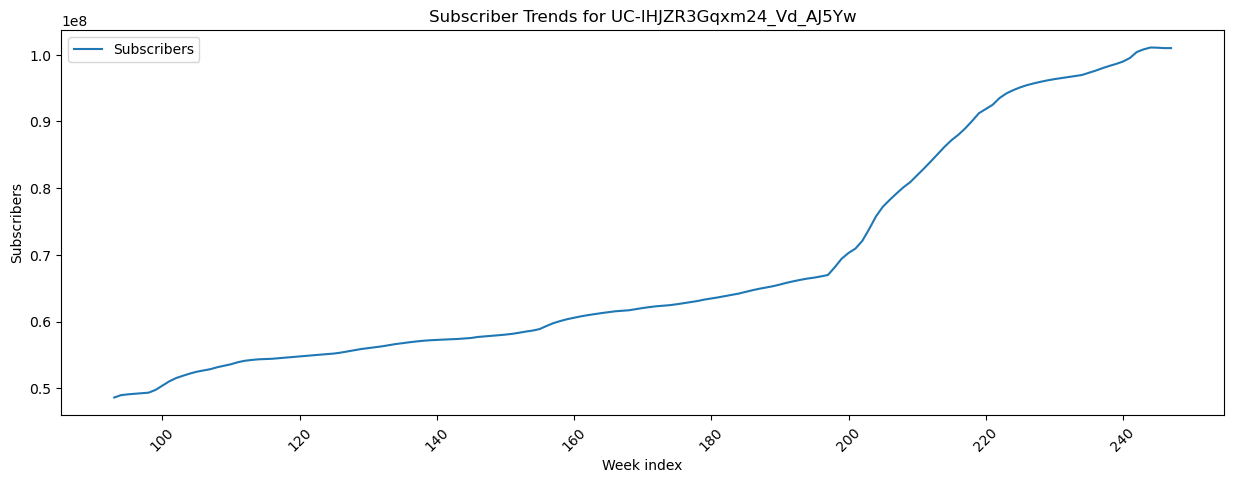

In [9]:
plot_subs_by_channel(random_channel, data)

After plotting the evolution of the number of subscribers of these Youtube channels, we notice that most of them never have a decreasing number of subscribers, even though we know they all went through at least one bad buzz.

#### 2. Rolling average analysis
Since the big YouTube channels in our dataset typically experience consistent subscriber growth, they rarely face actual decreases in their total subscriber count. However, a significant slowdown in the growth rate can still be considered a negative event, as it may indicate potential issues such as reduced engagement or a negative reception by the audience. To detect these sharp declines in subscriber growth, we compare the actual growth rate (`delta_subs`) against the rolling average growth rate (`rolling_growth_rate`).\
The rolling average acts as a smoothed baseline, calculated using a defined window (we arbitrarily used a `ROLLING_WINDOW` of 20 weeks), which helps to identify deviations from the expected trend. When the actual growth rate falls below the rolling average, it suggests that the channel's performance has dipped relative to its typical trend. This comparison enables us to highlight periods of concern where the channel's momentum weakens, which could signal the start of a "bad buzz" or other negative factors impacting channel performance.

In [10]:
ROLLING_WINDOW = 20

data['rolling_growth_rate'] = data.groupby('channel')['delta_subs'].transform(lambda x: x.rolling(ROLLING_WINDOW, min_periods=1).mean())
data['growth_diff'] = data['delta_subs'] - data['rolling_growth_rate']

# Detection of period where growth_rate < rolling_growth_rate
data['is_bad_buzz'] = data['growth_diff'] < 0
# Create a DataFrame that contains only the starting week of each BBC
bad_buzz_starts = []

# For loop to detect the starting week of BB
for channel in data.reset_index()['channel'].unique():
    channel_data = data.reset_index()[data.reset_index()['channel'] == channel]
    
    # Identify indices where BB has started
    for i in range(1, len(channel_data)):
        if channel_data['is_bad_buzz'].iloc[i] and not channel_data['is_bad_buzz'].iloc[i-1]:
            bad_buzz_starts.append({'channel': channel, 'week': channel_data['week'].iloc[i]})

bad_buzz_df = pd.DataFrame(bad_buzz_starts).reset_index()[['channel', 'week']]

max_nb_bb = bad_buzz_df.groupby('channel').count()['week'].max()
print(f'A channel has a maximum of {max_nb_bb}')

bad_buzz_df

A channel has a maximum of 22


channel  week
0    UC-lHJZR3Gqxm24_Vd_AJ5Yw    95
1    UC-lHJZR3Gqxm24_Vd_AJ5Yw   104
2    UC-lHJZR3Gqxm24_Vd_AJ5Yw   112
3    UC-lHJZR3Gqxm24_Vd_AJ5Yw   130
4    UC-lHJZR3Gqxm24_Vd_AJ5Yw   137
..                        ...   ...
499  UCzKc6JrWSt_67UpEYIefrJQ   182
500  UCzKc6JrWSt_67UpEYIefrJQ   188
501  UCzKc6JrWSt_67UpEYIefrJQ   198
502  UCzKc6JrWSt_67UpEYIefrJQ   205
503  UCzKc6JrWSt_67UpEYIefrJQ   244

[504 rows x 2 columns]

In order to get the periods of concern, we save in the dataframe `bad_buzz_df` the first week index of the period where growth_rate < rolling_growth_rate.

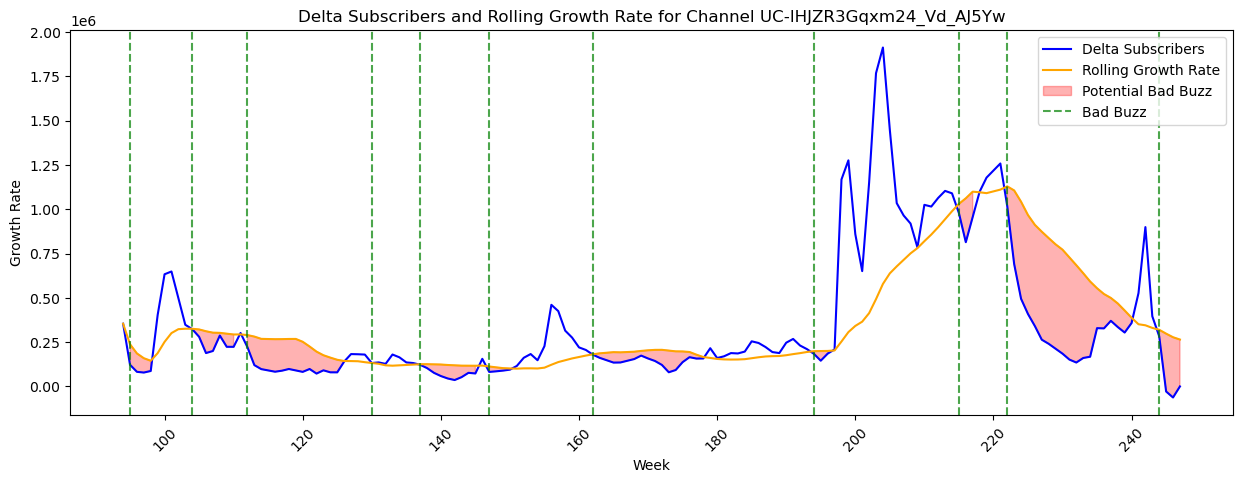

In [11]:
plot_rolling_growth_rate(random_channel, data, bad_buzz_df, event_name='Bad Buzz')

Now that we detected periods of concern that are potential "bad buzz", we want to see if the change of growth rate correlates with other engagement metrics or events. Specifically, we aim to identify relationships between these slowdowns in subscriber growth and various possible influencing factors such as:
- Number of views
- Like/Dislike ratio
- Activity

### B. Views Analysis around Detected Bad Buzz 
During this part of the analysis, we want to visualize changes in views around the periods of interest detected previously, to explore the behavior of `delta_views` around the identified periods for each YouTube channel.\
We use the `define_periods` function to divide the data into:
- Pre-buzz: 10 weeks leading up to the bad buzz event.
- During-buzz: The 10-week period starting from the bad buzz week.
- Post-buzz: The following 10 to 20 weeks post-buzz.


#### 1. Delta Views Evolution

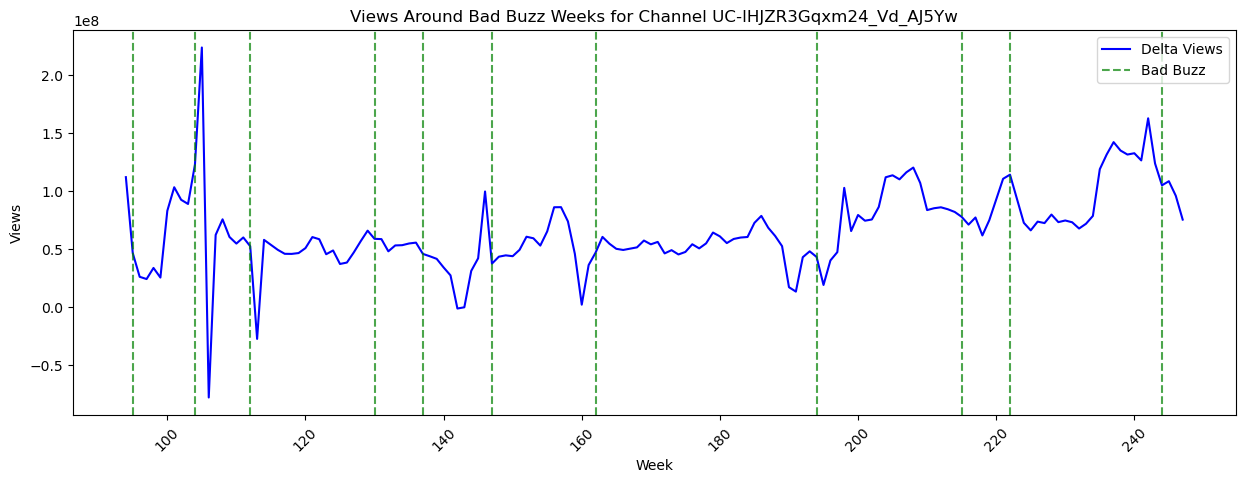

In [12]:
plot_views_around_bad_buzz(random_channel, data, bad_buzz_df)

For the pre-buzz, during-buzz, and post-buzz periods of each detected period, we compute the average `delta_views` and perform a t-test to determine if the change in views during the bad buzz is statistically significant compared to the pre-buzz period. The `analyze_views_around_bad_buzz` function iterates over each detected bad buzz week, to analyze how delta_views changed around these periods.

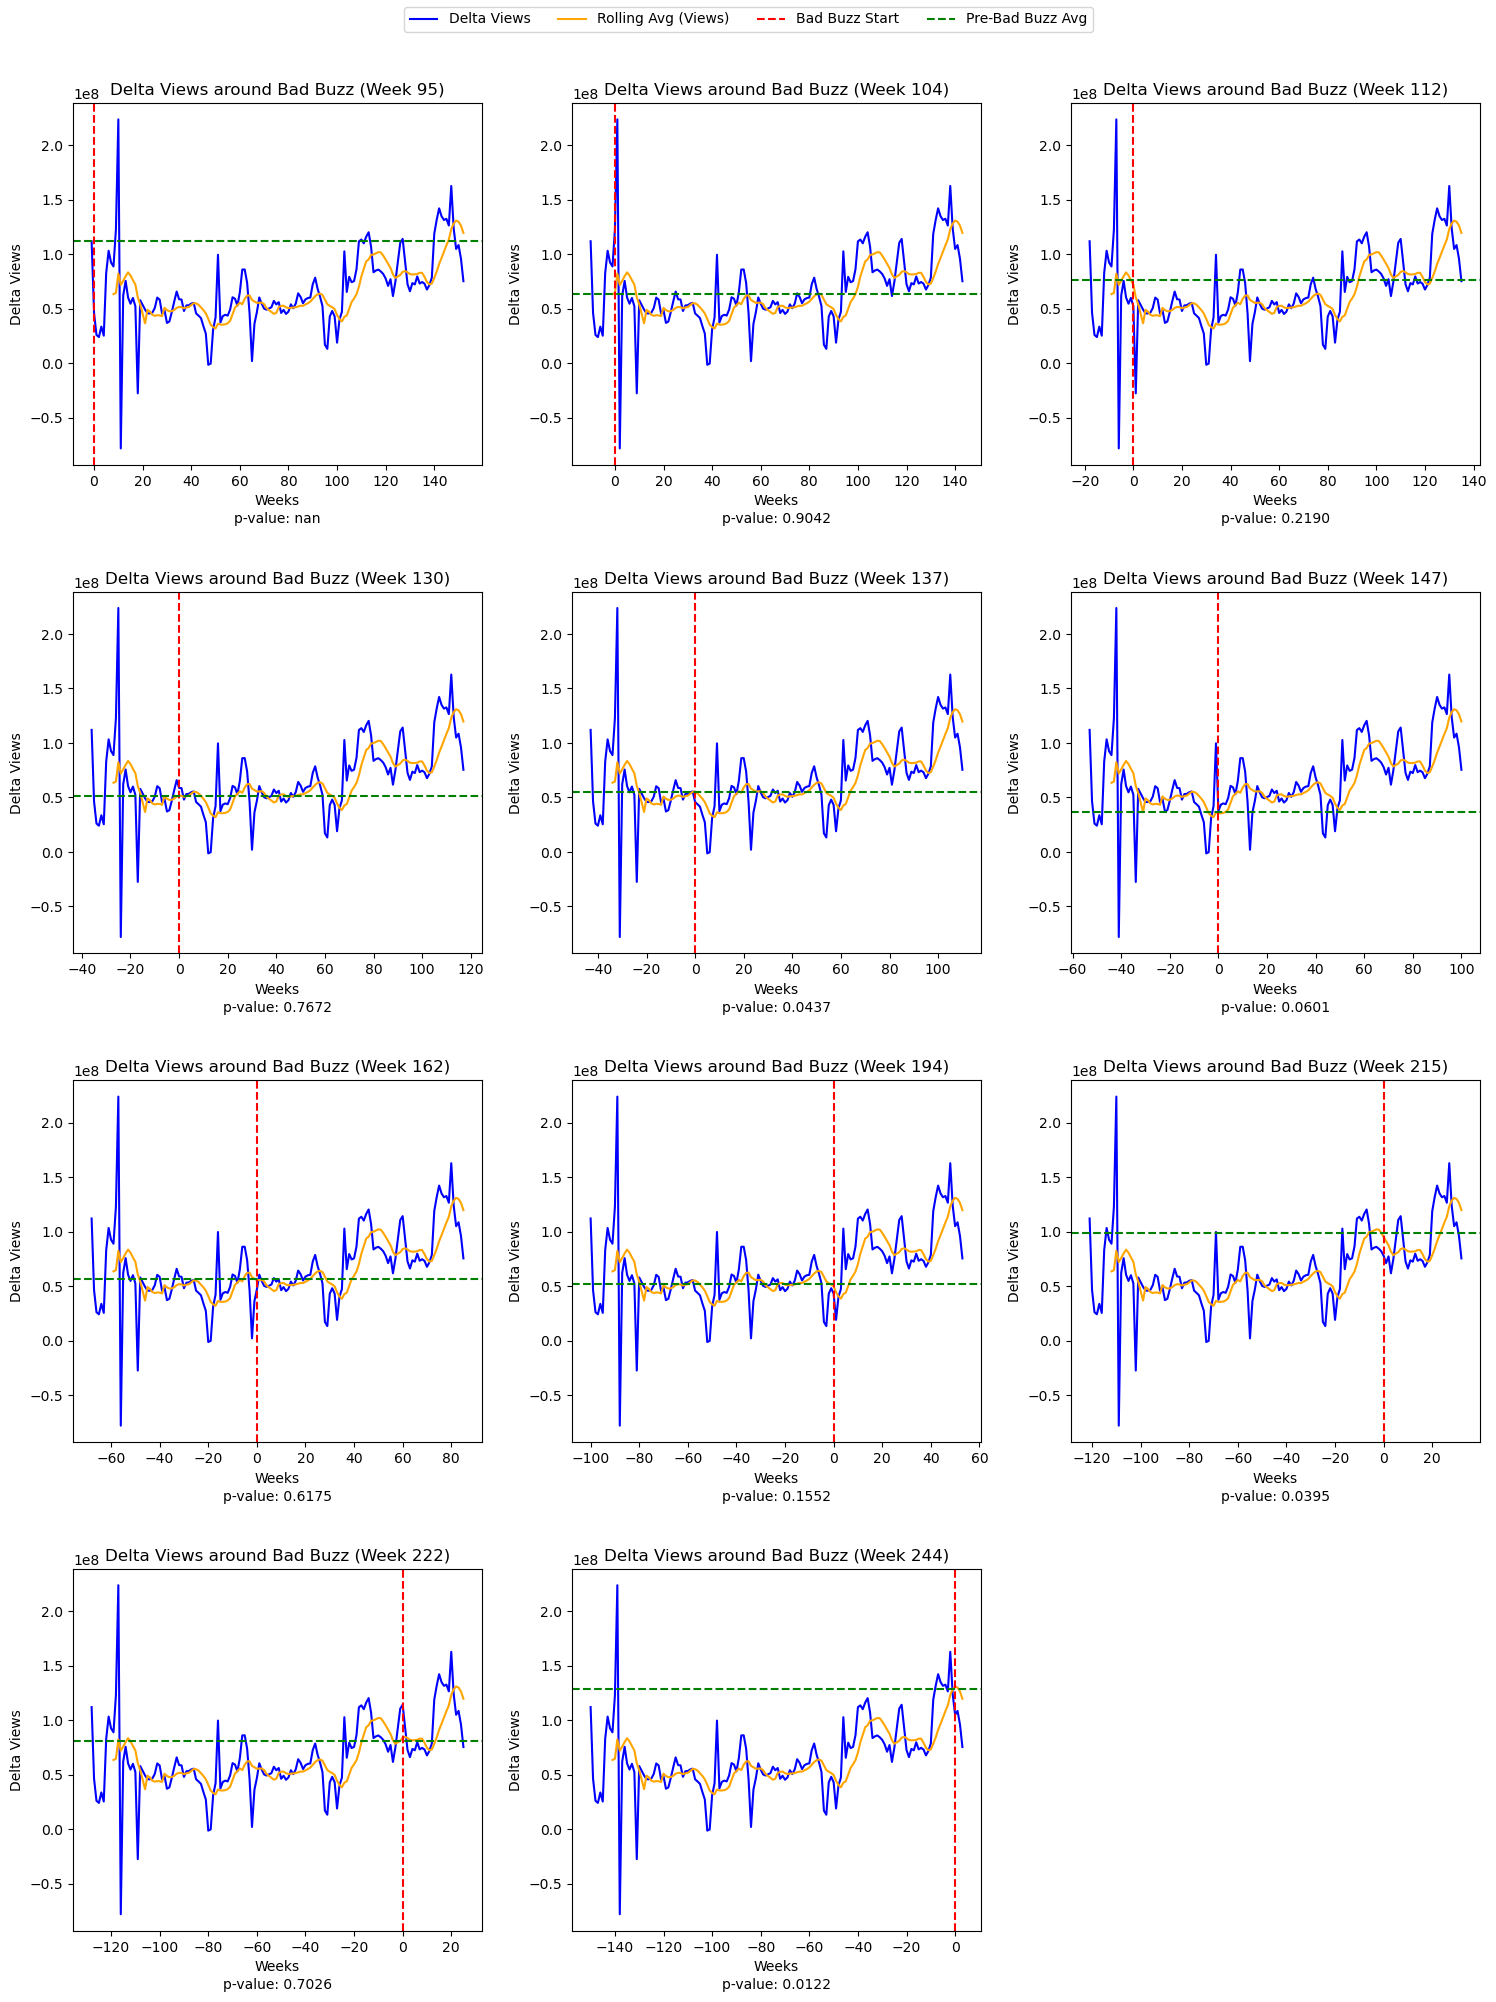

In [13]:
pew_die_pie = data.xs('UC-lHJZR3Gqxm24_Vd_AJ5Yw', level='channel').reset_index()
pew_die_pie_bb_weeks = bad_buzz_df[bad_buzz_df['channel'] == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw']['week']

fig, axes = plt.subplots(4, 3, figsize=(15, 20))

axes = axes.flatten()

for i, week in enumerate(pew_die_pie_bb_weeks):
    df_plot = normalize_week_indices(pew_die_pie, week)
    pre_buzz, during_buzz, post_buzz = define_periods(df_plot)
    avg_pre_buzz_views, avg_during_buzz_views, avg_post_buzz_views = calculate_averages(pre_buzz, during_buzz, post_buzz)
    
    p_value = perform_t_test(pre_buzz, during_buzz)
    
    plot_results(axes[i], df_plot, avg_pre_buzz_views, week, p_value, event_name="Bad Buzz")
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


fig.legend(*axes[0].get_legend_handles_labels(), loc='upper center', ncol=4)

plt.tight_layout()
plt.subplots_adjust(hspace=0.35, top=0.95)
plt.show()

Only a few of the detected periods of interest seem to be correlated with a significant change of views.\
We hypothesize the following:

- **Loss of Interest**: When audience engagement decreases due to a gradual loss of interest or content fatigue, we expect a sustained decrease in delta_views. This pattern reflects a natural decline in audience engagement without significant external attention. In this case, we are not expecting an important change between the `delta_views` averages of the `pre_buzz` and the `during_buzz` periods. It could be interesting to further explore this option by comparing the `pre_buzz` and `post_buzz` averages.

- **Bad Buzz Event**: Conversely, when audience loss is triggered by a negative event (e.g., public backlash or negative media coverage), we hypothesize that there will be an initial temporary spike in views. This increase results from heightened public interest or curiosity, as viewers seek to understand or react to the controversy.

It is possible that the events with a low p-value are the ones corresponding to bad buzz events, when the other ones correspond to a loss of interest and therefore don't have any drastic change of viewership.

The approach used in this part helps us understand whether significant shifts in views occur around the identified bad buzz periods.

### C. Likes/Dislikes Analysis Around Detected Bad Buzz

After investigating the number of views, we would now like to see if the number dislikes increase and if the number of likes decreases when a channel has a sudden drop of growth.

- 1. Normalize the timeline around each identified bad buzz event
- 2. Compare metrics for pre-buzz, during-buzz, and post-buzz periods:
    - Pre-Buzz: Let's say the 10 weeks leading up to the bad buzz
    - During Buzz: The week of the bad buzz and the 9 weeks following it
    - Post-Buzz: The 10 weeks after the initial bad buzz period\
Key metrics:
    - like_count: The number of likes received during a specific week
    - dislike_count: The number of dislikes received during a specific week
    - Like/Dislike Ratio: Calculated as like_count / (like_count + dislike_count)

- 3. Hypothesis Testing
    - Hypothesis: During a bad buzz, dislike_count should increase, and like_count or the like/dislike ratio should decrease
You can verify this by comparing averages and performing statistical tests to see if there’s a significant change in these metrics during the bad buzz period compared to the pre-buzz period.

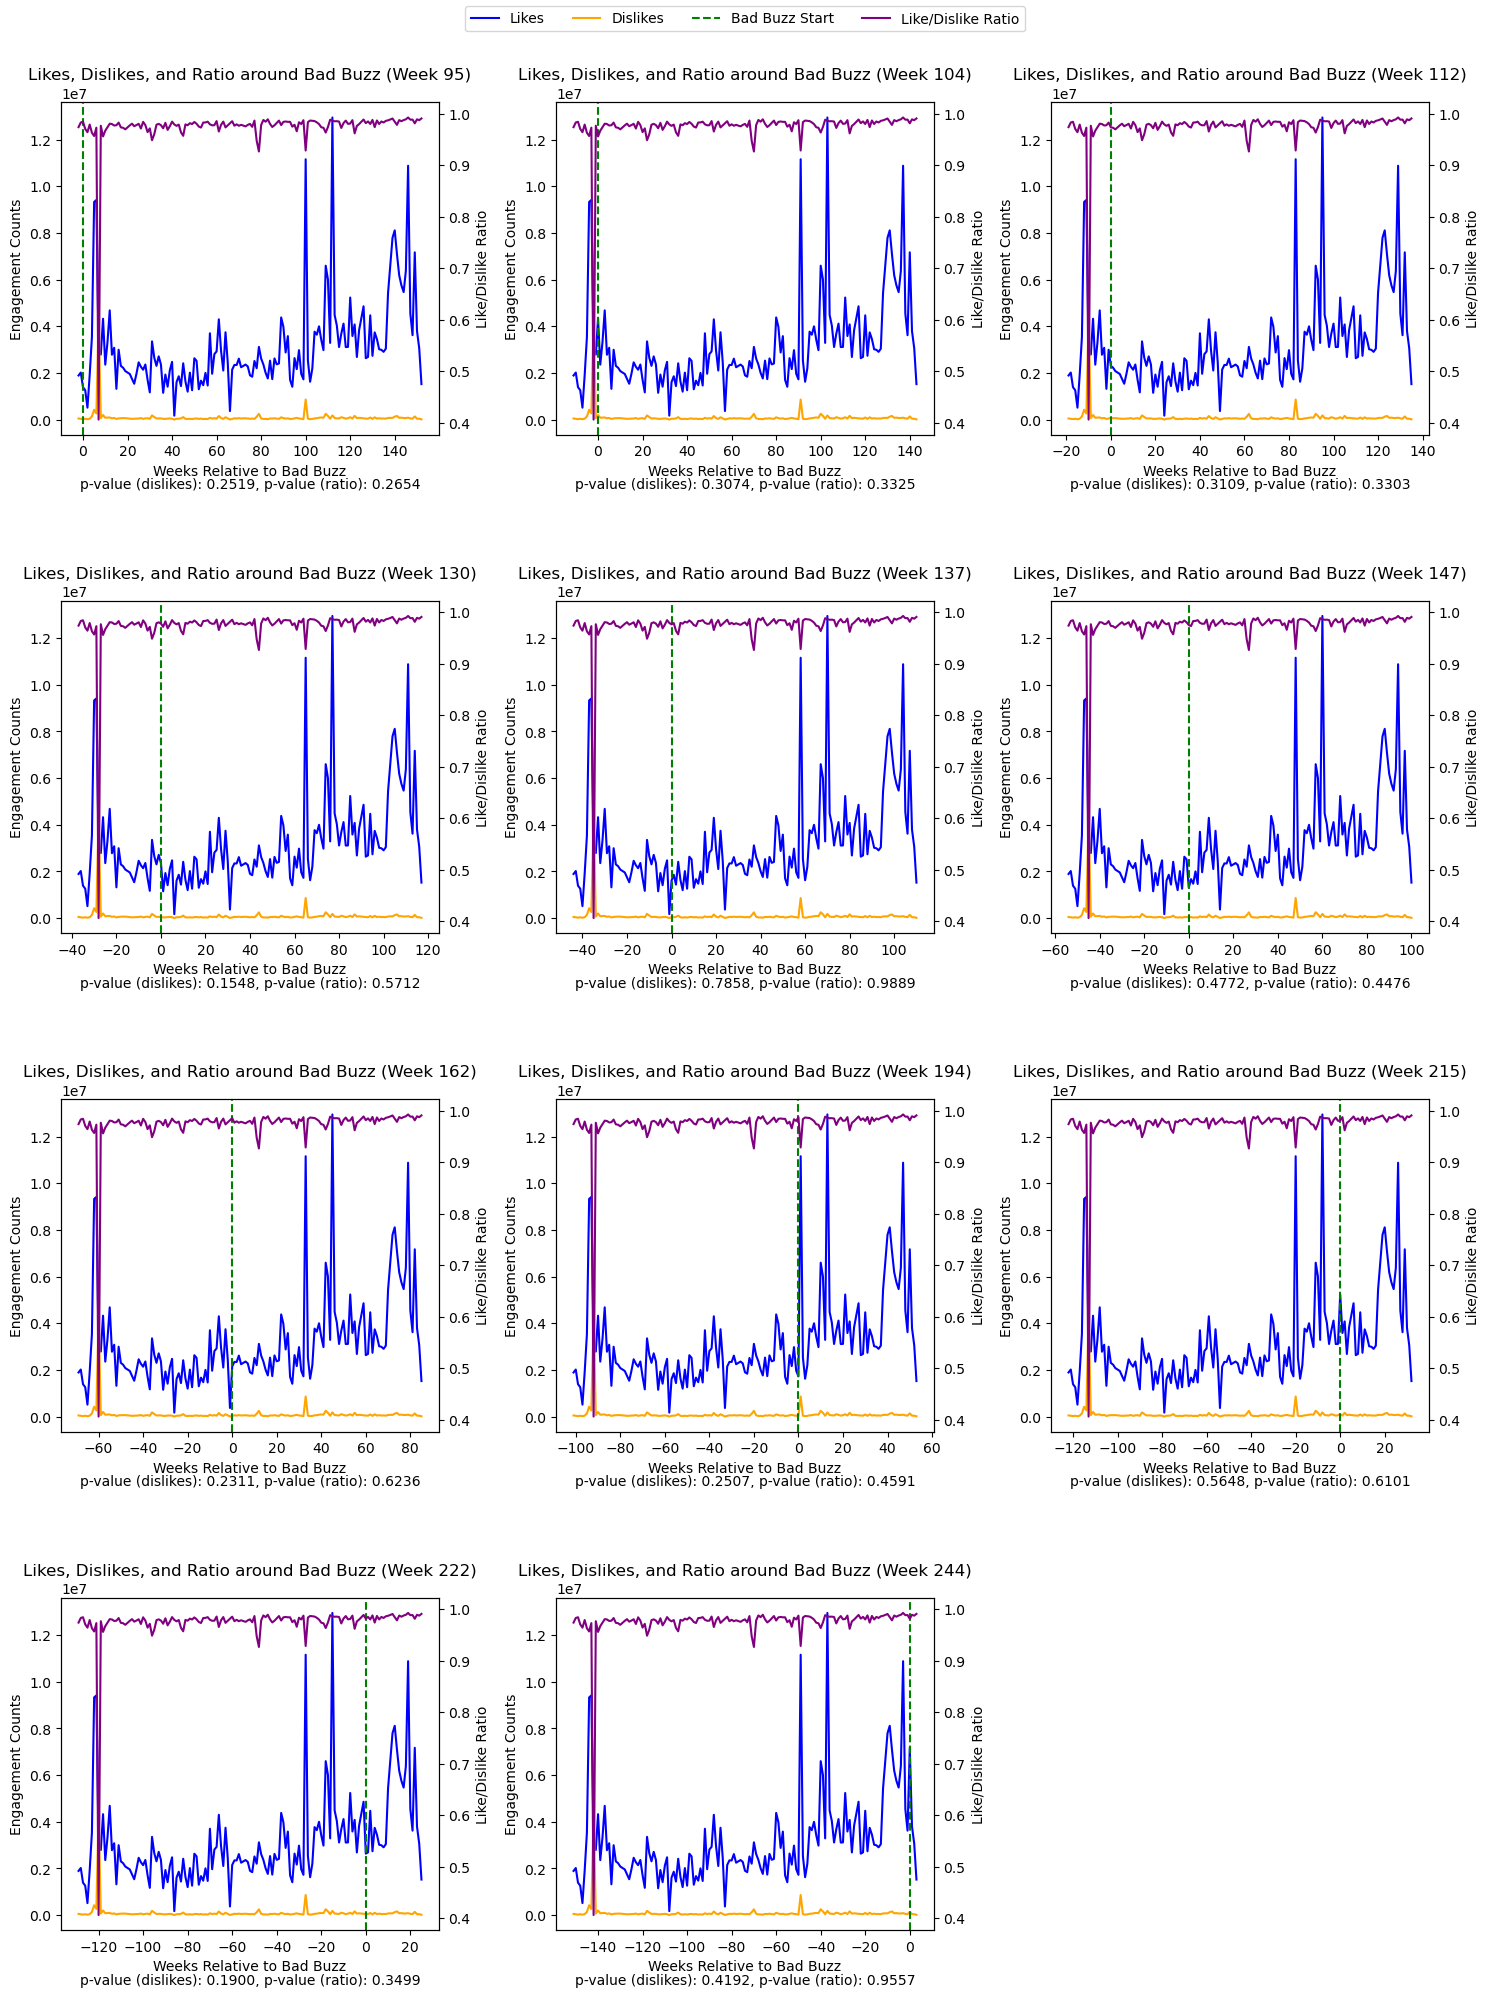

In [14]:
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

axes = axes.flatten()

for i, week in enumerate(pew_die_pie_bb_weeks):
    df_plot = normalize_week_indices(pew_die_pie, week)
    pre_buzz, during_buzz, post_buzz = define_periods(df_plot)
    avg_pre_likes, avg_pre_dislikes, avg_pre_ratio, avg_during_likes, avg_during_dislikes, avg_during_ratio = calculate_engagement_averages(pre_buzz, during_buzz)
    
    p_value_dislikes, p_value_ratio = perform_engagement_t_tests(pre_buzz, during_buzz)
    
    plot_engagement_results(axes[i], df_plot, week, p_value_dislikes, p_value_ratio)
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
lines, labels = axes[0].get_legend_handles_labels()
fig.legend(lines + [plt.Line2D([0], [0], color="purple", lw=1.5)], labels + ["Like/Dislike Ratio"], loc='upper center', ncol=4)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show()

Some of the periods of interest seem be correlated with a drop of the Like/Dislike ratio, for example the ones that happen during week 104 or week 194.
We can hypothesize that in the case of a lost of interest, the Like/Dislike ratio of the channel doesn't change significantly. On the other side, if a channel has a bad buzz event, it will probably coincide with a lower Like/Dislike ratio that reflects the change of the public's opinion on the channel.\
It is possible that the events with a low p-value are the ones corresponding to bad buzz events, when the other ones correspond to a loss of interest and therefore don't have any drastic change of viewership. In the example plotted above, all the p-values are high, suggesting that the changes of Like/Dislike ratio of the periods of interest shown are not statistically significant. Since we can see some correlation on the graphs, maybe we could investigate further and try different `pre_buzz`, `during_buzz`and `post_buzz` periods.

### D. Activity around the BB 
In this part, we want to see if the activity of a youtube channel and its growth are correlated.\
Two hypotheses:
- An activity lower than usual could induce a down-turn of the channel growth
- A period of slower growth could be followed by a high- or low- activity, depending on the strategy of the youtube channel

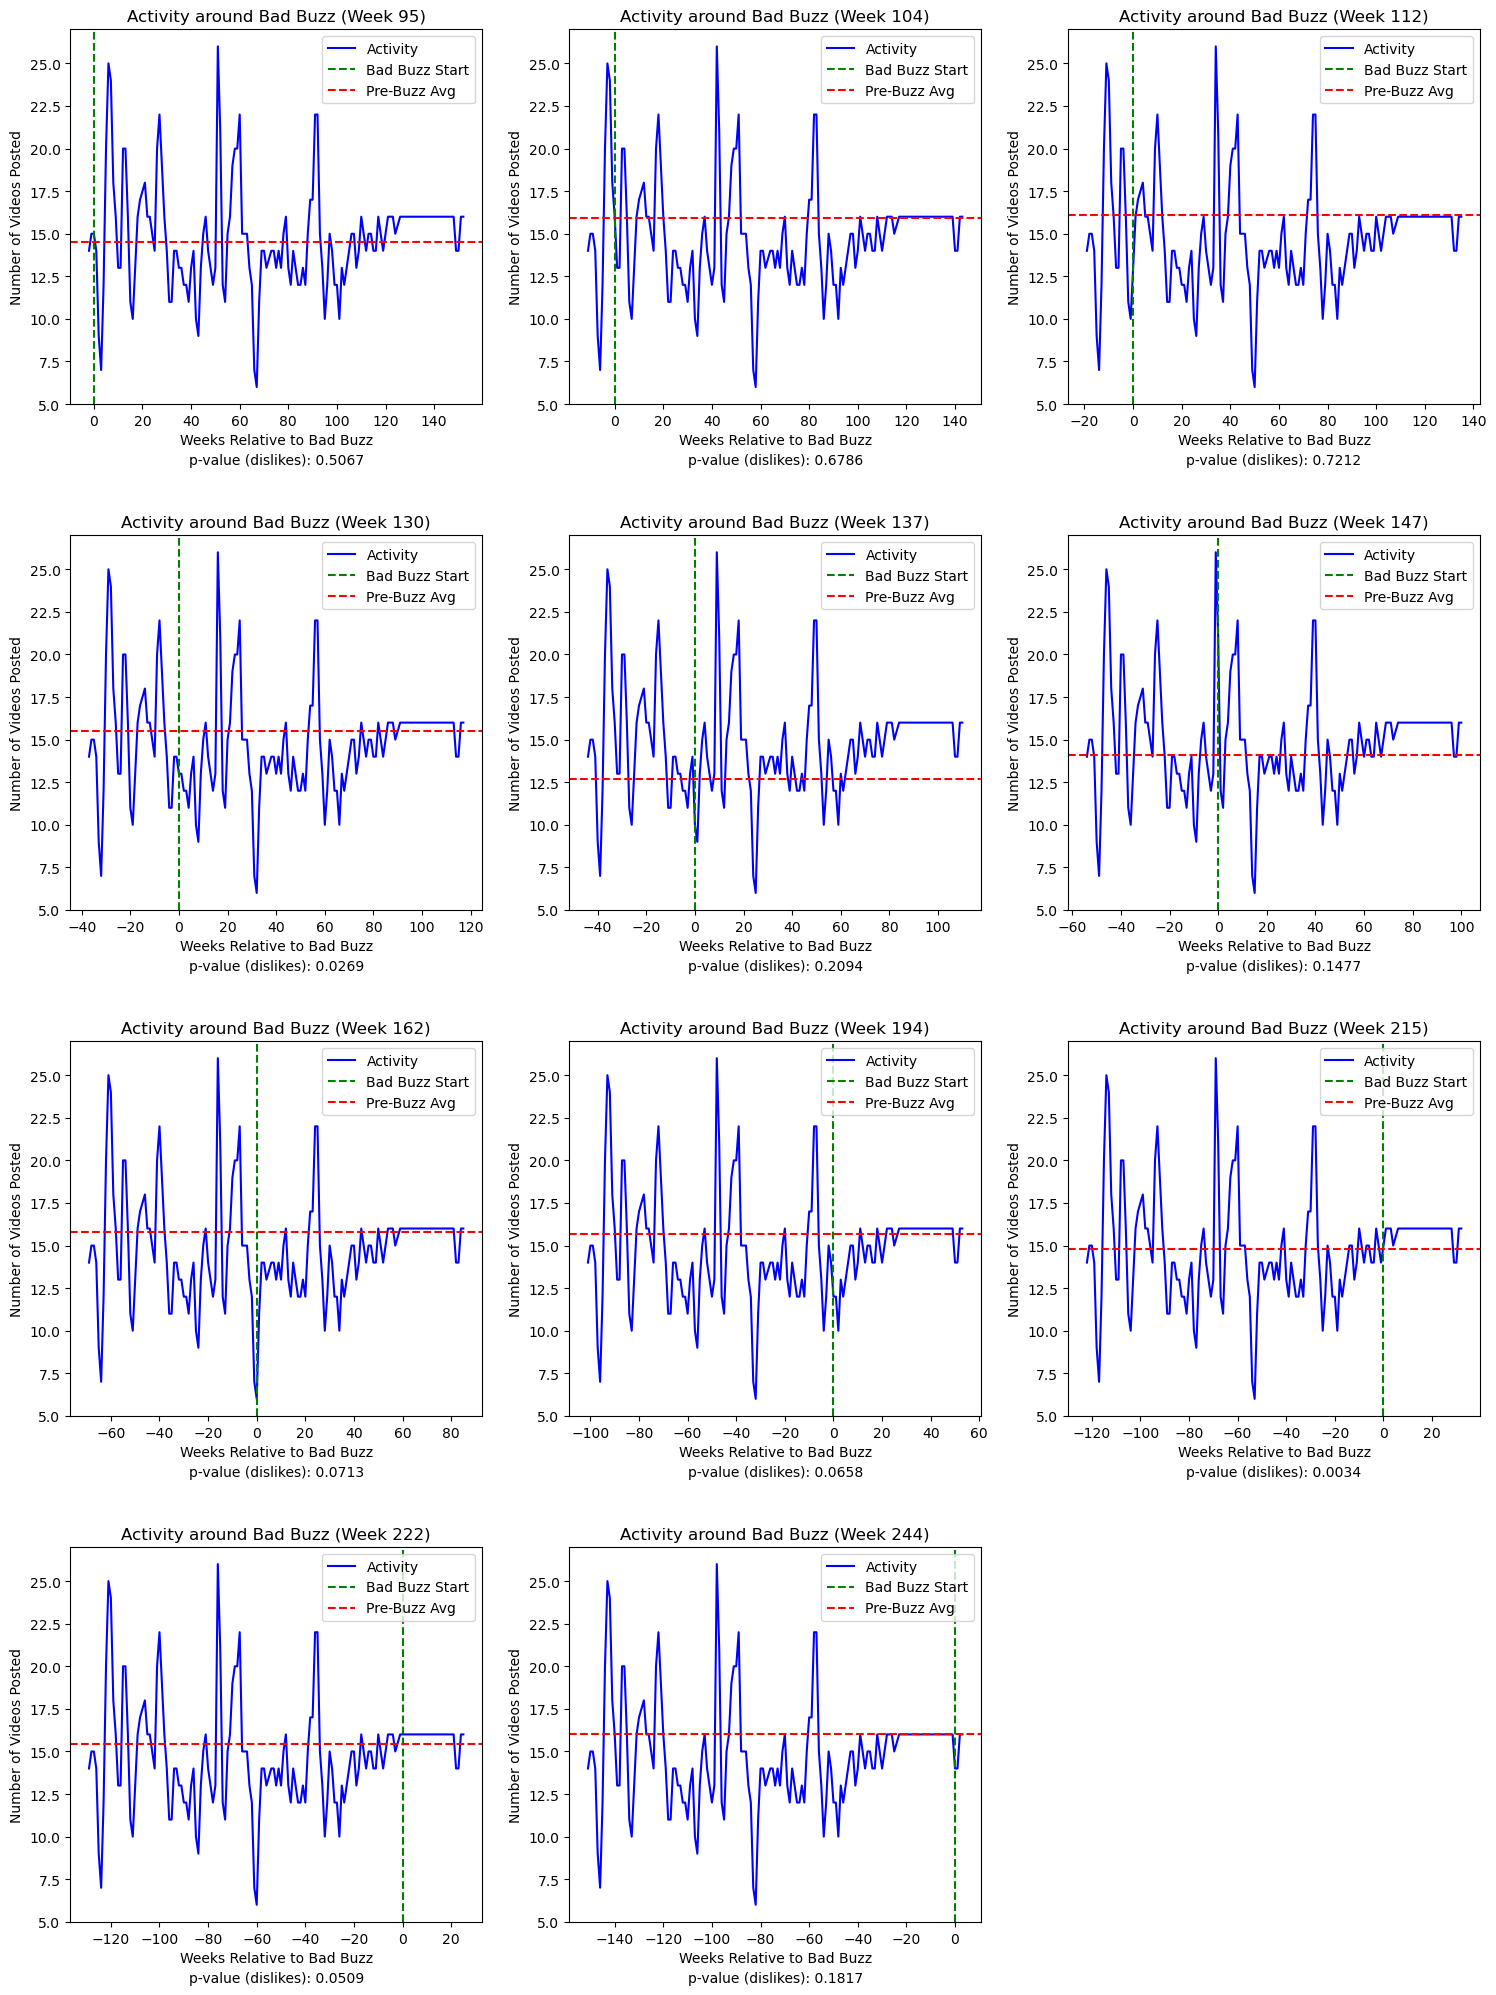

In [15]:
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.")

fig, axes = plt.subplots(4, 3, figsize=(15, 20))

axes = axes.flatten()

for i, week in enumerate(pew_die_pie_bb_weeks):
    df_plot = normalize_week_indices(pew_die_pie, week)
    pre_buzz, during_buzz, post_buzz = define_periods(df_plot)
    avg_pre_activity, avg_during_activity, avg_post_activity = calculate_activity_averages(pre_buzz, during_buzz, post_buzz)
    
    p_value_activity = perform_activity_t_tests(pre_buzz, during_buzz)
    
    plot_activity_results(axes[i], df_plot, avg_pre_activity, week, p_value_activity)
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(hspace=0.35)
plt.show()

When looking at these plots, we can see that the p-values of some of the events represented are very low (for example during weeks 130 or 215), suggesting that there might be a correlation between these channel's growth and their activity. Nonetheless, the graphs shown above are difficult to interpret since there is no clear pattern in the activity of the channel around the periods of interest.\
We could have a better understanding of the trends of the activity around periods of slow growth by also performing t-tests with different time periods: one the week before the start of the detected periods and one the few weeks before, in order to see if a lower activity might be correlated with a lower growth rate.

We create a dataframe containing the channels, their categories and the events of growth drop.

In [16]:
bad_buzz_df = bad_buzz_df.rename(columns={'week': 'event'})
df_merge = bad_buzz_df.merge(data.reset_index(), on='channel')
df_merge = df_merge.set_index(['channel', 'week'])
df_merge

event        category         views  \
channel                  week                                        
UC-lHJZR3Gqxm24_Vd_AJ5Yw 93       95          Gaming  1.357761e+10   
                         94       95          Gaming  1.368959e+10   
                         95       95          Gaming  1.373594e+10   
                         96       95          Gaming  1.376195e+10   
                         97       95          Gaming  1.378603e+10   
...                              ...             ...           ...   
UCzKc6JrWSt_67UpEYIefrJQ 243     244  People & Blogs  1.060344e+08   
                         244     244  People & Blogs  1.061163e+08   
                         245     244  People & Blogs  1.061940e+08   
                         246     244  People & Blogs  1.062897e+08   
                         247     244  People & Blogs  1.063659e+08   

                                delta_views          subs     delta_subs  \
channel                  week                                              
UC-lHJZR3Gqxm24_Vd_AJ5Yw 93             NaN  4.861796e+07            NaN   
                         94    1.119836e+08  4.897182e+07  353856.680699   
                         95    4.635159e+07  4.909397e+07  122152.626592   
                         96    2.600902e+07  4.917638e+07   82404.010417   
                         97    2.407718e+07  4.925474e+07   78360.625000   
...                                     ...           ...            ...   
UCzKc6JrWSt_67UpEYIefrJQ 243   1.160609e+05  2.142763e+06    1756.125000   
                         244   8.184225e+04  2.143576e+06     812.875000   
                         245   7.769925e+04  2.140923e+06   -2652.875000   
                         246   9.572875e+04  2.140000e+06    -923.000000   
                         247   7.618318e+04  2.140000e+06       0.000000   

                               videos  delta_videos  activity  view_count  \
channel                  week                                               
UC-lHJZR3Gqxm24_Vd_AJ5Yw 93      2906           NaN        14  45210757.0   
                         94      2919          13.0        15  40885232.0   
                         95      2926           7.0        15  27707359.0   
                         96      2932           6.0        14  25489724.0   
                         97      2934           2.0         9  10034755.0   
...                               ...           ...       ...         ...   
UCzKc6JrWSt_67UpEYIefrJQ 243      259           0.0         0         0.0   
                         244      259           0.0         0         0.0   
                         245      259           0.0         0         0.0   
                         246      259           0.0         0         0.0   
                         247      259           0.0         0         0.0   

                               like_count  dislike_count  rolling_growth_rate  \
channel                  week                                                   
UC-lHJZR3Gqxm24_Vd_AJ5Yw 93     1892943.0        51248.0                  NaN   
                         94     2018614.0        35580.0        353856.680699   
                         95     1390650.0        22598.0        238004.653646   
                         96     1261334.0        38704.0        186137.772569   
                         97      514876.0        19313.0        159193.485677   
...                                   ...            ...                  ...   
UCzKc6JrWSt_67UpEYIefrJQ 243          0.0            0.0          1215.675000   
                         244          0.0            0.0          1286.093750   
                         245          0.0            0.0          1185.500000   
                         246          0.0            0.0          1172.637500   
                         247          0.0            0.0          1199.850000   

                                 growth_diff  is_bad_buzz  
channel        

#### Total Number of Events by Category
We are plotting the number of events where the growth rate of a channel decreases abruptly by channel category in order to see if some categories are more prone to experience sudden changes of `delta_subs`.

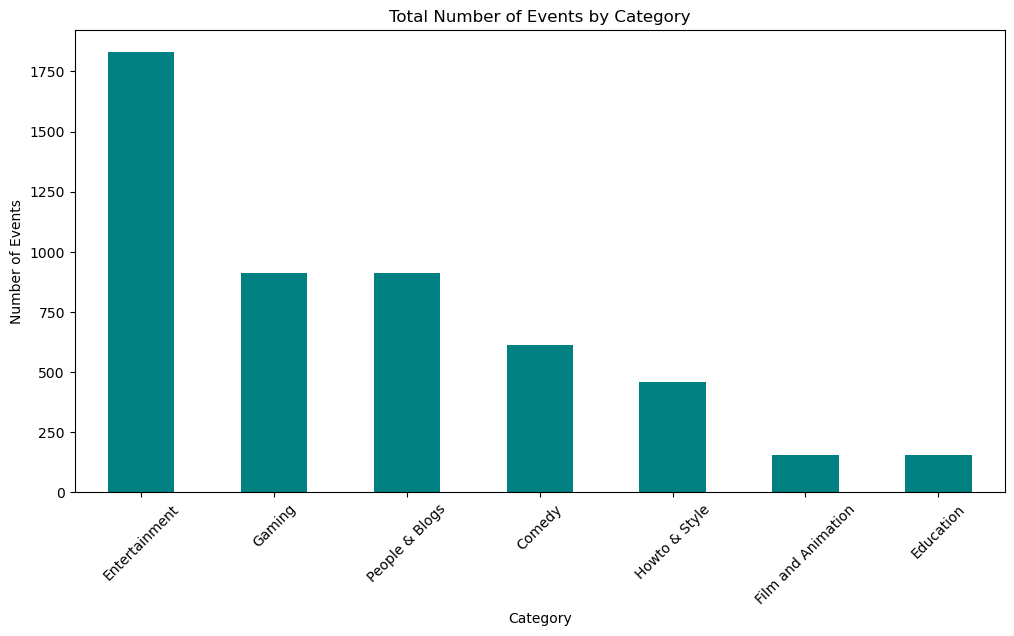

In [17]:
category_counts = data['category'].value_counts()
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar', color='teal')
plt.title('Total Number of Events by Category')
plt.xlabel('Category')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.show()

We can observe that the category `Entertainment` is the category with the most important number of growth rate drops.\
The `Film and Animation` and the `Education` channels are the categories with the fewest negative events observed.

## III. Data Analysis On All Dataset 

### Data Processing

In [19]:
original_data.head()

category      views  delta_views  \
channel                  week                                            
UC--24Q3_ZQeFmgJE-Um5QZQ 82    Travel & Events  62524.500          NaN   
                         83    Travel & Events  67600.250     5075.750   
                         84    Travel & Events  69982.000     2381.750   
                         85    Travel & Events  72663.125     2681.125   
                         86    Travel & Events  75093.000     2429.875   

                                   subs  delta_subs  videos  delta_videos  \
channel                  week                                               
UC--24Q3_ZQeFmgJE-Um5QZQ 82    1466.000         NaN      29           NaN   
                         83    1508.625      42.625      30           1.0   
                         84    1530.750      22.125      31           1.0   
                         85    1558.625      27.875      32           1.0   
                         86    1591.000      32.375      33           1.0   

                               activity  view_count  like_count  dislike_count  
channel                  week                                                   
UC--24Q3_ZQeFmgJE-Um5QZQ 82           1      5849.0       222.0            1.0  
                         83           2      5336.0       204.0            1.0  
                         84           2      5727.0       232.0            1.0  
                         85           2     19214.0       318.0            7.0  
                         86           2      6949.0       234.0            1.0

## Important Note:

The 2 following cells compute the rolling average of the growth rate of the number of subscribers for each channel, as well as the week_index of the detected decrease in popularity events. This computation is very time-consuming and requires a lot of memory. It is not necessary to run these cells if you already have the files 'df_wth_rgr.tsv' and 'event.tsv' in the 'data' folder. Simply skip them if you already have the file.

In [ ]:
ROLLING_WINDOW = 20

original_data['rolling_growth_rate'] = original_data.groupby('channel')['delta_subs'].transform(lambda x: x.rolling(ROLLING_WINDOW, min_periods=1).mean())

# Initialize an empty DataFrame to store the results
result = pd.DataFrame()

# Iterate over each group with a progress bar
for name, group in tqdm(original_data.groupby('channel'), desc="Processing channels"):
    group['rolling_growth_rate'] = group['delta_subs'].rolling(ROLLING_WINDOW, min_periods=1).mean()
    result = pd.concat([result, group])

result['growth_diff'] = result['delta_subs'] - result['rolling_growth_rate']

# Detection of period where growth_rate < rolling_growth_rate
result['is_bad_buzz'] = result['growth_diff'] < 0

result.to_csv('data/df_with_rgr.tsv', sep='\t', index=True)

In [18]:
df_with_rgr = pd.read_csv('Data/df_with_rgr.tsv', sep='\t')
df_with_rgr.head()

category      views  delta_views      subs  delta_subs  videos  \
0  Travel & Events  62524.500          NaN  1466.000         NaN      29   
1  Travel & Events  67600.250     5075.750  1508.625      42.625      30   
2  Travel & Events  69982.000     2381.750  1530.750      22.125      31   
3  Travel & Events  72663.125     2681.125  1558.625      27.875      32   
4  Travel & Events  75093.000     2429.875  1591.000      32.375      33   

   delta_videos  activity  view_count  like_count  dislike_count  \
0           NaN         1      5849.0       222.0            1.0   
1           1.0         2      5336.0       204.0            1.0   
2           1.0         2      5727.0       232.0            1.0   
3           1.0         2     19214.0       318.0            7.0   
4           1.0         2      6949.0       234.0            1.0   

   rolling_growth_rate  growth_diff  is_bad_buzz  
0                  NaN          NaN        False  
1               42.625        0.000        False  
2               32.375      -10.250         True  
3               30.875       -3.000         True  
4               31.250        1.125        False

In [19]:
df_with_rgr.index = original_data.index
df_with_rgr.head()

category      views  delta_views  \
channel                  week                                            
UC--24Q3_ZQeFmgJE-Um5QZQ 82    Travel & Events  62524.500          NaN   
                         83    Travel & Events  67600.250     5075.750   
                         84    Travel & Events  69982.000     2381.750   
                         85    Travel & Events  72663.125     2681.125   
                         86    Travel & Events  75093.000     2429.875   

                                   subs  delta_subs  videos  delta_videos  \
channel                  week                                               
UC--24Q3_ZQeFmgJE-Um5QZQ 82    1466.000         NaN      29           NaN   
                         83    1508.625      42.625      30           1.0   
                         84    1530.750      22.125      31           1.0   
                         85    1558.625      27.875      32           1.0   
                         86    1591.000      32.375      33           1.0   

                               activity  view_count  like_count  \
channel                  week                                     
UC--24Q3_ZQeFmgJE-Um5QZQ 82           1      5849.0       222.0   
                         83           2      5336.0       204.0   
                         84           2      5727.0       232.0   
                         85           2     19214.0       318.0   
                         86           2      6949.0       234.0   

                               dislike_count  rolling_growth_rate  \
channel                  week                                       
UC--24Q3_ZQeFmgJE-Um5QZQ 82              1.0                  NaN   
                         83              1.0               42.625   
                         84              1.0               32.375   
                         85              7.0               30.875   
                         86              1.0               31.250   

                               growth_diff  is_bad_buzz  
channel                  week                            
UC--24Q3_ZQeFmgJE-Um5QZQ 82            NaN        False  
                         83          0.000        False  
                         84        -10.250         True  
                         85         -3.000         True  
                         86          1.125        False

In [20]:
nb_channels = df_with_rgr.reset_index()['channel'].nunique()

print(f'Number of channels : {nb_channels}')

Number of channels : 133516


In [21]:
# Create a DataFrame that contains only the starting week of each BBC
bad_buzz_starts = []

df_with_rgr_grouped = df_with_rgr.reset_index().groupby('channel')

print(f'Number of channels : {len(df_with_rgr_grouped.groups.keys())}')


Number of channels : 133516


In [22]:
# For loop to detect the starting week of BB
for channel in tqdm(df_with_rgr_grouped.groups.keys(), desc="Processing channels"):
    channel_data = df_with_rgr_grouped.get_group(channel)
    
    # Identify indices where BB has started
    for i in range(1, len(channel_data)):
        if channel_data['is_bad_buzz'].iloc[i] and not channel_data['is_bad_buzz'].iloc[i-1]:
            bad_buzz_starts.append({'channel': channel, 'week': channel_data['week'].iloc[i]})

Processing channels: 100%|██████████| 133516/133516 [01:31<00:00, 1460.16it/s]


In [24]:
bad_buzz_odf = pd.DataFrame(bad_buzz_starts)
bad_buzz_odf.head()

channel  week
0  UC--24Q3_ZQeFmgJE-Um5QZQ    84
1  UC--24Q3_ZQeFmgJE-Um5QZQ    87
2  UC--24Q3_ZQeFmgJE-Um5QZQ    93
3  UC--24Q3_ZQeFmgJE-Um5QZQ    95
4  UC--24Q3_ZQeFmgJE-Um5QZQ   105

In [132]:
bad_buzz_odf.head()
bad_buzz_odf.to_csv('Data/event.tsv', sep = '\t', index = False)

In [60]:
events= pd.read_csv('Data/event.tsv', sep='\t')
events.head(100)

channel  week
0   UC-lHJZR3Gqxm24_Vd_AJ5Yw    95
1   UC-lHJZR3Gqxm24_Vd_AJ5Yw   104
2   UC-lHJZR3Gqxm24_Vd_AJ5Yw   112
3   UC-lHJZR3Gqxm24_Vd_AJ5Yw   130
4   UC-lHJZR3Gqxm24_Vd_AJ5Yw   137
..                       ...   ...
95  UCBHu7LsKiwiYViR230RtsCA   147
96  UCBHu7LsKiwiYViR230RtsCA   152
97  UCBHu7LsKiwiYViR230RtsCA   157
98  UCBHu7LsKiwiYViR230RtsCA   172
99  UCBHu7LsKiwiYViR230RtsCA   179

[100 rows x 2 columns]

### A. Various Plots
We show different plots to have a more comprehensive view of the dataset, and to find interesting relationships that could be further investigated during the third part of the project.

#### Delta Subs by Category
We expect the channel category to play a role in content strategy and expectations for channel performance

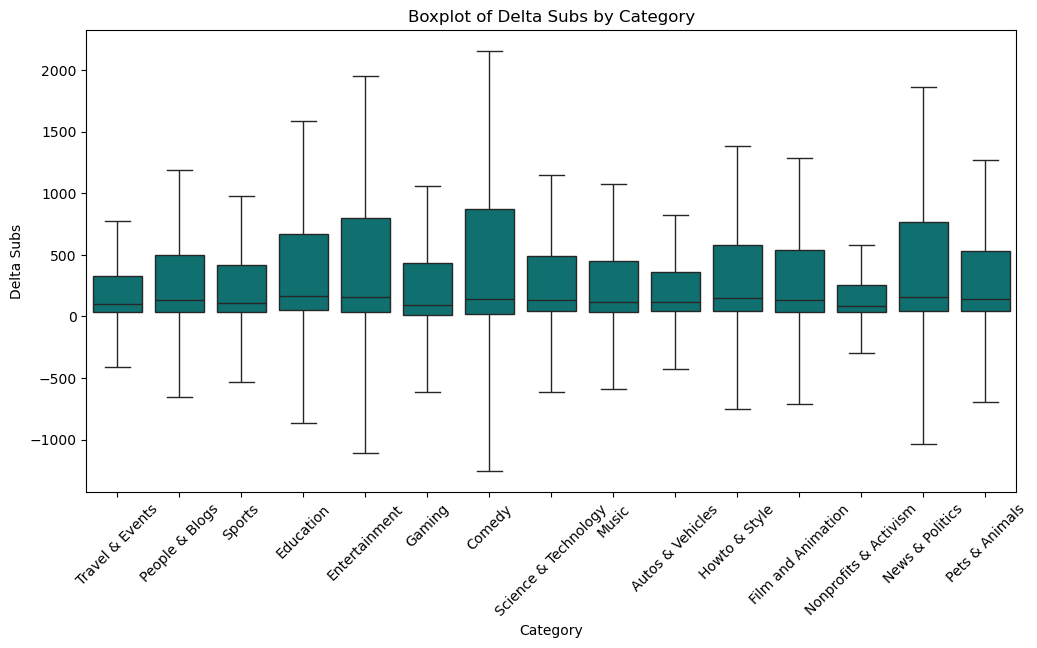

In [26]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_with_rgr, x='category', y='delta_subs', color='teal', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Delta Subs by Category')
plt.xlabel('Category')
plt.ylabel('Delta Subs')
plt.show()

Other categories like `Gaming` and `Film and Animation` have relatively smaller interquartile ranges, suggesting more consistent subscriber changes.\
`Education` shows minimal variability and a lower median change, suggesting that channels in this category typically experience smaller changes in subscribers.

#### Distribution of Growth Rate Declines Over Time


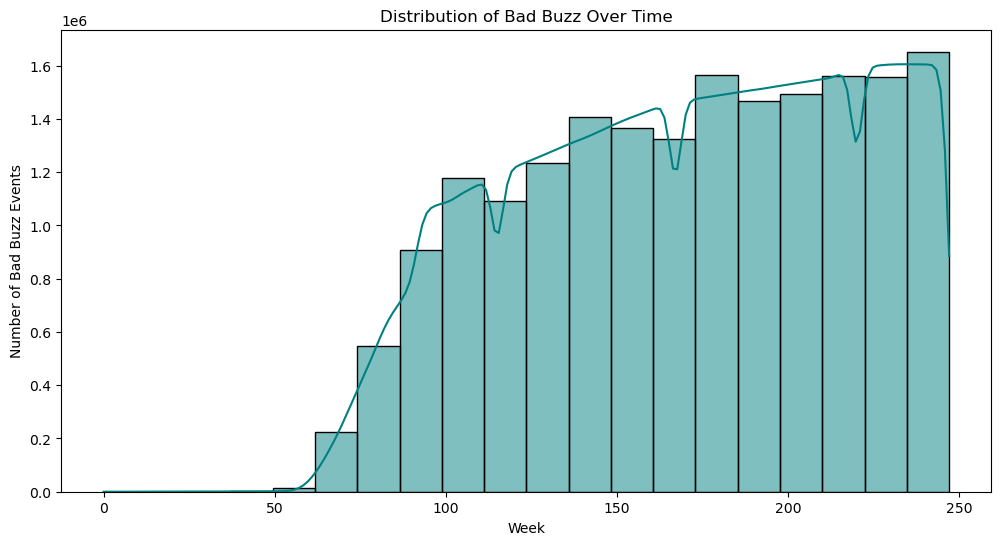

In [27]:
plt.figure(figsize=(12, 6))
sns.histplot(df_with_rgr.reset_index()['week'], bins=20, kde=True, color='teal')
plt.title('Distribution of Bad Buzz Over Time')
plt.xlabel('Week')
plt.ylabel('Number of Bad Buzz Events')
plt.show()

This plot can reveal whether there is a cyclical pattern in the occurrence of our periods of interest. However, in our dataset, such a trend is not evident, as the peaks do not seem to recur at consistent times of the year.


#### Correlation Matrix
This matrix allows to identify relationships between numerical features.

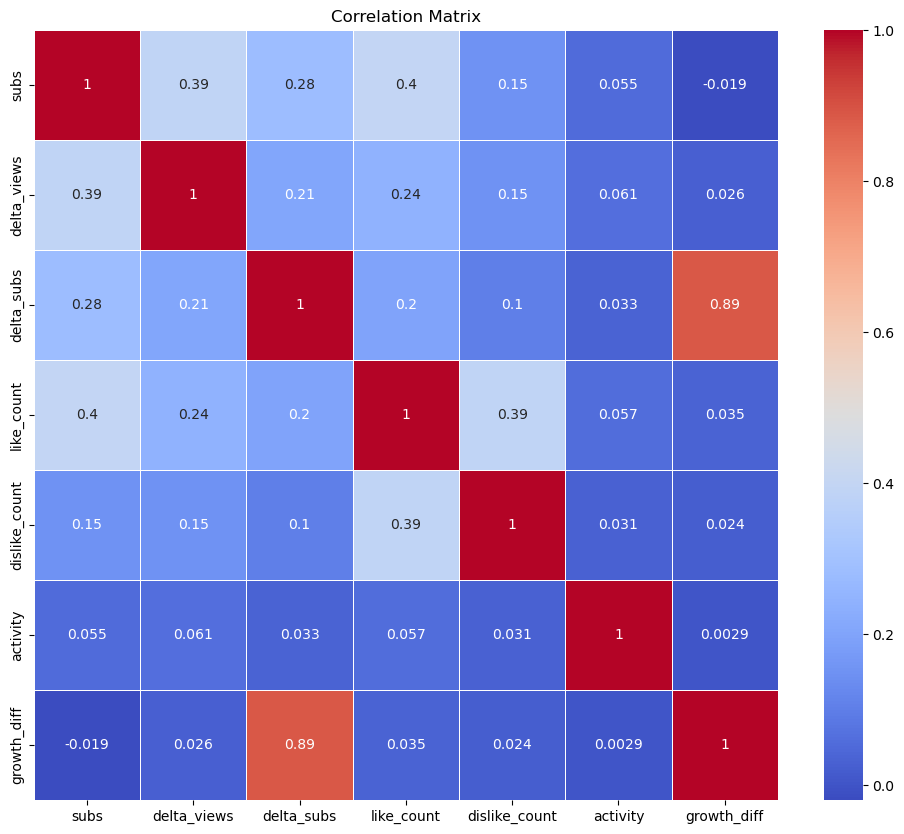

In [29]:
plt.figure(figsize=(12, 10))
selected_columns = ['subs','delta_views', 'delta_subs', 'like_count', 'dislike_count', 'activity', 'growth_diff']
numeric_df = df_with_rgr[selected_columns]  # Select only the specific columns

sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

When analyzing this matrix, we notice the following correlations:
- High Positive Correlations:
    - `like_count` and `subs` (0.73): There is a strong positive correlation, as the number of likes increases, the number of subscribers also tends to increase.
    - `delta_subs` and `like_count` (0.68): A positive relationship between changes in subscriber counts and the number of likes indicates that more likes might accompany subscriber growth.

- Lower Correlations:
    - `dislike_count` has lower correlations with most metrics, indicating that dislikes may not be strongly related to other growth metrics in this dataset.
    - `growth_diff` shows minimal correlation with most columns except delta_subs, hinting that it might capture unique aspects of growth fluctuation that are less related to likes, activity, or views.

In order to understand audience engagement, the columns showing high correlations with `subs` and `delta_subs` are particularly insightful.

#### Scatterplot of Activity vs Subscriber Growth
We want to investigate if higher activity correlates with better subscriber growth.

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


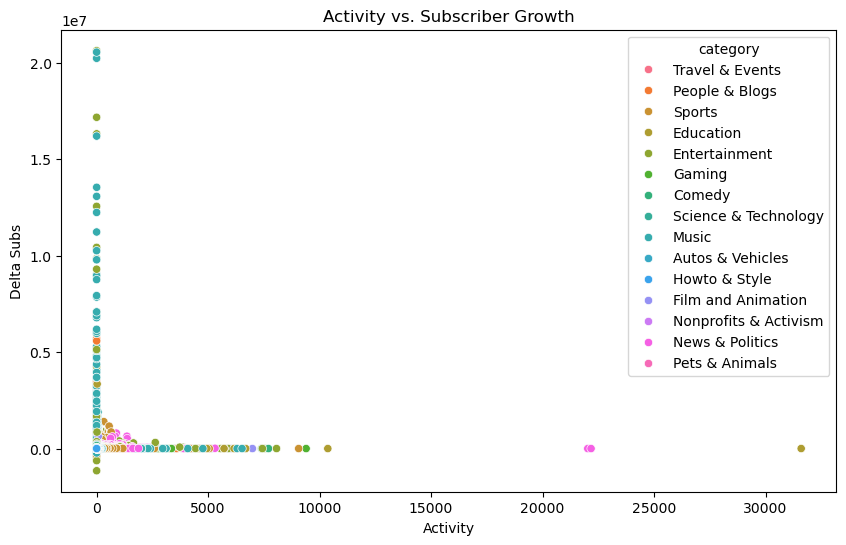

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_with_rgr, x='activity', y='delta_subs', hue='category')
plt.title('Activity vs. Subscriber Growth')
plt.xlabel('Activity')
plt.ylabel('Delta Subs')
plt.show()

We can see that the activity seem to be positively related to the subscriber growth, but this relation depends on the channel category: it is the strongest for `Gaming` channels, when the growth of `Howto & Style` or `Education` channels doesn't seem to be related to the activity of the channels.

### B. Subscribers Analysis

#### 1. Subscribers plot for each channel

In [31]:
df_with_rgr.index.get_level_values('channel').unique()

Index(['UC--24Q3_ZQeFmgJE-Um5QZQ', 'UC--2EbuIuBOGgGqPiJxi3rg',
       'UC--3c8RqSfAqYBdDjIG3UNA', 'UC--3ozenTzry39-xMqAPQlw',
       'UC--6E6EpybocdaNlPhvK_9A', 'UC--70ql_IxJmhmqXqrkJrWQ',
       'UC--7oyGW0N7fMf164-ZXljQ', 'UC--94OGFAzYDOJb0eXgMjew',
       'UC--BMyA2X4a9PGAo3lTuopg', 'UC--EwQJeJ6SKlJdswehQH4g',
       ...
       'UCzzmGsmy8cBxmqljbVG_e7Q', 'UCzzoJY_ln_StRVdrRX1_ftg',
       'UCzzqd0yx7h1PuC3KJVqeJgw', 'UCzzsKg4jPGBL05t2w3HfHBA',
       'UCzzt-UNlRHbEFY3rEpFpuXw', 'UCzztaOtjmaZoiLvWLagq7bg',
       'UCzzyt9Z70MBX9RQAFVSNlpQ', 'UCzzzPMh9fZHxc7gxPRB2LHQ',
       'UCzzzUN8yvD2LRAnY-lhzyLQ', 'UCzzzZ3-icktxbC3j7hkWqRw'],
      dtype='object', name='channel', length=133516)

In [62]:
channel = 'UCBHu7LsKiwiYViR230RtsCA'

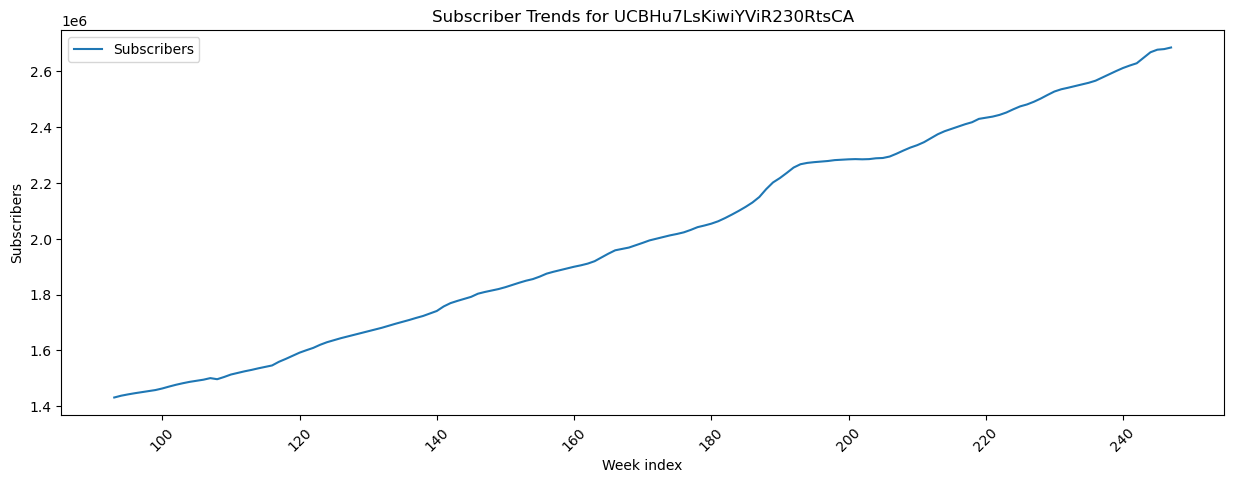

In [63]:
plot_subs_by_channel(channel, df_with_rgr)

#### 2. Rolling average analysis 

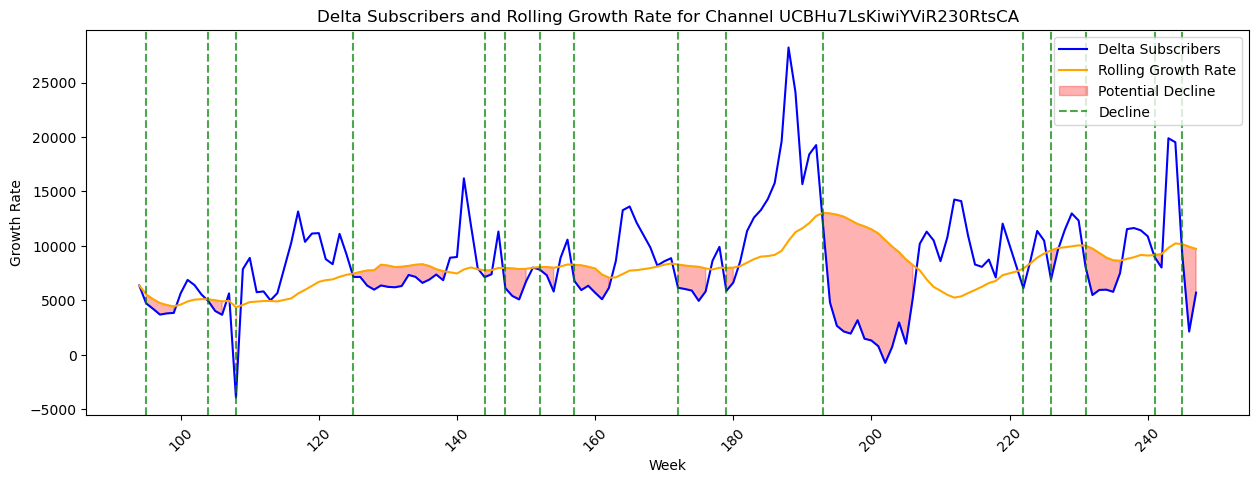

In [64]:
plot_rolling_growth_rate(channel, df_with_rgr, events)

### C. Views Analysis around Detected BB

#### 1. Delta Views Evolution In General

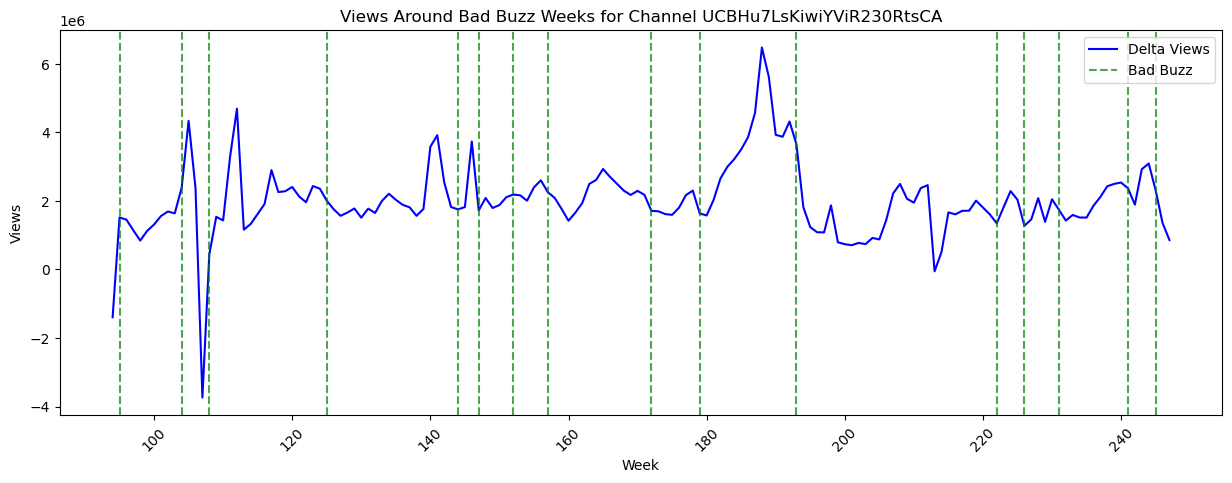

In [65]:
plot_views_around_bad_buzz(channel, df_with_rgr, events)

#### 2. Delta Views Evolution in around BB

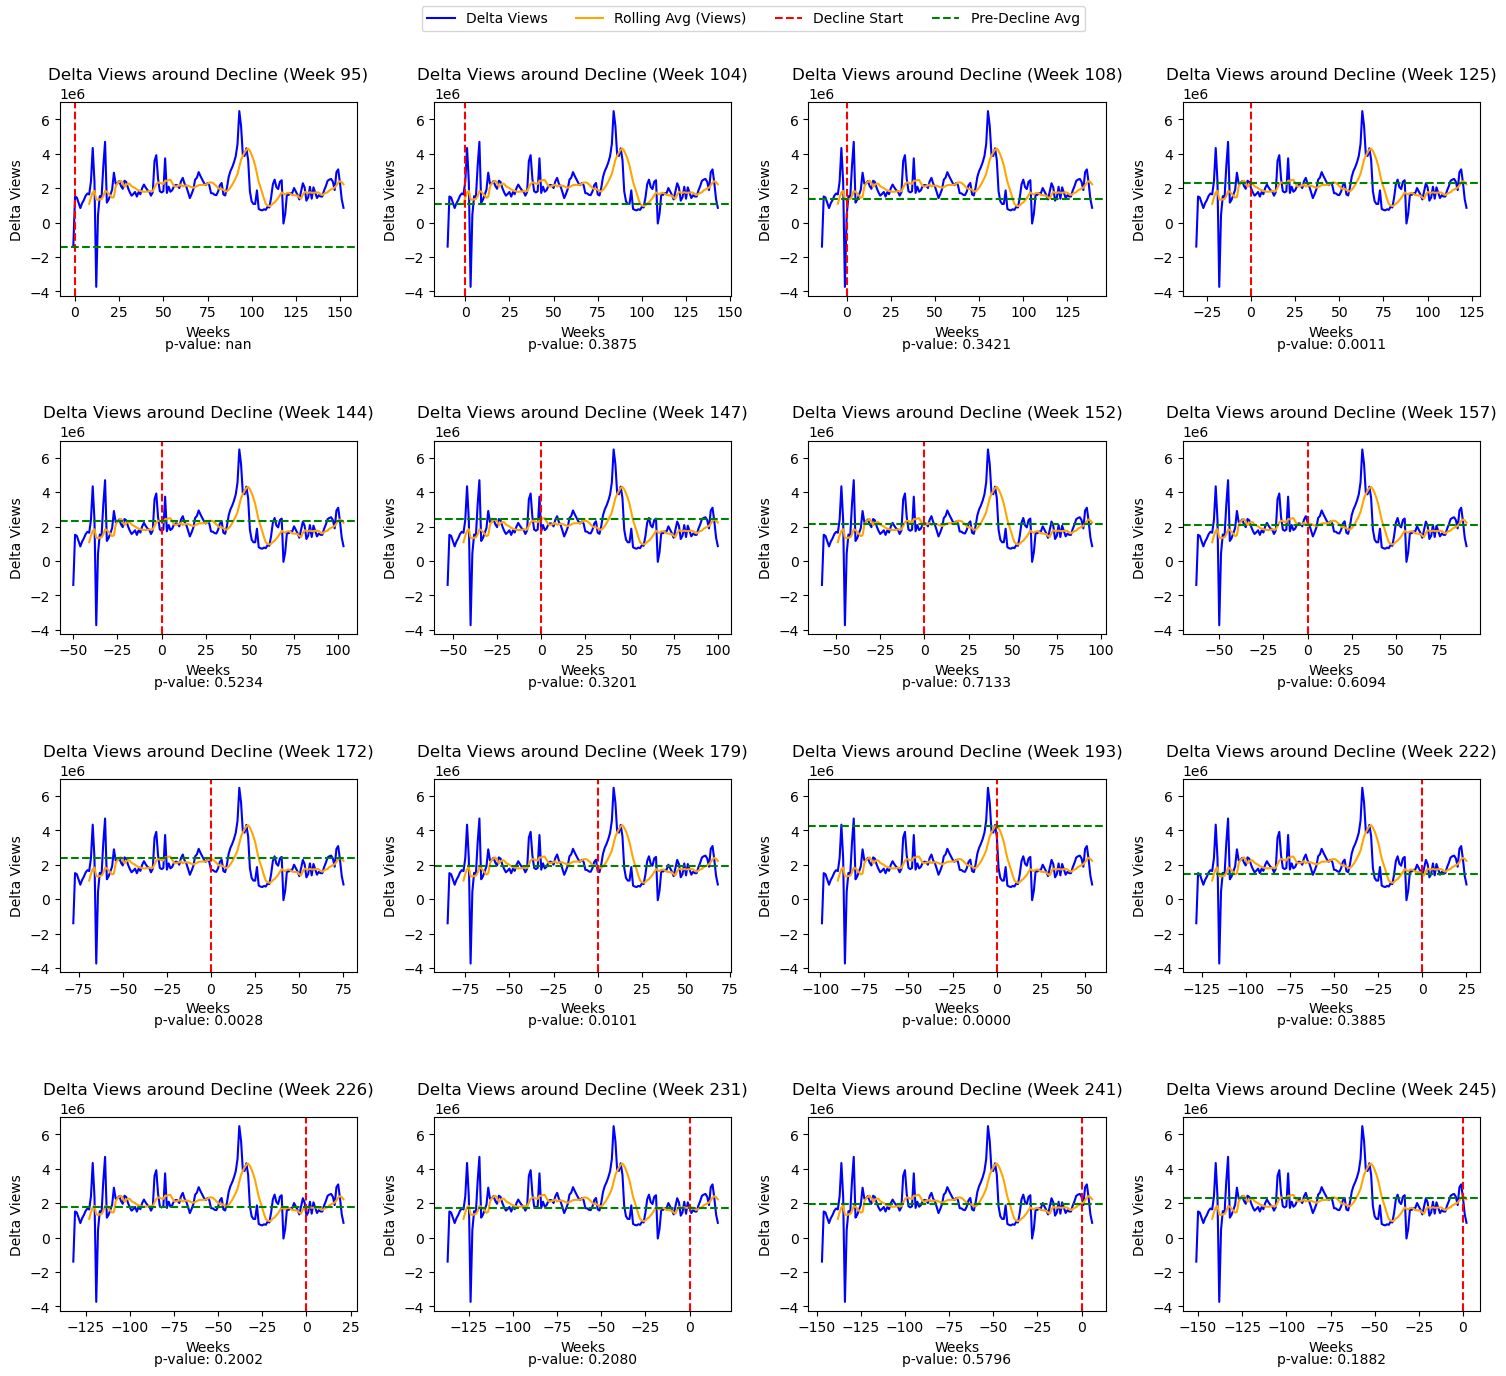

In [66]:
analyze_views_around_bad_buzz(channel, df_with_rgr, events)

### D. Likes/Dislikes Analysis

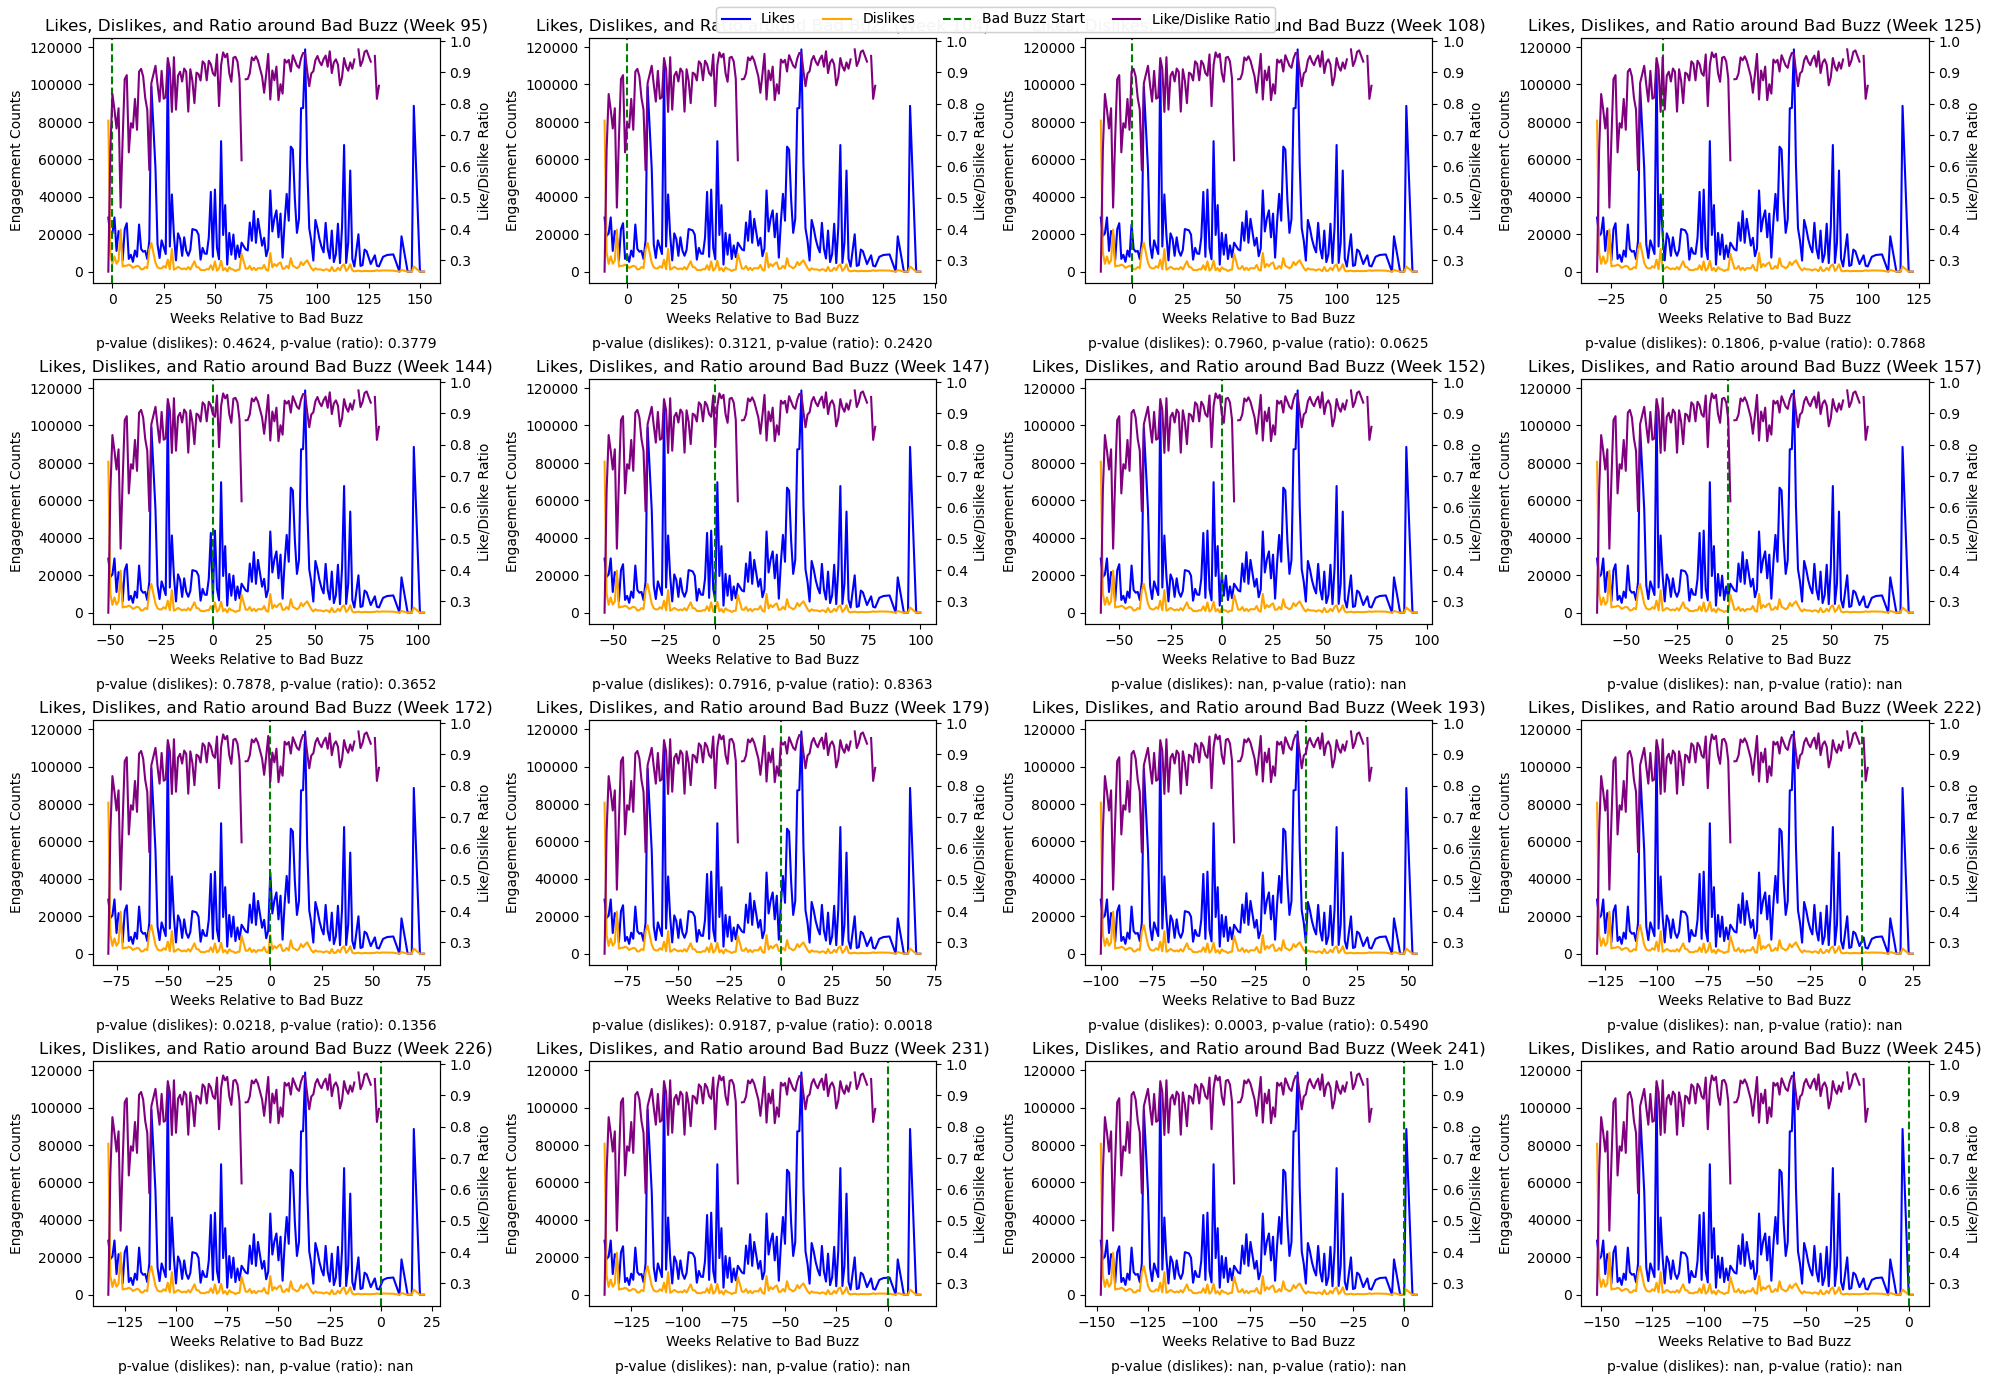

In [67]:
analyze_engagement_around_bad_buzz(channel, df_with_rgr, events)

### E. Activity Analysis

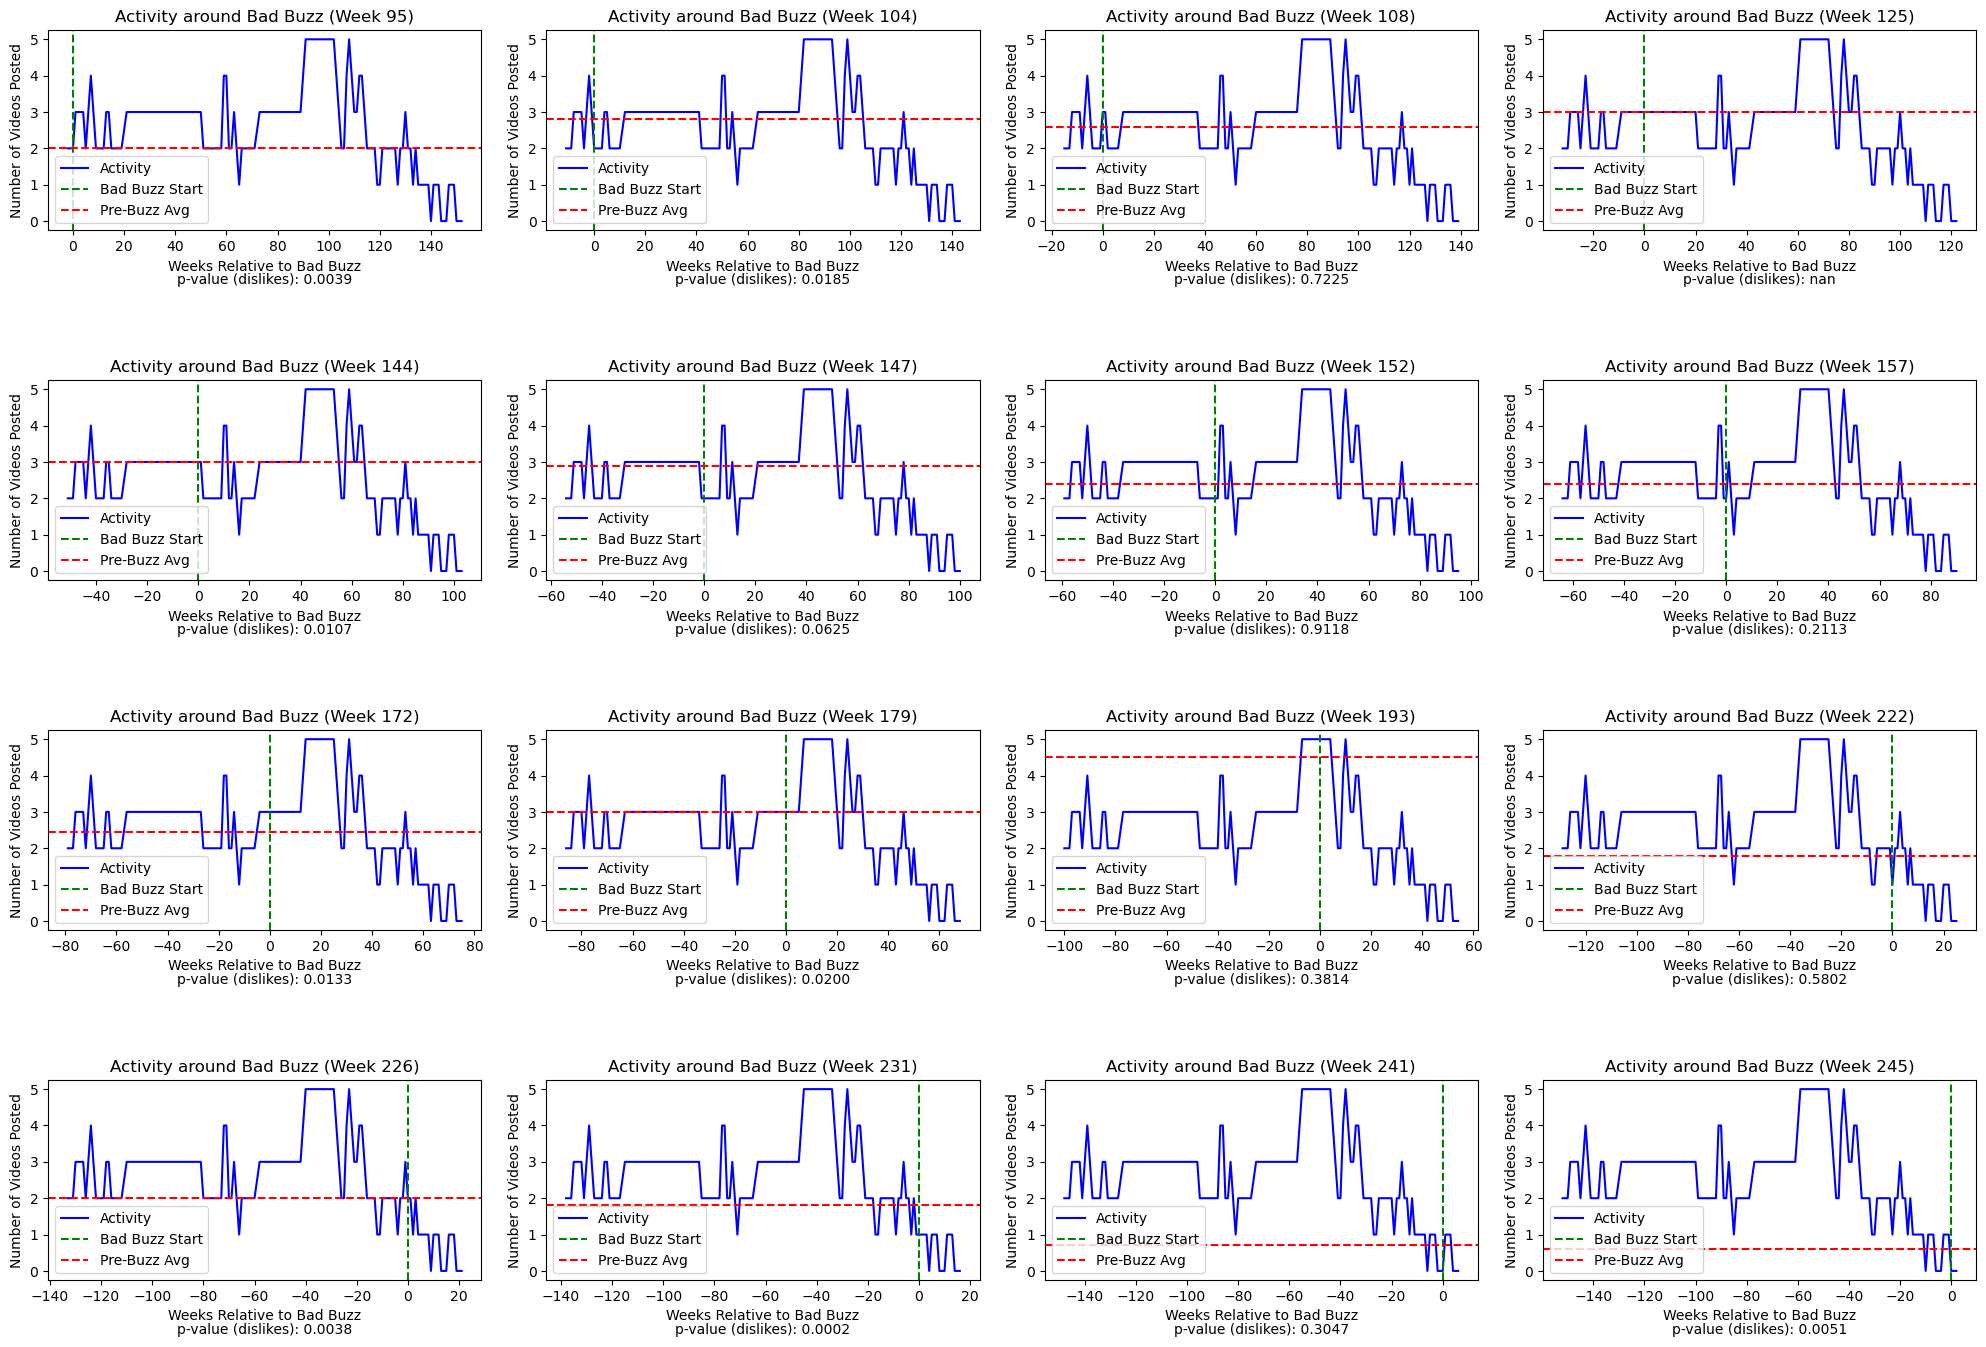

In [68]:
analyze_activity_around_bad_buzz(channel, df_with_rgr, events)

# Making the decline detection better

Building on top of our findings in milestone 2, we find a technique to better detect declines.

## Compute rolling growth rate

Compute the rolling growth rate and store it to file if it doesn't exist.

/!\ Note: Running the following cell is very time-consuming and requires around 16GB of memory. Run it only if you don't have the file `df_with_rgr.csv` in the `data` folder.

In [ ]:
compute_rolling_growth_rate()

## Detect declines

We now create the final dataset that we will use through this study, with a specific method for detecting declines by filterning them on the rolling growth rate percentage (intensity of the decline) and the duration of the decline:

Starting decline events dataset creation: 

Loading data from data/df_with_rgr_new.tsv ...
Data loaded. 

Total number of channels: 133516 

Detecting decline events ...


Processing channels: 100%|██████████| 133516/133516 [03:52<00:00, 574.01it/s]



Initial decline events detected. 



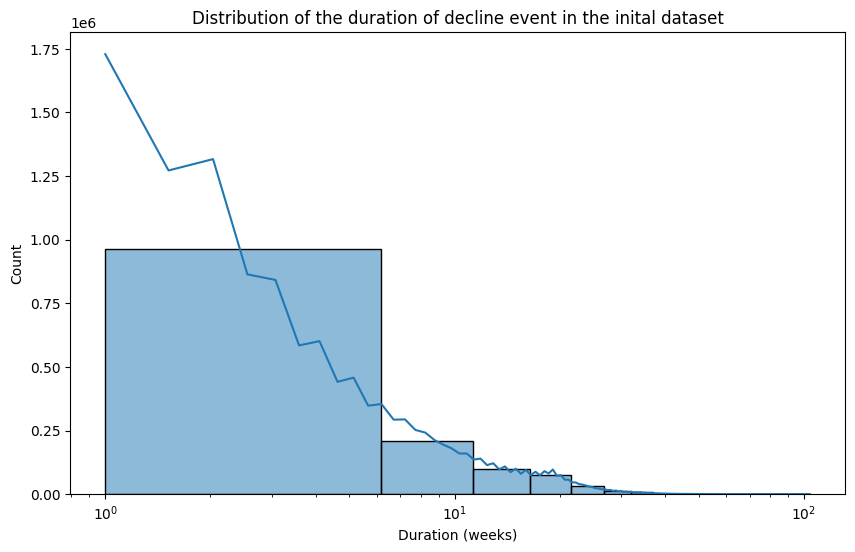

We detect way too many decline events, so we need to find a way to filter them.
We therefore set a threshold of 8 weeks for the minimum duration of a decline event. 

Filtering decline events with minimum duration of 8 weeks ...
Decline events filtered. 



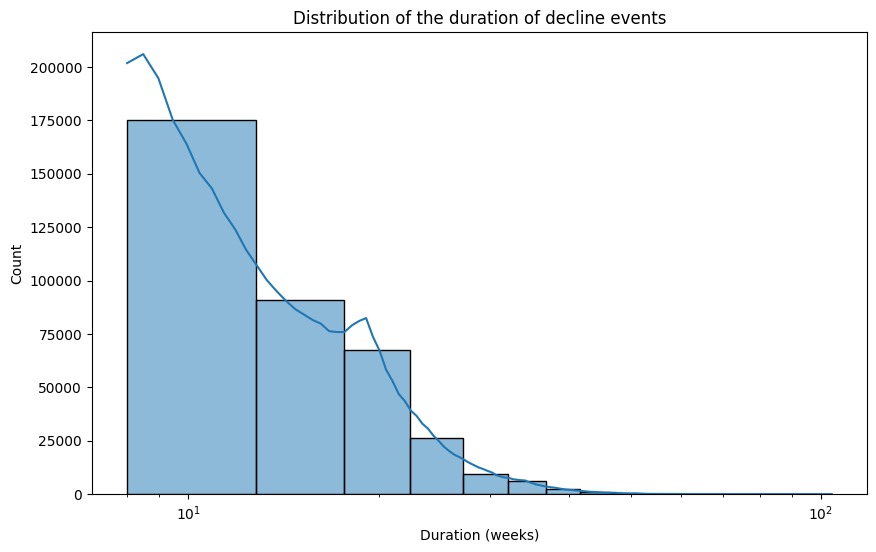


After filtering:
    Mean duration of decline events: 14.96952570075613
    Median duration of decline events: 13.0
    Min duration of decline events: 8
    Max duration of decline events: 104 

Filtering decline events with minimum growth difference percentage of -80 ...


Processing channels: 100%|██████████| 133516/133516 [01:11<00:00, 1879.93it/s]


Decline events filtered. 

Filtering decline events with minimum duration of 8 weeks ...
Decline events filtered. 

There are 121998 decline events (based on growth rate) with duration of at least 8 weeks. 

Number of channels with decline events detected after filtering: 65110 

Saving data to data/decline_events_complete.csv ...
Data saved. 

Decline events saved to data/decline_events_complete.csv 

Creating dataset for 1M Plus dataset (only channels in detected decline events) with more than 1M subscribers ...
1M Plus dataset created and saved to data/1M_plus_from_declined_events.csv 

Decline events dataset creation completed.


In [2]:
df_init_rgr_pct, df_init_rgr_pct_grouped, decline_events_final_sorted = create_decline_events_datasets()

## Explaination of the advantage of the filtered dataset

To illustrate the advantage of the filtered dataset, we will compare the results of the decline detection on the filtered dataset with the results of the decline detection on the original dataset for a well known youtuber with famous bad buzz that resulted in declines: Lance Stewart.

In [3]:
# Lance stewart channel ID
LANCE_STEWART  =  'UC6-NBhOCP8DJqnpZE4TNE-A'

Before applying filters to correctly detect decline, every red area in the following graph was a decline event:

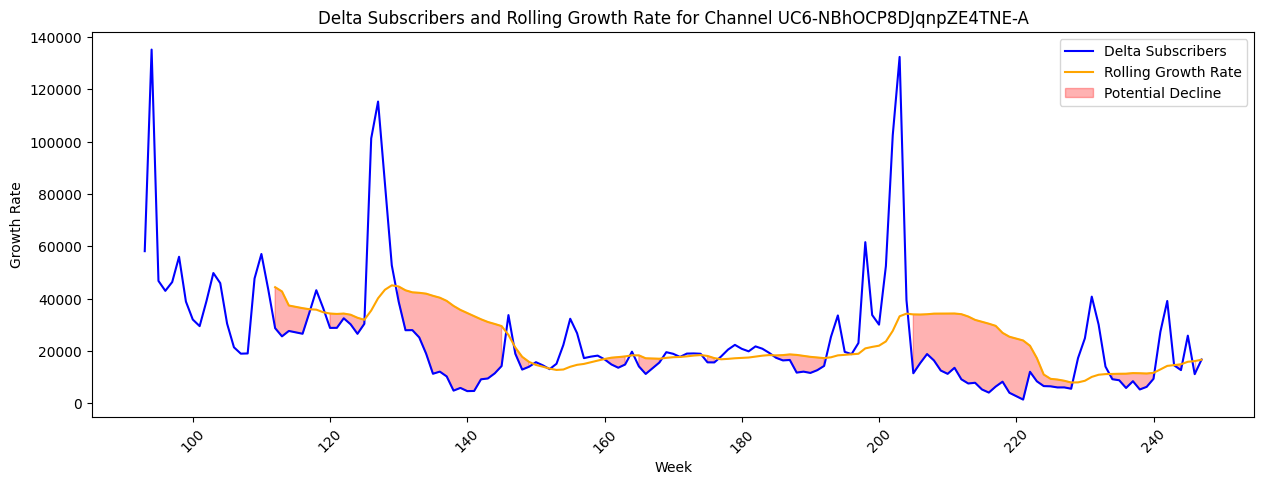

In [4]:
plot_rolling_growth_rate2(LANCE_STEWART, df_init_rgr_pct)

That detection was not very meaningful, as it detected a lot of small declines that were not significant and not correlated to real known decline periods of this youtuber's channel.

The filters applied to the dataset are the following:
- The rolling growth rate percentage must be below -80% (high intensity of the decline)
- The duration of the decline must be at least 8 weeks

After applying the filters, we obtain less decline events, but only the meaningful ones (shown in purple in the following graph):

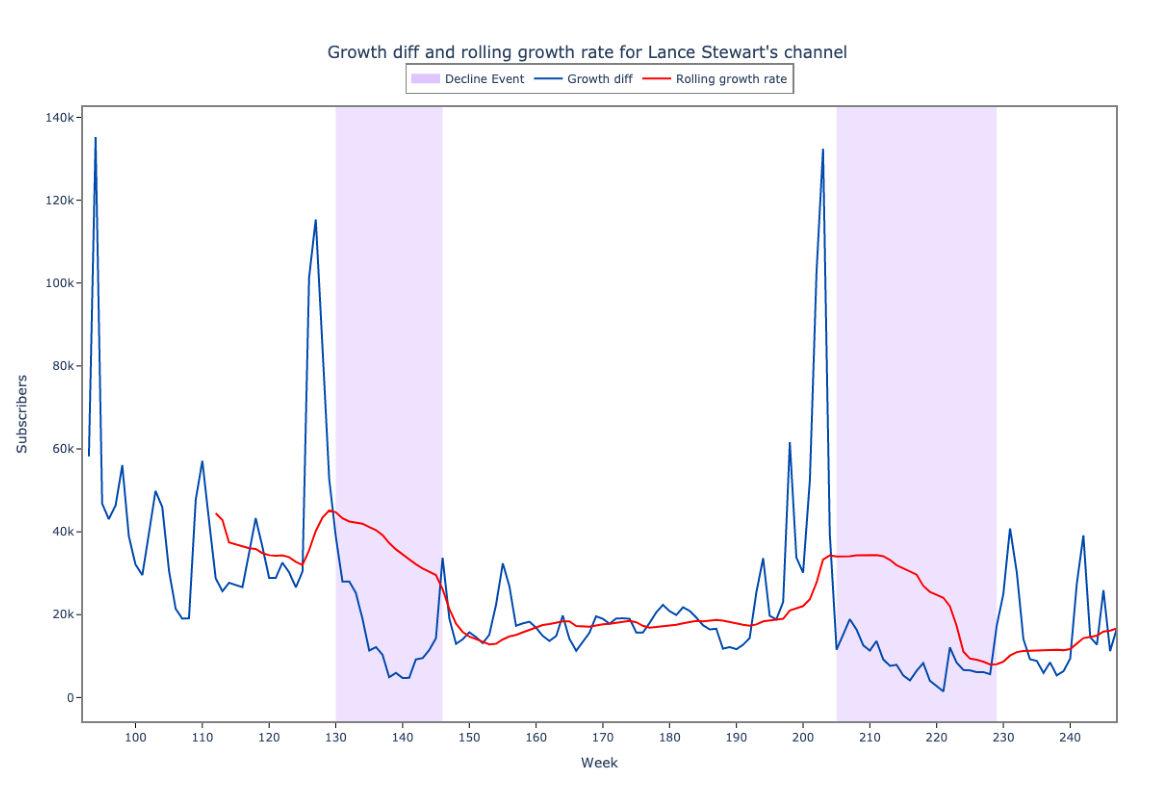

In [14]:
plot_new_detection(df_init_rgr_pct_grouped, decline_events_final_sorted, LANCE_STEWART)

## Finding and isolating the videos posted close to the declines

In [ ]:
# Define the paths 
METADATA_FILENAME = 'data/yt_metadata_en.jsonl'
TO_FILE = 'data/videos_around_declines.csv'

# Load the decline events
decline_events = pd.read_csv('data/sampled_decline_events.csv')

# Extract the videos around the decline events and save them in TO_FILE
extract_videos_around_declines(decline_events, METADATA_FILENAME, TO_FILE)

Chunk 0 (lines 0 to 5000): 13/5000 videos kept
Chunk 1 (lines 5000 to 10000): 77/5000 videos kept
Chunk 2 (lines 10000 to 15000): 526/5000 videos kept
Chunk 3 (lines 15000 to 20000): 66/5000 videos kept
Chunk 4 (lines 20000 to 25000): 117/5000 videos kept
Chunk 5 (lines 25000 to 30000): 5/5000 videos kept
Chunk 6 (lines 30000 to 35000): 237/5000 videos kept
Chunk 7 (lines 35000 to 40000): 51/5000 videos kept
Chunk 8 (lines 40000 to 45000): 470/5000 videos kept
Chunk 9 (lines 45000 to 50000): 1/5000 videos kept
Chunk 10 (lines 50000 to 55000): 59/5000 videos kept
Chunk 11 (lines 55000 to 60000): 0/5000 videos kept
Chunk 12 (lines 60000 to 65000): 16/5000 videos kept
Chunk 13 (lines 65000 to 70000): 0/5000 videos kept
Chunk 14 (lines 70000 to 75000): 20/5000 videos kept
Chunk 15 (lines 75000 to 80000): 60/5000 videos kept
Chunk 16 (lines 80000 to 85000): 34/5000 videos kept
Chunk 17 (lines 85000 to 90000): 0/5000 videos kept
Chunk 18 (lines 90000 to 95000): 0/5000 videos kept
Chunk 19 (l

In [191]:
# print the length of METADATA_FILENAME
with open(METADATA_FILENAME) as f:
    print(f'Length of {METADATA_FILENAME}: {sum(1 for _ in f)}')

Length of data/yt_metadata_en.jsonl: 72924794


This matches the cell above. In total, around 1.9 million are extracted.

In [4]:
extracted_videos = pd.read_csv(TO_FILE)

nb_videos = extracted_videos.groupby('channel').size()

print(f'Number of channels without videos: {len(nb_videos[nb_videos == 0])}')

Number of channels without videos: 0


This is a success, we found videos for all the channels.

# Apply LDA to annotate the videos before and after the start of declines with categories

### Load and preprocess the whole dataset

In [6]:
decline_events, videos = load_data()
print(videos)
decline_events = process_data(decline_events)

                          channel  week  \
0        UCzWm1-4XF7AHxVUTkHCM1uw   227   
1        UCzWm1-4XF7AHxVUTkHCM1uw   226   
2        UCzWm1-4XF7AHxVUTkHCM1uw   224   
3        UCzWm1-4XF7AHxVUTkHCM1uw   224   
4        UCzWm1-4XF7AHxVUTkHCM1uw   223   
...                           ...   ...   
1905541  UCrwE8kVqtIUVUzKui2WVpuQ   109   
1905542  UCrwE8kVqtIUVUzKui2WVpuQ   109   
1905543  UCrwE8kVqtIUVUzKui2WVpuQ   109   
1905544  UCrwE8kVqtIUVUzKui2WVpuQ   109   
1905545  UCrwE8kVqtIUVUzKui2WVpuQ   109   

                                                      tags  duration  
0        video,games,retrogamer3,ed,findlay,Scam,Steam,...       384  
1        video,games,retrogamer3,ed,findlay,Trump,Ameri...       270  
2        video,games,retrogamer3,ed,findlay,America's R...       109  
3                               MTG Arena War of the Spark      5154  
4        video,games,retrogamer3,ed,findlay,Mpow,Headph...       475  
...                                                    ..

In [7]:


df_tags = create_tags_dataframe(decline_events, videos)

print(df_tags)

print("Tokenizing and lemmatizing tags")
df_tags['Tokens'] = None
for index, row in tqdm(df_tags.iterrows(), total=df_tags.shape[0]):
    df_tags.at[index, 'Tokens'] = preprocess_str(row['Tags_combined'])


                                                    Tags_combined
Decline Source                                                   
0       After   MsRosieBea,uni,uni life,first year of uni,thir...
        Before  MsRosieBea,red lip,get ready with me\nMsRosieB...
1       After   hollow,generationhollow,the surge,surge,robo s...
        Before  hollow,generationhollow,paragon,gameplay,alpha...
2       After                                                None
...                                                           ...
36595   Before  Despacito accordion cover,Fonsi Despacito acco...
36597   After   #patriotattitude,#whenhellfreezesover,Keith Fe...
        Before  Audi,Audi 2.1,Line Bore,Kenax,Line bore Kenax ...
36598   After   Music,beats,instrumental,right beat radio,mell...
        Before  Music,beats,instrumental,right beat radio,mell...

[61194 rows x 1 columns]
Tokenizing and lemmatizing tags


100%|██████████| 61194/61194 [03:13<00:00, 316.42it/s]


### Train the LDA model to get the topics

In [8]:
# Create a dictionary and a corpus for the LDA model
print("Creating dictionary and corpus")
dictionary, corpus = create_dictionary_and_corpus(df_tags) 

print("Training LDA model")
lda = ldamodel.LdaModel(corpus, num_topics=20, id2word=dictionary, passes=15)

topics = lda.print_topics(num_words=15)
for topic in topics:
    print(topic)

Creating dictionary and corpus
Training LDA model
(0, '0.033*"makeup" + 0.019*"haul" + 0.015*"hair" + 0.013*"beauty" + 0.011*"fashion" + 0.010*"tutorial" + 0.009*"day" + 0.008*"recipe" + 0.008*"food" + 0.007*"review" + 0.007*"style" + 0.007*"routine" + 0.006*"home" + 0.006*"vegan" + 0.006*"tip"')
(1, '0.025*"funny" + 0.023*"family" + 0.022*"vlog" + 0.020*"video" + 0.012*"prank" + 0.011*"vlogs" + 0.010*"life" + 0.010*"challenge" + 0.009*"girl" + 0.009*"daily" + 0.009*"comedy" + 0.009*"youtube" + 0.007*"baby" + 0.007*"reaction" + 0.006*"vlogger"')
(2, '0.050*"music" + 0.042*"beat" + 0.030*"type" + 0.018*"dance" + 0.016*"free" + 0.015*"trap" + 0.015*"song" + 0.013*"2018" + 0.012*"cover" + 0.012*"rap" + 0.010*"remix" + 0.010*"hop" + 0.010*"new" + 0.009*"hip" + 0.009*"lyric"')
(3, '0.061*"game" + 0.030*"gameplay" + 0.026*"play" + 0.021*"let" + 0.019*"minecraft" + 0.018*"\'s" + 0.013*"gaming" + 0.012*"walkthrough" + 0.011*"mod" + 0.010*"part" + 0.010*"pc" + 0.009*"video" + 0.009*"ark" + 0.00

In [9]:
# Save the topics

topics = lda.print_topics(num_words=15)

# Create a DataFrame from the topics
topics_data = []
for topic_id, topic in topics:
    topics_data.append({"Topic": topic_id, "Words": topic})

topics_df = pd.DataFrame(topics_data)

topics_df.to_csv("data/lda_topics.csv", index=False)
print("Topics saved to lda_topics.csv")

Topics saved to lda_topics.csv


### Assign the topics to the videos before and after

In [10]:
df_tags['Dominant_Topic'], df_tags['Topic_Probability'] = zip(
    *df_tags['Tokens'].apply(lambda tokens: assign_dominant_topic(tokens, lda, dictionary))
)

print(df_tags.head(5))
df_tags.to_csv('data/df_small_sample.csv', index=False)

                                                    Tags_combined  \
Decline Source                                                      
0       After   MsRosieBea,uni,uni life,first year of uni,thir...   
        Before  MsRosieBea,red lip,get ready with me\nMsRosieB...   
1       After   hollow,generationhollow,the surge,surge,robo s...   
        Before  hollow,generationhollow,paragon,gameplay,alpha...   
2       After                                                None   

                                                           Tokens  \
Decline Source                                                      
0       After   [msrosiebea, uni, uni, life, first, year, uni,...   
        Before  [msrosiebea, red, lip, get, ready, me\nmsrosie...   
1       After   [hollow, generationhollow, surge, surge, robo,...   
        Before  [hollow, generationhollow, paragon, gameplay, ...   
2       After                                                  []   

                Dominant_Topic  

In [11]:
coherence_lda = calculate_coherence(lda, df_tags, dictionary)
print(f'Coherence Score: {coherence_lda}')
# whole df: 0.6525 with 55 topics, 0.5991 with 50, 

Coherence Score: 0.5815071105454963


# Use Mistral through Ollama to name the categories

### Load data

In [6]:
LDA_topics = pd.read_csv('data/lda_topics.csv')

LDA_topics

Topic                                              Words
0       0  0.057*"beat" + 0.041*"type" + 0.036*"nintendo"...
1       1  0.049*"minecraft" + 0.039*"dota" + 0.034*"blac...
2       2  0.094*"fifa" + 0.075*"18" + 0.067*"19" + 0.045...
3       3  0.016*"news" + 0.015*"trump" + 0.009*"house" +...
4       4  0.067*"gta" + 0.055*"5" + 0.046*"online" + 0.0...
5       5  0.042*"art" + 0.033*"2017" + 0.029*"tarot" + 0...
6       6  0.045*"funny" + 0.023*"video" + 0.023*"roblox"...
7       7  0.025*"vlog" + 0.025*"makeup" + 0.014*"haul" +...
8       8  0.022*"design" + 0.016*"make" + 0.014*"bitcoin...
9       9  0.134*"fortnite" + 0.037*"battle" + 0.036*"roy...
10     10  0.058*"v" + 0.045*"wwe" + 0.024*"sport" + 0.01...
11     11  0.013*"movie" + 0.013*"review" + 0.013*"season...
12     12  0.083*"news" + 0.026*"video" + 0.024*"movie" +...
13     13  0.030*"league" + 0.023*"legend" + 0.020*"lol" ...
14     14  0.056*"nba" + 0.042*"madden" + 0.022*"basketba...
15     15  0.070*"music" + 0.044*"reaction" + 0.041*"song...
16     16  0.064*"2" + 0.031*"destiny" + 0.019*"clash" + ...
17     17  0.066*"pokemon" + 0.025*"android" + 0.019*"mob...
18     18  0.058*"kid" + 0.038*"family" + 0.033*"toy" + 0...
19     19  0.070*"game" + 0.039*"gameplay" + 0.027*"play"...

## Generate topics name using LLM

In [10]:
# Create a dictionary of LDA topics where 'Topic' column is the key and the answer from the llm is the value

LLM_topics = dict()

for i in tqdm(range(len(LDA_topics))):
    tokens_distrib = LDA_topics['Words'][i]
    llm_topic = generate_topic_name(tokens_distrib)

    # Output treatment
    llm_topic = re.sub(r'\([^)]*\)', '', llm_topic) # Delete parenthesis and content
    # If ',' or '/', then suppress everything after
    llm_topic = re.sub(r'[,/].*', '', llm_topic)

    print(llm_topic)
    LLM_topics[i] = llm_topic


print(LLM_topics)

  5%|▌         | 1/20 [00:04<01:26,  4.58s/it]

 Nintendo Switch Games 


 10%|█         | 2/20 [00:06<00:49,  2.74s/it]

 Gaming & Multiplayer Games


 15%|█▌        | 3/20 [00:07<00:37,  2.20s/it]

 Football Games 


 20%|██        | 4/20 [00:09<00:30,  1.92s/it]

 Politics


 25%|██▌       | 5/20 [00:10<00:26,  1.75s/it]

 GTA V Gameplay


 30%|███       | 6/20 [00:12<00:24,  1.73s/it]

 Art and Spirituality


 35%|███▌      | 7/20 [00:13<00:21,  1.68s/it]

 Funny


 40%|████      | 8/20 [00:15<00:18,  1.57s/it]

 Beauty & Lifestyle Vlog


 45%|████▌     | 9/20 [00:16<00:17,  1.59s/it]

 Design & DIY


 50%|█████     | 10/20 [00:18<00:15,  1.52s/it]

 Fortnite Gameplay


 55%|█████▌    | 11/20 [00:19<00:13,  1.48s/it]

 WWE Sports


 60%|██████    | 12/20 [00:20<00:11,  1.47s/it]

 Movie Reviews


 65%|██████▌   | 13/20 [00:23<00:12,  1.75s/it]

 News


 70%|███████   | 14/20 [00:24<00:10,  1.71s/it]

 League of Legends


 75%|███████▌  | 15/20 [00:26<00:08,  1.76s/it]

 Video Game Sports 


 80%|████████  | 16/20 [00:28<00:06,  1.65s/it]

 Music Reactions


 85%|████████▌ | 17/20 [00:29<00:04,  1.63s/it]

 Video Game Guides


 90%|█████████ | 18/20 [00:31<00:03,  1.59s/it]

 Pokemon


 95%|█████████▌| 19/20 [00:32<00:01,  1.59s/it]

 Kids


100%|██████████| 20/20 [00:34<00:00,  1.72s/it]

 Gameplay
{0: ' Nintendo Switch Games ', 1: ' Gaming & Multiplayer Games', 2: ' Football Games ', 3: ' Politics', 4: ' GTA V Gameplay', 5: ' Art and Spirituality', 6: ' Funny', 7: ' Beauty & Lifestyle Vlog', 8: ' Design & DIY', 9: ' Fortnite Gameplay', 10: ' WWE Sports', 11: ' Movie Reviews', 12: ' News', 13: ' League of Legends', 14: ' Video Game Sports ', 15: ' Music Reactions', 16: ' Video Game Guides', 17: ' Pokemon', 18: ' Kids', 19: ' Gameplay'}


### Save the data

In [11]:
# Save the dictionary
with open('data/LLM_topics.json', 'w') as f:
    json.dump(LLM_topics, f)

# Analyzing the reactions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data

In [44]:
df_all_declines_original = pd.read_csv('data/decline_events_complete.csv')
df_channels = pd.read_csv('data/df_channels_en.tsv', sep='\t', usecols=['channel', 'category_cc'], index_col='channel')
df_data_processed = load_processed_data(usecols=['channel', 'week', 'subs', 'activity', 'views'])

In [45]:
df_all_declines_original.head()

Channel       Event  Duration
0  UCPk25sO9EtHzqXviZW5LBpQ  (179, 197)        18
1  UCZznzvMegTgP2JrmtHiS9kw  (232, 243)        11
2  UCWRSxAg6mGyA0fBy_jZpXtA  (104, 113)         9
3  UCWRSxAg6mGyA0fBy_jZpXtA  (147, 161)        14
4  UCNn10lT7ZSZ4xteXwBnBd0Q  (142, 160)        18

## Finding the outcome

Using the duration of the decline, determine whether the YouTuber recovered or not.

In [46]:
df_all_declines = add_declines_to_db(df_all_declines_original, df_channels, df_data_processed)
print(f"Overall recovery rate: {df_all_declines['Recovered'].mean():.2f}")
df_all_declines.head()

Overall recovery rate: 0.46


Channel  Duration  Recovered  Start  End  \
0  UCPk25sO9EtHzqXviZW5LBpQ        18      False    179  197   
1  UCZznzvMegTgP2JrmtHiS9kw        11       True    232  243   
2  UCWRSxAg6mGyA0fBy_jZpXtA         9       True    104  113   
3  UCWRSxAg6mGyA0fBy_jZpXtA        14       True    147  161   
4  UCNn10lT7ZSZ4xteXwBnBd0Q        18      False    142  160   

             Category    Subs_start  Activity_start   Views_start  
0              Gaming  14994.000000               0  2.189041e+06  
1       Entertainment  18171.812500               2  2.893702e+06  
2  Film and Animation  14325.927083               0  1.771014e+07  
3  Film and Animation  15238.354167               1  1.901395e+07  
4       Entertainment  42248.000000               0  2.941865e+06

## How is the recovery distributed?

To get a first idea of what factors come into play when a YouTuber tries to recover from a decline, we plot some distributions.

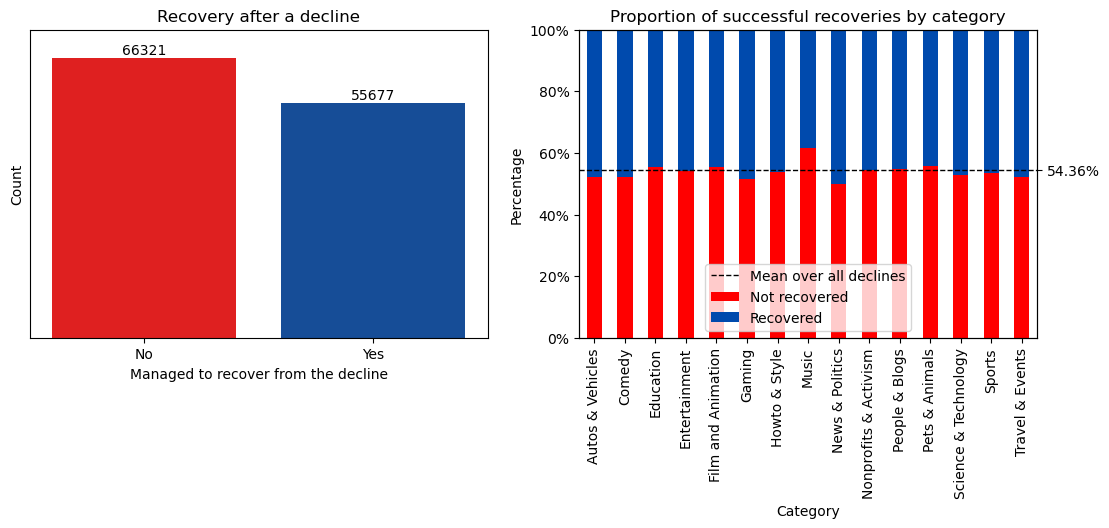

In [47]:
plot_recovered_by_categories(df_all_declines)

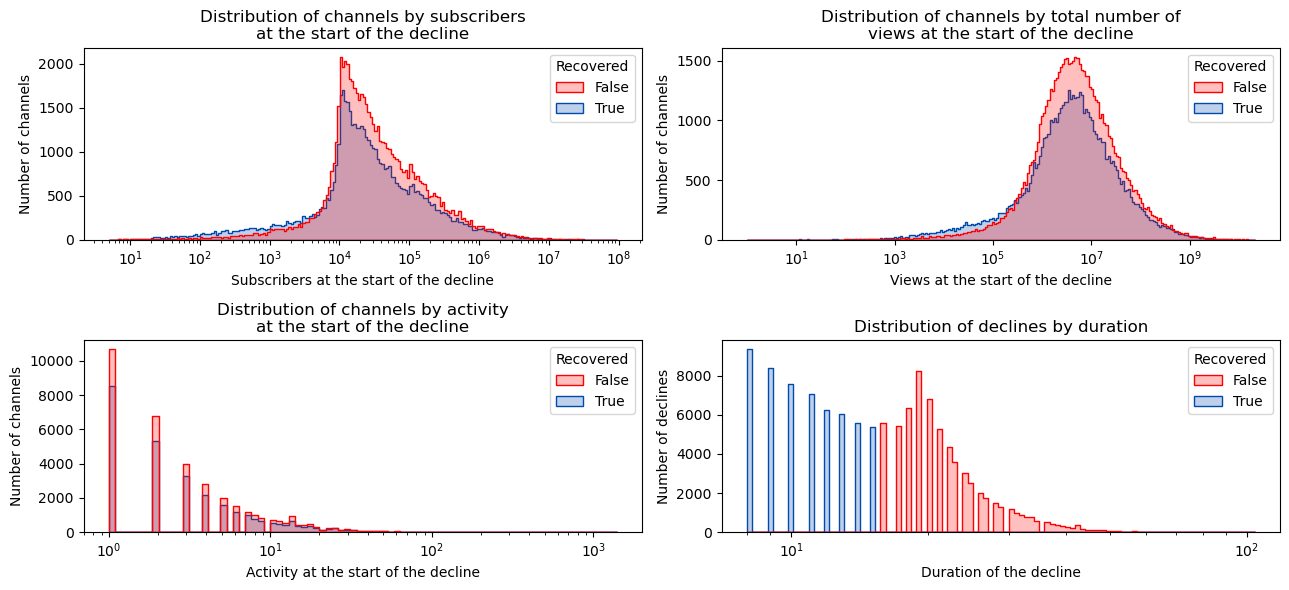

In [48]:
plot_group_distributions(df_all_declines)

We can observe that some features are not balanced between the declines that recovered and those that did not, especially views and subscribers at the start of the decline.

In [49]:
print(df_all_declines['Recovered'].value_counts())
print(f"\nTotal number of declines: {len(df_all_declines)}")

Recovered
False    66321
True     55677
Name: count, dtype: int64

Total number of declines: 121998


## YouTuber reactions

Aiming at finding the best ways to deal with a decline depending on the situation, we take a look at how the YouTubers reacted to the decline, and what methods proved effective.\
In order to observe the reaction's impact, we will conduct a matched observational study on the dataset by using propensity score matching.

Considering the size of the dataset, we use random sampling to ease the matching's computation.\
To check that sampling does not mess with the distribution of recoveries, we plot them depending on the sampling proportion.

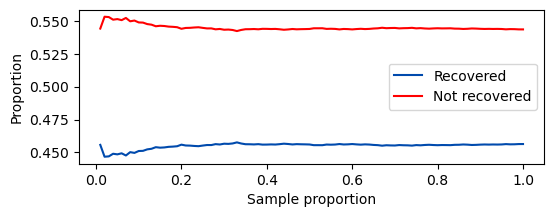

In [50]:
plot_sampling_rates(df_all_declines, SEED)

We choose to sample 30% of the data since it considerably reduces the size of the dataset, and allows to keep a representative sample of the data without perturbing the recovery distribution.

In [51]:
df_sampled = df_all_declines.sample(frac=0.3, replace=False, random_state=SEED)

print(df_sampled['Recovered'].value_counts())
print(f"\nTotal number of declines after sampling: {len(df_sampled)}")

# Save the data for the plots
df_sampled.to_csv('plot_data/decline_events.csv', index=False)

Recovered
False    19887
True     16712
Name: count, dtype: int64

Total number of declines after sampling: 36599


### Adding the reaction metrics whose impact we want to measure

The reactions that we are able to observe here are the following:
- Did the YouTuber change video publication frequency?
- Did the YouTuber change video length?
- Did the YouTuber change video category?

In [52]:
# Load the videos around the declines, from week (decline start - decline duration) to week (decline end)
videos_around_declines = pd.read_csv('data/videos_around_declines.csv')

# Add the declines with the indices of the corresponding videos
df_sampled = get_sampled_declines_with_videos(df_sampled, videos_around_declines)

# Augment the data with the video stats : videos per week and mean video duration, before and during the declines
df_sampled = add_video_stats(df_sampled, videos_around_declines)

DIV_BY_ZERO_TOLERANCE = 1e-6


# Calculate mean duration differences
df_sampled = calculate_difference(df_sampled, 'Mean_duration_after', 'Mean_duration_before', 'Mean_duration_difference')
df_sampled = add_change_columns(df_sampled, 'Mean_duration_difference', 'Mean_duration_before', 'Posted_longer_videos', 'Posted_shorter_videos', DIV_BY_ZERO_TOLERANCE, threshold=0.5)
print_stats(df_sampled, 'Posted_longer_videos', 'Posted_shorter_videos', 'mean video duration')

# Calculate mean frequency differences
df_sampled = calculate_difference(df_sampled, 'Videos_per_week_after', 'Videos_per_week_before', 'Mean_frequency_difference')
df_sampled = add_change_columns(df_sampled, 'Mean_frequency_difference', 'Videos_per_week_before', 'Posted_more', 'Posted_less', DIV_BY_ZERO_TOLERANCE, threshold=0.5)
print_stats(df_sampled, 'Posted_more', 'Posted_less', 'publishing frequency')

# Merge and analyze topic changes
df_sampled = merge_and_report_topic_changes(df_sampled, 'data/df_topic_change_20_15w.csv')
df_sampled = df_sampled.dropna()# Drop unnecessary columns

# Save the dataframes for later and drop unnecessary columns
df_videos_per_week = df_sampled[['Videos_per_week_before', 'Videos_per_week_after']]
df_video_duration = df_sampled[['Mean_duration_before', 'Mean_duration_after']]
df_sampled = df_sampled.drop(columns=['Mean_duration_before', 'Mean_duration_after', 'Videos_per_week_before', 'Videos_per_week_after'])

# Drop videos indices
df_sampled = df_sampled.drop(columns=['Videos_before', 'Videos_after'])


Sampled declines with videos loaded from file.

12.08% of the channels increased mean video duration after the start of the decline.
6.52% of the channels decreased mean video duration after the start of the decline.


22.65% of the channels increased publishing frequency after the start of the decline.
24.69% of the channels decreased publishing frequency after the start of the decline.

36.41% of the channels changed topic after the start of the decline.


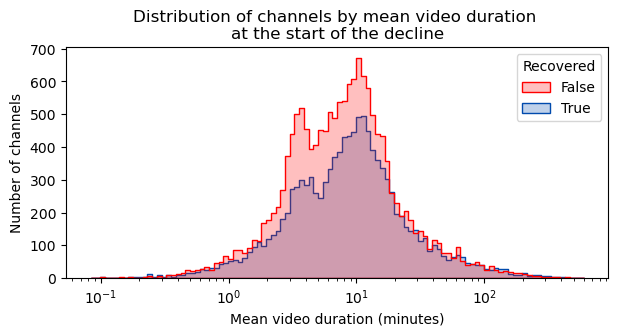

In [53]:
# Visualise mean video duration at the start of the decline as it has just been added (for the datastory)
plt.figure(figsize=(7, 3))

sns.histplot(data=df_video_duration / 60, x="Mean_duration_before", hue=df_sampled['Recovered'], log_scale=True, element="step", palette=[RED, GREEN],)
plt.title('Distribution of channels by mean video duration \nat the start of the decline')
plt.xlabel('Mean video duration (minutes)')
plt.ylabel('Number of channels')

plt.savefig('plot_data/mean_video_duration_start_decline.png', bbox_inches='tight')
plt.show()

## Our analysis

In [54]:
df_sampled.head()

Channel  Duration  Recovered  Start  End  \
0.0  UC3B6FyoLMLrUYa6i72ccPvw        20      False    189  209   
1.0  UCIHBFO-XMyTpzXAN-lg8o2g        14       True    112  126   
2.0  UC2MjZanWOfyfsrHOyitmXbQ        14       True    128  142   
3.0  UCgUtduvq2Wpc7CDHcGDmZog        15       True    188  203   
4.0  UCMn7t0wYUevjBqhK9PUGfHA        19      False    154  173   

           Category     Subs_start  Activity_start  Delta_videos  \
0.0   Howto & Style  271299.750000               3           1.0   
1.0          Gaming  135126.510417               1           0.0   
2.0          Gaming   53787.000000               5           2.0   
3.0  Pets & Animals   12262.312500               7           1.0   
4.0           Music   14582.750000               1           0.0   

      Views_start  Mean_duration_difference  Posted_longer_videos  \
0.0  1.753062e+07                419.748120                  True   
1.0  2.758465e+07               1432.453191                  True   
2.0  3.935174e+06               -177.302463                 False   
3.0  2.818956e+06               -249.533333                 False   
4.0  9.031720e+05                -38.000000                 False   

     Posted_shorter_videos  Mean_frequency_difference  Posted_more  \
0.0                  False                  -0.250000        False   
1.0                  False                  -1.214286        False   
2.0                  False                   0.428571        False   
3.0                  False                  -0.600000        False   
4.0                  False                  -0.210526        False   

     Posted_less Topic_change  
0.0        False        False  
1.0        False        False  
2.0        False        False  
3.0        False        False  
4.0         True        False

### Summary Statistics 

In [55]:
df_sampled.describe()

Duration         Start           End    Subs_start  Activity_start  \
count  26935.000000  26935.000000  26935.000000  2.693500e+04    26935.000000   
mean      17.871357    172.006980    189.878337  1.655763e+05        4.537628   
std        7.771222     39.111496     39.522963  7.598811e+05       14.721962   
min        8.000000     67.000000     80.000000  7.000000e+00        0.000000   
25%       12.000000    141.000000    158.000000  1.190941e+04        0.000000   
50%       17.000000    177.000000    197.000000  2.556035e+04        2.000000   
75%       22.000000    203.000000    222.000000  8.487342e+04        4.000000   
max       97.000000    239.000000    247.000000  2.833122e+07     1391.000000   

       Delta_videos   Views_start  Mean_duration_difference  \
count  26935.000000  2.693500e+04              26935.000000   
mean       1.948728  3.806526e+07                  3.541893   
std        8.909652  2.660578e+08               1040.367686   
min        0.000000  2.405000e+02             -35228.000000   
25%        0.000000  1.432966e+06                -93.821078   
50%        1.000000  4.483128e+06                  2.810025   
75%        2.000000  1.561427e+07                113.537140   
max     1145.000000  1.463010e+10              26581.333333   

       Mean_frequency_difference  
count               26935.000000  
mean                   -0.230678  
std                     3.844360  
min                  -237.000000  
25%                    -0.517241  
50%                    -0.083333  
75%                     0.214286  
max                   170.125000

### Correlation Analysis

In [57]:
# Transform the categorical variable into dummies
df_correlation = df_sampled[['Recovered', 'Posted_more', 'Posted_less', 'Posted_longer_videos', 'Posted_shorter_videos', 'Topic_change']].copy()

for col in df_correlation.columns:
    df_correlation[col] = df_correlation[col].astype(int)

# Calculate the correlation matrix
correlation_matrix = df_correlation.corr()
# Display the correlation matrix
print(correlation_matrix['Recovered'].sort_values(ascending=False))

# Save the correlation matrix as a CSV file for the plots
correlation_matrix.to_csv('plot_data/correlation_matrix.csv')

Recovered                1.000000
Posted_more              0.066548
Posted_longer_videos    -0.001292
Posted_shorter_videos   -0.001773
Topic_change            -0.014018
Posted_less             -0.143425
Name: Recovered, dtype: float64


**Summary**:

* **Positive Correlations** : Posting more videos (higher upload frequency) is slightly associated with recovery.

* **Negative Correlations** : Posting fewer videos are more strongly associated with lower chances of recovery.

* **No Correlations** : Other factors are nearly not correlated with recovery.

### Visual Analysis

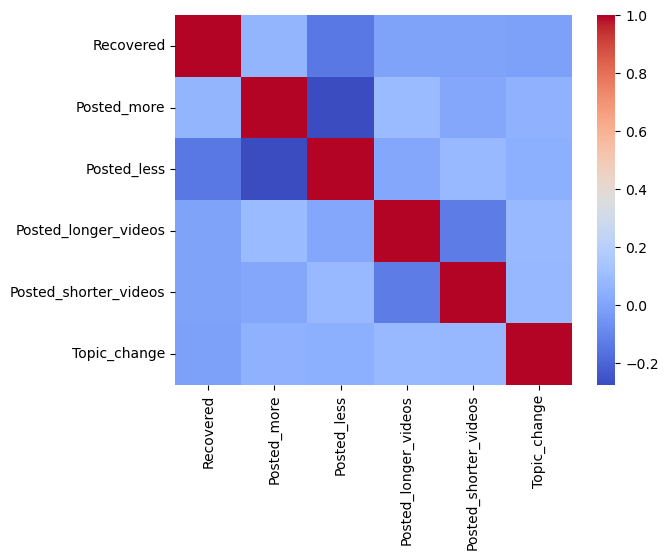

In [58]:
# Heatmap of the correlation matrix
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()

**Thoughts :** This visual analysis confirm the correlation analysis 

### Feature importance analysis 

First, do the regression on all the declines that we kept until now.

As a sanity check, we run the same regression, removing the declines that have no videos either before, during or both to check that the presence of zeros does not have a significant impact on the results.

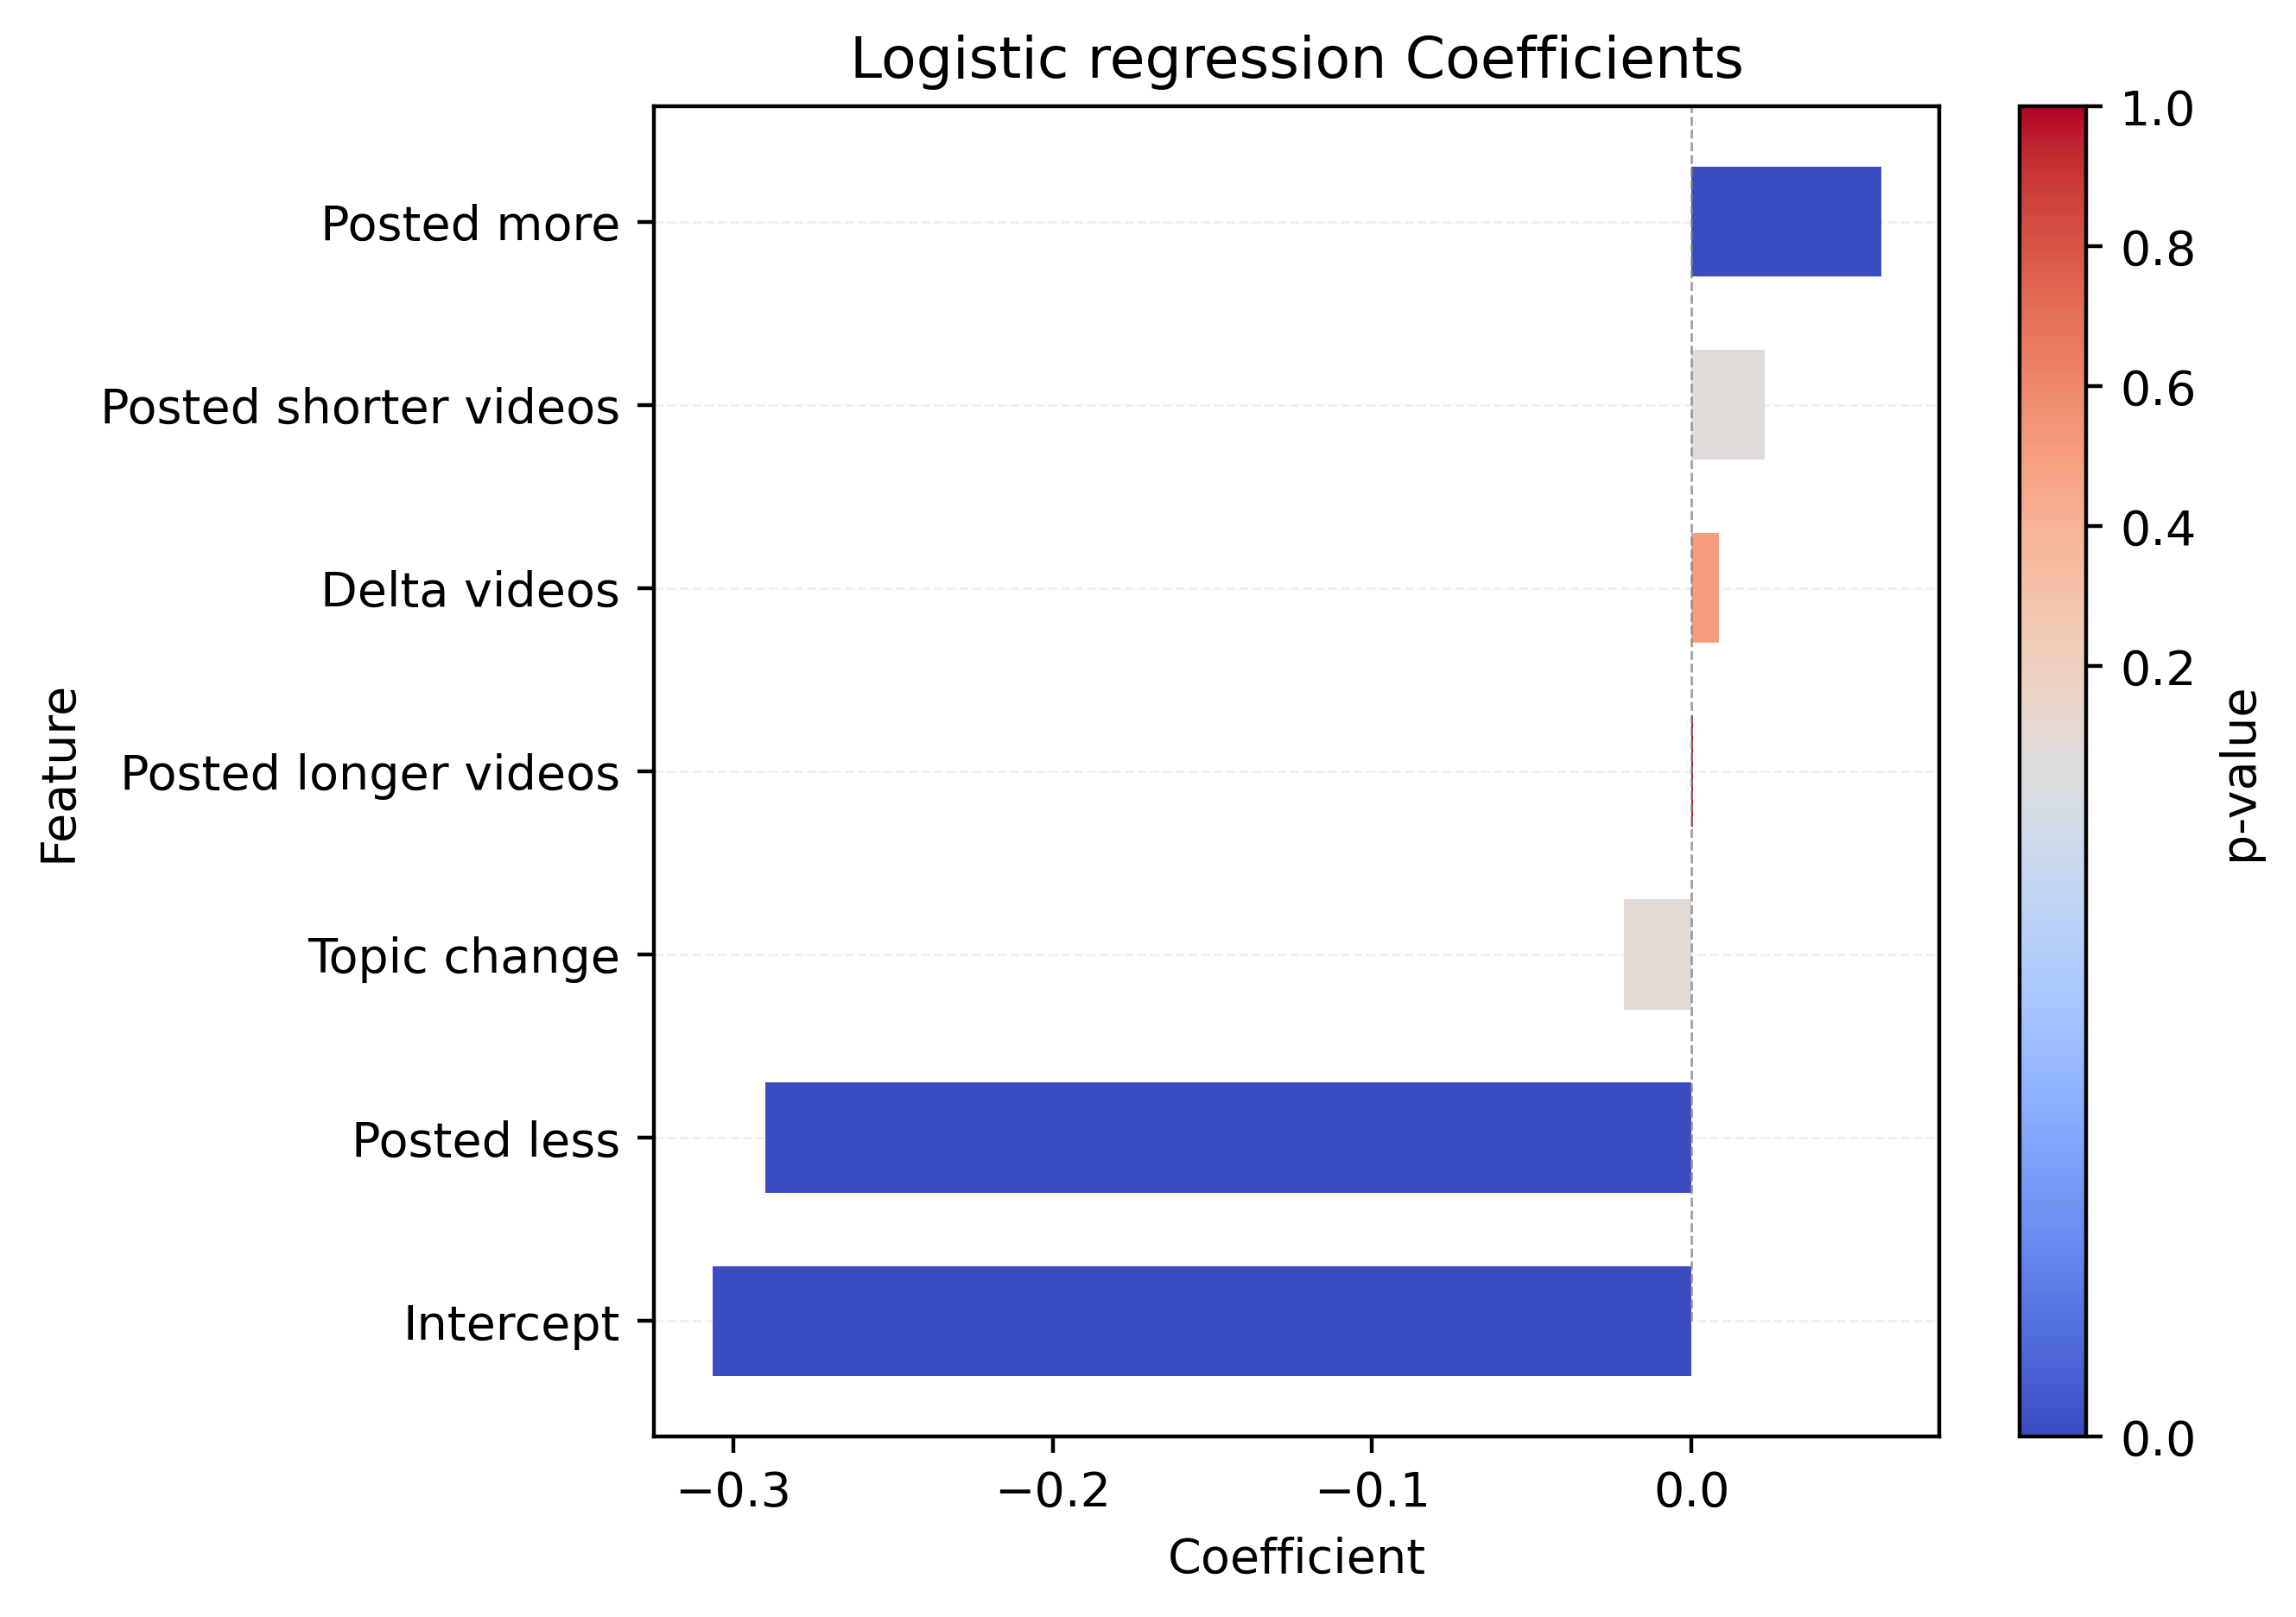

In [59]:
# Columns that are not included in the regression
drop_cols = ['Channel', 'Start', 'End', 'Duration', 'Recovered', 'Mean_duration_difference', 'Mean_frequency_difference', 'Category', 'Subs_start', 'Views_start', 'Activity_start']

# Prepare the data for the logistic regression
logit_X = df_sampled.drop(drop_cols, axis=1)
logit_y = df_sampled['Recovered']

# Perform the regression
logit_result = perform_logistic_regression(logit_X, logit_y)

plt.figure(figsize=(6, 5), dpi=400)
plot_logit_coefficients(logit_result, title='Logistic regression Coefficients')

# Save the coefficients, p-values and variable names to a file for plotting
with open('plot_data/logit_results.csv', 'w') as f:
    res = pd.DataFrame({'coef': logit_result.params, 'p-value': logit_result.pvalues}).reset_index()
    res.columns = ['Variable', 'Coefficient', 'p-value']
    res.to_csv(f, index=False)

**Key Insights:**

* **Posted_more**:  Posting more videos during the decline period significantly increases the chances of recovery.

* **Posted_shorter_videos** : Posting shorter videos has a marginally significant positive effect on recovery.

* **Posted_less** : Posting fewer videos significantly decreases the chances of recovery.
* 

**Actionable Advice:**

* **Increase Video Uploads** : Consistently post more videos during the decline period to engage your audience and increase the chances of recovery.

* **Avoid Reducing Uploads** : Avoid posting fewer videos, as this significantly decreases the chances of recovery.

* **Consider Video Length** : Posting shorter videos may have a positive impact on recovery.

### Propensity score matching

Seeing that the declines do not have the same distribution on their features, we perform propensity score matchings to balance the treatment and control groups looking at the effect that changing publication frequency,video duration and video category after the start of the decline have on the recovery.

After the propensity score matching, we can observe the effect of the different treatments on the recovery :

Posted_more matches : [(8978.0, 6.0), (11747.0, 17.0), (722.0, 24.0), (31161.0, 27.0), (9543.0, 29.0), (25740.0, 33.0), (14407.0, 34.0), (15318.0, 42.0), (18234.0, 50.0), (6424.0, 57.0), (13720.0, 58.0), (23001.0, 59.0), (3117.0, 65.0), (11266.0, 70.0), (4538.0, 76.0), (25614.0, 84.0), (5254.0, 97.0), (31079.0, 99.0), (6724.0, 100.0), (19835.0, 101.0), (24579.0, 121.0), (201.0, 125.0), (24609.0, 128.0), (22560.0, 131.0), (26962.0, 132.0), (2508.0, 133.0), (22013.0, 134.0), (2260.0, 137.0), (8072.0, 149.0), (9032.0, 153.0), (5904.0, 159.0), (29893.0, 162.0), (11184.0, 173.0), (21461.0, 189.0), (5206.0, 199.0), (21471.0, 203.0), (12607.0, 215.0), (22312.0, 223.0), (3543.0, 227.0), (26889.0, 236.0), (16890.0, 243.0), (7270.0, 249.0), (5995.0, 250.0), (23225.0, 254.0), (22609.0, 262.0), (12541.0, 265.0), (6218.0, 271.0), (2270.0, 292.0), (23744.0, 293.0), (29996.0, 298.0), (11869.0, 303.0), (7527.0, 304.0), (29168.0, 305.0), (14725.0, 311.0), (31191.0, 315.0), (17742.0, 316.0), (247.0, 320

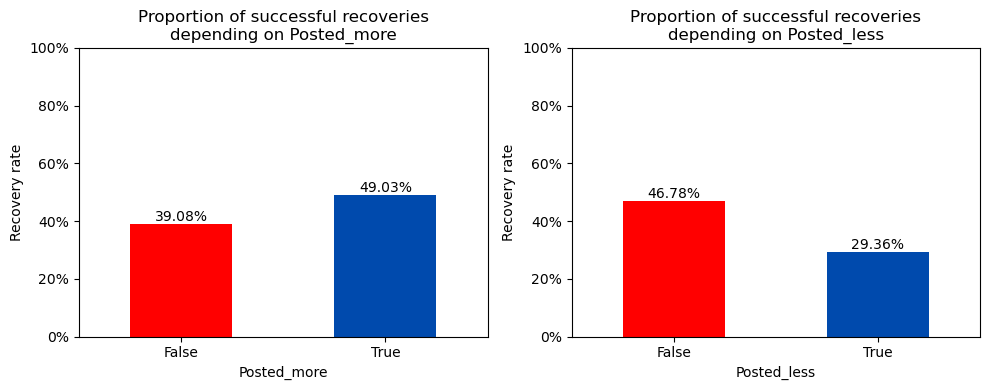

Posted_longer_videos matches : [(31022.0, 0.0), (26813.0, 1.0), (694.0, 12.0), (16447.0, 18.0), (10531.0, 30.0), (18064.0, 33.0), (11122.0, 61.0), (31261.0, 75.0), (6305.0, 84.0), (2598.0, 100.0), (6502.0, 101.0), (30365.0, 113.0), (5983.0, 120.0), (18810.0, 129.0), (8896.0, 130.0), (15621.0, 137.0), (27776.0, 142.0), (14032.0, 143.0), (5006.0, 145.0), (22803.0, 156.0), (16933.0, 159.0), (10161.0, 190.0), (23069.0, 199.0), (31051.0, 200.0), (16435.0, 205.0), (3484.0, 211.0), (14668.0, 215.0), (27253.0, 228.0), (28902.0, 236.0), (1192.0, 245.0), (17707.0, 247.0), (21094.0, 254.0), (27035.0, 261.0), (25184.0, 266.0), (15407.0, 269.0), (14330.0, 278.0), (13923.0, 286.0), (10716.0, 298.0), (4046.0, 300.0), (12753.0, 303.0), (3017.0, 304.0), (3749.0, 318.0), (3260.0, 320.0), (29093.0, 322.0), (4410.0, 325.0), (2273.0, 329.0), (1495.0, 333.0), (12498.0, 336.0), (2509.0, 338.0), (25006.0, 342.0), (15280.0, 343.0), (28938.0, 346.0), (3333.0, 350.0), (1779.0, 371.0), (9846.0, 372.0), (729.0, 37

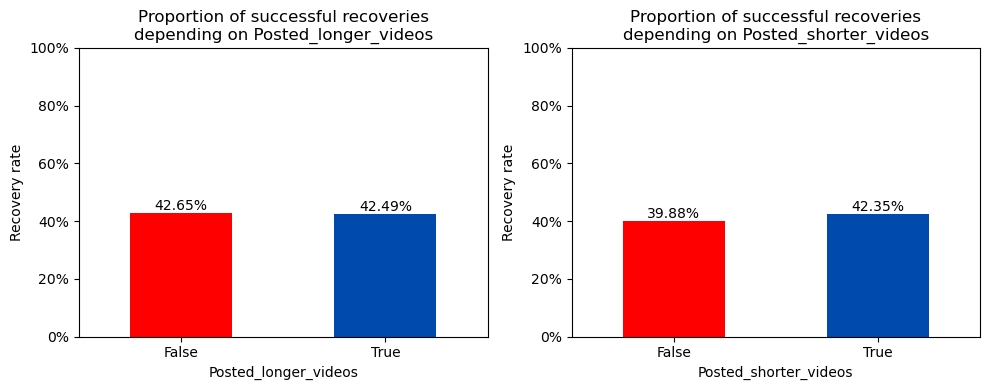

Topic_change matches : [(21231.0, 5.0), (10977.0, 7.0), (26100.0, 11.0), (26494.0, 12.0), (12325.0, 15.0), (17348.0, 17.0), (16356.0, 18.0), (14115.0, 22.0), (12034.0, 27.0), (8809.0, 37.0), (9217.0, 42.0), (9157.0, 49.0), (30971.0, 56.0), (3572.0, 57.0), (16922.0, 58.0), (11594.0, 62.0), (12885.0, 74.0), (12084.0, 76.0), (1992.0, 78.0), (30511.0, 82.0), (5434.0, 91.0), (17036.0, 94.0), (4508.0, 105.0), (23431.0, 109.0), (9829.0, 111.0), (4839.0, 115.0), (17368.0, 122.0), (23003.0, 131.0), (2239.0, 137.0), (17244.0, 138.0), (12100.0, 153.0), (205.0, 155.0), (5906.0, 158.0), (495.0, 163.0), (5651.0, 177.0), (9833.0, 184.0), (22744.0, 190.0), (20676.0, 202.0), (3040.0, 203.0), (9098.0, 210.0), (28602.0, 214.0), (4749.0, 222.0), (24184.0, 233.0), (15786.0, 241.0), (5869.0, 242.0), (13361.0, 245.0), (6079.0, 253.0), (20341.0, 264.0), (4082.0, 265.0), (1930.0, 266.0), (11324.0, 269.0), (6694.0, 281.0), (8050.0, 283.0), (27567.0, 284.0), (19569.0, 285.0), (24135.0, 288.0), (15169.0, 289.0), 

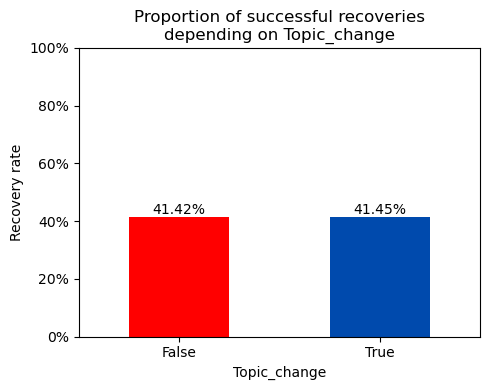

In [60]:
# The variables to be used for the matching
# Treatments in the same array will be plotted together
TREATMENTS = [
    ['Posted_more',
    'Posted_less'],
    ['Posted_longer_videos',
    'Posted_shorter_videos'],
    ['Topic_change'], 
]

# The variables to be dropped for each treatment (to avoid multicollinearity or strong correlation)
# Use the same order as the TREATMENTS array
to_drop = [
    [['Mean_frequency_difference', 'Posted_less'],
    ['Mean_frequency_difference', 'Posted_more']],
    [['Mean_duration_difference', 'Posted_shorter_videos'],
    ['Mean_duration_difference', 'Posted_longer_videos']],
    [[]]
]

plot_df = pd.DataFrame(columns=['Strategy', 'Adopted the strategy', 'Did not adopt'])

matched_dfs = {}
for plot_treatments, plot_dropped in zip(TREATMENTS, to_drop):
    fig, axes = plt.subplots(1, len(plot_treatments), figsize=(5*len(plot_treatments), 4))
    for subplot_id, (treatment, dropped) in enumerate(zip(plot_treatments, plot_dropped)):

        # Try to load the matches from the file, otherwise compute them
        matches = get_matches(treatment=treatment, declines=df_sampled.drop(dropped, axis=1), verbose=False)

        print(f"{treatment} matches :", matches)

        # Flatten
        matches = [index for match in matches for index in match]

        # Get the matched declines
        matched_dfs[treatment] = df_sampled.loc[matches]

        counts = matched_dfs[treatment].groupby(treatment)['Recovered'].mean() * 100
        plot_df.loc[len(plot_df)] = [treatment, counts[True], counts[False]]

        plot_treatment_effect(matched_dfs[treatment], treatment, ax=axes[subplot_id] if len(plot_treatments) > 1 else axes)

    plt.tight_layout()
    plt.show()

plot_df.to_csv('plot_data/matches_results.csv', index=False)

### T-tests

In [61]:
# Store results for reporting
t_test_results = []

for treatment, df in matched_dfs.items():
    # Separate groups and convert 'Recovered' to numeric
    group_adopted = df[df[treatment] == True]['Recovered'].astype(float)
    group_not_adopted = df[df[treatment] == False]['Recovered'].astype(float)
    
    # Perform t-test
    t_stat, p_value = ttest_ind(group_adopted, group_not_adopted, equal_var=False)  # Welch's t-test for unequal variances

    # Calculate means for reporting
    mean_adopted = group_adopted.mean()
    mean_not_adopted = group_not_adopted.mean()
    
    # Determine significance
    significant = p_value < 0.05

    # Store results
    t_test_results.append({
        "Treatment": treatment,
        "Mean Adopted": mean_adopted,
        "Mean Not Adopted": mean_not_adopted,
        "T-Statistic": t_stat,
        "P-Value": p_value,
        "Significant": significant
    })

# Display results as a DataFrame
t_test_results_df = pd.DataFrame(t_test_results)
print(t_test_results_df)

               Treatment  Mean Adopted  Mean Not Adopted  T-Statistic  \
0            Posted_more      0.490332          0.390811    10.695410   
1            Posted_less      0.293596          0.467815   -19.942974   
2   Posted_longer_videos      0.424875          0.426537    -0.154211   
3  Posted_shorter_videos      0.423467          0.398765     1.690407   
4           Topic_change      0.414455          0.414162     0.034759   

        P-Value  Significant  
0  1.434224e-26         True  
1  4.573694e-87         True  
2  8.774473e-01        False  
3  9.101890e-02        False  
4  9.722727e-01        False  


# Let's look at how we could answer to Youtuber's questions 

## Q1 : How often should I post new videos?
We saw that **uploading more videos** should help to maximize the chances of recovery. Hence we should look at how many videos we should advise him to post each week 

As `Posted_more` has a positive impact on recovery, we want to look into what situations benefit the most from posting videos more often.

We therefore look at the characteristics of decline which reacted that way, and when it worked best :

- Did channels who increased publication frequency already post often, or did they post few videos before the
- Is posting more often associated with a lower average video duration?

In [62]:
# Build the reaction dataframe
df_reactions = build_reaction_dataframe(df_sampled, df_videos_per_week, df_video_duration)
df_reactions


Channel  Duration  Start  End  Recovered  \
0.0      UC3B6FyoLMLrUYa6i72ccPvw        20    189  209      False   
1.0      UCIHBFO-XMyTpzXAN-lg8o2g        14    112  126       True   
2.0      UC2MjZanWOfyfsrHOyitmXbQ        14    128  142       True   
3.0      UCgUtduvq2Wpc7CDHcGDmZog        15    188  203       True   
4.0      UCMn7t0wYUevjBqhK9PUGfHA        19    154  173      False   
...                           ...       ...    ...  ...        ...   
31635.0  UC1K0dOUXlTyaDODIxpTBBwQ        17    205  222      False   
31638.0  UCFc1q8NjbBh_MHJvYP_sbsg        16    224  240      False   
31639.0  UCIPdIlv1EIGyTSfFAfV0Eag        10    236  246       True   
31640.0  UCDmxnPem-pPfJQATIkfgY2Q        41    201  242      False   
31641.0  UCsFmkkSVNgvihycqqtjSXgA        12    229  241       True   

         Mean_duration_difference  Mean_frequency_difference  \
0.0                    419.748120                  -0.250000   
1.0                   1432.453191                  -1.214286   
2.0                   -177.302463                   0.428571   
3.0                   -249.533333                  -0.600000   
4.0                    -38.000000                  -0.210526   
...                           ...                        ...   
31635.0               -188.198701                  -0.882353   
31638.0               -229.513258                   1.062500   
31639.0                -39.500000                   0.100000   
31640.0               -412.850549                  -0.219512   
31641.0                -22.786325                   0.416667   

         Videos_per_week_before  Videos_per_week_after  Mean_duration_before  \
0.0                    0.950000               0.700000            566.894737   
1.0                    3.357143               2.142857           1095.446809   
2.0                    2.071429               2.500000            721.931034   
3.0                    1.600000               1.000000            921.666667   
4.0                    0.263158               0.052632            209.000000   
...                         ...                    ...                   ...   
31635.0                4.117647               3.235294            711.471429   
31638.0                1.000000               2.062500            859.937500   
31639.0                0.100000               0.200000            184.000000   
31640.0                0.853659               0.634146           2475.542857   
31641.0                1.083333               1.500000            182.230769   

         Mean_duration_after Frequency_reaction Video_duration_reaction  
0.0               986.642857          No_change    Posted_longer_videos  
1.0              2527.900000          No_change    Posted_longer_videos  
2.0               544.628571          No_change               No_change  
3.0               672.133333          No_change               No_change  
4.0               171.000000        Posted_less               No_change  
...                      ...                ...                     ...  
31635.0           523.272727          No_change               No_change  
31638.0           630.424242        Posted_more               No_change  
31639.0           144.500000        Posted_more               No_change  
31640.0          2062.692308          No_change               No_change  
31641.0           159.444444          No_change               No_change  

[26935 rows x 13 columns]

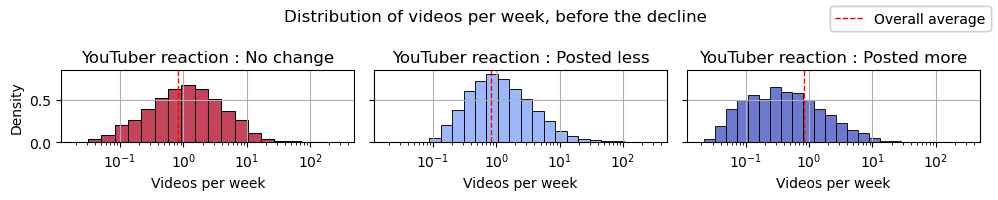

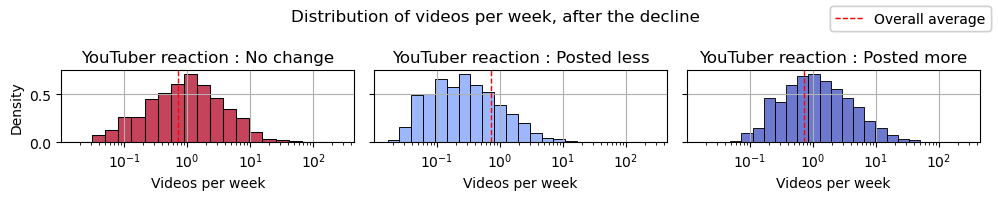

In [63]:
plot_distribution_by_frequency_reaction(df_reactions, 'Videos_per_week_before', 'Distribution of videos per week, before the decline')
plot_distribution_by_frequency_reaction(df_reactions, 'Videos_per_week_after', 'Distribution of videos per week, after the decline')
plt.show()

**Plot description :**

* In red are the channels that during their decline didn't change the frequency of their publications, we plot the ditribution of videos published before and after their decline.

* In light blue are the channels that during they declined decreased the frequency of their publications, we plot the distribution of videos published before and after their decline.

* In dark blue are the channels that during they declined increased the frequency of their publications, we plot the distribution of videos published before and after their decline.

* The red line represents the average number of videos published before/after the decline.

It is interesting to note that the channels that increased video frequency after the start of the decline used to post less than average before the decline, while the ones that reduced video frequency used to post approximately as much as the average. The two groups almost switch places in terms of video frequency.

These observations are good because their decline and recovery can be caused because they posted less videos, and they could have recovered by posting more videos.

**Next :** 

It would be interesting to give an indicator of the **number of videos to post per week** in order to have more chance to recover

In [64]:
df_reaction_posted_more = df_reactions[df_reactions['Frequency_reaction'] == 'Posted_more']

stats_before = df_reaction_posted_more[df_reaction_posted_more['Recovered']==1]['Videos_per_week_before'].describe()
stats_after = df_reaction_posted_more[df_reaction_posted_more['Recovered']==1]['Videos_per_week_after'].describe()

print("Statistics for Videos per Week Before Decline:")
print(stats_before)

print("\nStatistics for Videos per Week After Decline:")
print(stats_after)

Statistics for Videos per Week Before Decline:
count    2764.000000
mean        1.208211
std         2.611500
min         0.066667
25%         0.166667
50%         0.428571
75%         1.181818
max        60.583333
Name: Videos_per_week_before, dtype: float64

Statistics for Videos per Week After Decline:
count    2764.000000
mean        3.016333
std         6.539793
min         0.133333
25%         0.555556
50%         1.250000
75%         3.153846
max       172.500000
Name: Videos_per_week_after, dtype: float64


I don't think that the mean is really meaningful because we can notice quite some outliers, we should therefore preferably look at the median. Here we can observe that before a decline 0.41 videos were posted and after a decline 1.2 videos were posted. Meaning that we could advice to post at least one video per week in order to increase the chance of recovering from the decline 

In [65]:
# Perform t-test for number of videos per week before the decline
t_stat_before, p_value_before = ttest_ind(df_reaction_posted_more[df_reaction_posted_more['Recovered'] == 1]['Videos_per_week_before'],
                                          df_reaction_posted_more[df_reaction_posted_more['Recovered'] == 0]['Videos_per_week_before'], equal_var=False)

# Perform t-test for number of videos per week after the decline
t_stat_after, p_value_after = ttest_ind(df_reaction_posted_more[df_reaction_posted_more['Recovered'] == 1]['Videos_per_week_after'],
                                        df_reaction_posted_more[df_reaction_posted_more['Recovered'] == 0]['Videos_per_week_after'], equal_var=False)

print(f'T-test for Videos per Week Before Decline: t-statistic = {t_stat_before}, p-value = {p_value_before}')
print(f'T-test for Videos per Week After Decline: t-statistic = {t_stat_after}, p-value = {p_value_after}')

T-test for Videos per Week Before Decline: t-statistic = 3.6295734649917746, p-value = 0.00028645681504447184
T-test for Videos per Week After Decline: t-statistic = 3.593289978128203, p-value = 0.0003293440735917013


Both t-tests suggest that the number of videos per week (both before and after the decline) is significantly different between channels that recovered and those that did not. This implies that the frequency of video uploads may play a role in a channel's recovery from a decline.

In [66]:
# Prepare the data for logistic regression
X = df_reaction_posted_more[['Mean_frequency_difference', 'Mean_duration_before', 'Mean_duration_after']]
y = df_reaction_posted_more['Recovered'].astype(int)  # Ensure the target variable is integer

# Add a constant to the model
X = sm.add_constant(X)

print(X.dtypes)
# Fit the logistic regression model
logit_model = sm.Logit(y, X).fit()

# Print the summary of the model
print(logit_model.summary())

const                        float64
Mean_frequency_difference    float64
Mean_duration_before         float64
Mean_duration_after          float64
dtype: object
Optimization terminated successfully.
         Current function value: 0.691170
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              Recovered   No. Observations:                 5637
Model:                          Logit   Df Residuals:                     5633
Method:                           MLE   Df Model:                            3
Date:                Thu, 19 Dec 2024   Pseudo R-squ.:                0.002584
Time:                        21:41:37   Log-Likelihood:                -3896.1
converged:                       True   LL-Null:                       -3906.2
Covariance Type:            nonrobust   LLR p-value:                 0.0001554
                                coef    std err          z      P>|z|      [0.025      0.975]
----------

**Summary:**
* **Intercept (const)**: `Statistically significant` (p-value = 0.022), indicating a baseline log-odds of recovery.
* **Mean_frequency_difference**: `Statistically significant` (p-value = 0.016), suggesting that the mean frequency difference has a significant positive effect on the recovery rate.
* **Mean_duration_before**: `Statistically significant` (p-value = 0.020), suggesting that the mean duration of videos before the decline has a significant positive effect on the recovery rate.
* **Mean_duration_after**: `Not statistically significant` (p-value = 0.703), suggesting that the mean duration of videos after the decline does not have a significant effect on the recovery rate.

The only variable that migth be interesting to look into is the mean frequency difference

In [67]:
# Analyse relationship between mean frequency difference and recovery
correlation = df_sampled['Mean_frequency_difference'].corr(df_sampled['Recovered'])
print(f'Correlation between Mean Frequency Difference and Recovery: {correlation}')

Correlation between Mean Frequency Difference and Recovery: 0.04935700395052572


In order to advise a creator of the number of videos to upload, we should look at the probability to recover of each different frequency of upload

#### Propensity Score Matching on each frequency bin

In [68]:
plot_df = match_upload_frequency(df_sampled, df_videos_per_week)
print(plot_df)

Processing bin: <0.5 (40.19% of declines)


/opt/anaconda3/envs/ada/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning:

overflow encountered in exp



Processing bin: 0.5-1 (18.69% of declines)
Processing bin: 1-2 (16.48% of declines)
Processing bin: 2-3 (7.73% of declines)
Processing bin: 3-4 (4.48% of declines)
Processing bin: 4-5 (2.99% of declines)
Processing bin: >5 (6.33% of declines)
  Frequency_bin  Recovery_rate
0          <0.5      35.852194
1         0.5-1      44.020660
2           1-2      45.753548
3           2-3      47.431589
4           3-4      50.124275
5           4-5      51.552795
6            >5      52.140762


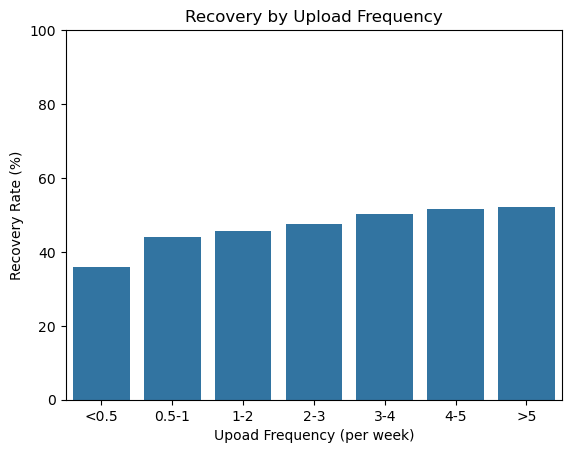

In [69]:
sns.barplot(data=plot_df, x='Frequency_bin', y='Recovery_rate', errorbar=None)
plt.title(f'Recovery by Upload Frequency')
plt.xlabel('Upoad Frequency (per week)')
plt.ylabel('Recovery Rate (%)')
plt.ylim(0, 100)
plt.show()

We can see on this histogram what upload frequencies have the best average recovery rates.

## Q2 : Should I focus on shorter or longer videos? 

Now I know that I should upload more frequently, but what about the duration of my videos 

From the regression, we observed that changing the duration of a video doesn't change much. But let's still be a bit curious and see if we can extract something out of it 

Here we want to visualize if changing the duration of the videos uploaded change the rate of recovery. We observe that if there is no change in the duration of the videos uploaded then the creator has 50% chance of recovery. If the creator posts shorter videos, he has 50% chance of recovery as well and if he posts longer videos then he has 47% chance of recovery. 

So by just visualizing the data, we may want to conclude that during a decline changing the duration of the videos uploaded doesn't change the recovery. 

In [71]:
# Calculate the correlation
correlation = df_video_duration['Mean_duration_after'].corr(df['Recovered'])
print(f'Correlation between mean video duration and recovery: {correlation}')

Correlation between mean video duration and recovery: 0.037048746331559364


#### Propensity Score Matching on each duration bin

In [72]:
plot_df = match_video_duration(df_sampled, df_video_duration)
print(plot_df)

0.0        15-20
1.0        30-60
2.0         5-10
3.0        10-15
4.0           <5
           ...  
31635.0     5-10
31638.0    10-15
31639.0       <5
31640.0    30-60
31641.0       <5
Name: Duration_bin, Length: 26935, dtype: category
Categories (7, object): ['<5' < '5-10' < '10-15' < '15-20' < '20-30' < '30-60' < '>60']
Number of samples in each bin:
Duration_bin
<5       8642
5-10     6739
10-15    4835
15-20    2178
20-30    1816
30-60    1668
>60       735
Name: count, dtype: int64
Processing bin: <5
Processing bin: 5-10
Processing bin: 10-15
Processing bin: 15-20
Processing bin: 20-30
Processing bin: 30-60
Processing bin: >60
  Duration_bin  Recovery_rate
0           <5      39.308031
1         5-10      42.543404
2        10-15      42.626680
3        15-20      46.280992
4        20-30      48.623348
5        30-60      45.743405
6          >60      46.122449


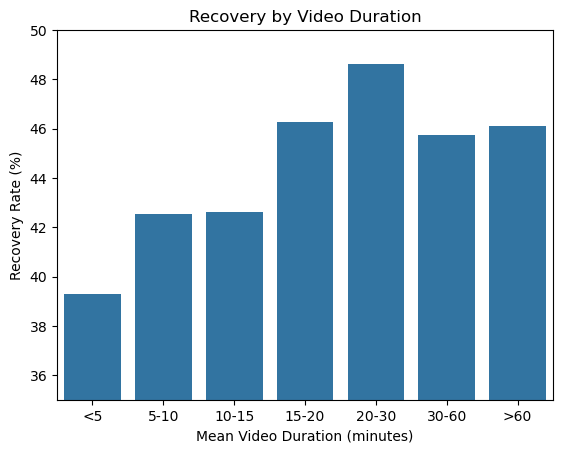

In [73]:
sns.barplot(data=plot_df, x='Duration_bin', y='Recovery_rate', errorbar=None)
plt.title(f'Recovery by Video Duration')
plt.xlabel('Mean Video Duration (minutes)')
plt.ylabel('Recovery Rate (%)')
plt.ylim(35, 50)
plt.show()

## Q3 : What type of content should i focus on ? 

In [74]:
df = df_sampled.copy()

# Calculate the average recovery rate for each content category
recovery_by_category = df.groupby('Category')['Recovered'].mean().reset_index()

# Sort the categories by recovery rate
recovery_by_category = recovery_by_category.sort_values(by='Recovered', ascending=False)

# Display the recovery rates by category
print(recovery_by_category)


                 Category  Recovered
8         News & Politics   0.487985
5                  Gaming   0.463433
12   Science & Technology   0.454318
0        Autos & Vehicles   0.449905
6           Howto & Style   0.442514
14        Travel & Events   0.439776
1                  Comedy   0.435897
10         People & Blogs   0.432520
13                 Sports   0.432000
3           Entertainment   0.421364
11         Pets & Animals   0.411765
4      Film and Animation   0.406863
2               Education   0.382353
9   Nonprofits & Activism   0.376471
7                   Music   0.319603


/Users/gattimartina/Documents/EPFL/Master/MA1/ADA/Project/ada-2024-project-ooohfada/src/utils/plots_utils.py:206: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




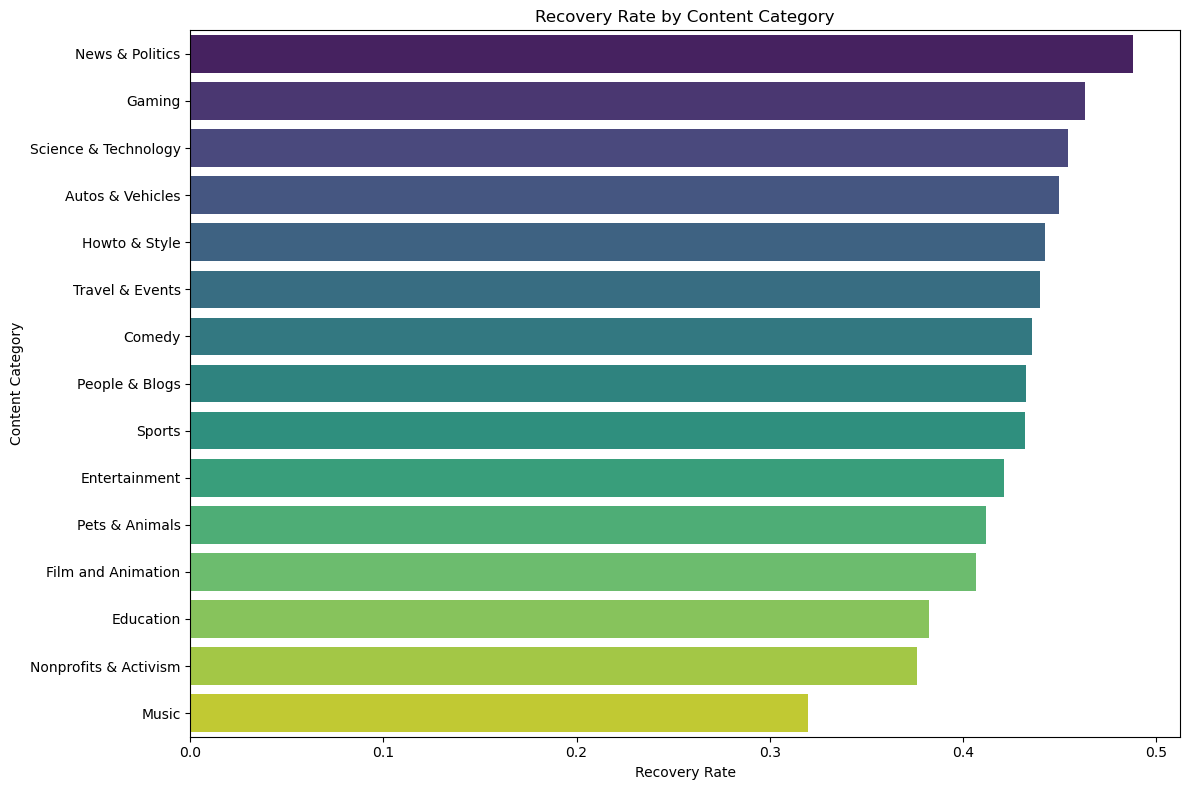

In [75]:
plot_horizontal_barplot('Content Category', recovery_by_category, 'Recovered', 'Category')

This is naive and does not lead to any conclusions regarding what reactions are best. 

We will therefore explore topic changes

In [76]:
# Example recommendation based on the barplot
high_recovery_categories = recovery_by_category[recovery_by_category['Recovered'] > 0.45]['Category'].tolist()
low_recovery_categories = recovery_by_category[recovery_by_category['Recovered'] <= 0.45]['Category'].tolist()

recommendation = f"To maximize your chances of recovery, focus on creating content in the following categories: {', '.join(high_recovery_categories)}. These categories have shown higher recovery rates. Consider avoiding or minimizing content in the following categories: {', '.join(low_recovery_categories)}, as they have shown lower recovery rates."

print(recommendation)

To maximize your chances of recovery, focus on creating content in the following categories: News & Politics, Gaming, Science & Technology. These categories have shown higher recovery rates. Consider avoiding or minimizing content in the following categories: Autos & Vehicles, Howto & Style, Travel & Events, Comedy, People & Blogs, Sports, Entertainment, Pets & Animals, Film and Animation, Education, Nonprofits & Activism, Music, as they have shown lower recovery rates.


## Q4 : Should I change the topic of my videos? 

### How does a change of topic influence the recovery?

In [77]:
topic_change_data = pd.read_csv('data/df_topic_change_20_15w.csv')
topic_change_data.columns = ['Decline', 'Topic_change', 'Topic_before', 'Topic_after']

df_reactions_topics = pd.merge(df_reactions, topic_change_data, left_index=True, right_on='Decline', how='left')
df_reactions_topics = df_reactions_topics.dropna()

Very small variation, not statistically significant \
BUT maybe different topic transitions have different correlations with the recovery

### Analysis of different topic changes

In [78]:
df_reactions_changed_topic = df_reactions_topics[df_reactions_topics['Topic_change'] == True]
df_reactions_changed_topic = df_reactions_changed_topic.drop(columns=['Decline', 'Topic_change'])
df_reactions_changed_topic = df_reactions_changed_topic.dropna()
df_reactions_changed_topic.head()

Channel  Duration  Start  End  Recovered  \
5.0   UCEkfvGbHtngMQJ5t4wsBY0Q        19    190  209      False   
7.0   UCgqv_8dYjKNkcC9DcU99R8g        11    199  210       True   
11.0  UCWxG3l_NRgrLuZjo6Hk_OLw        11    112  123       True   
15.0  UCML3sc7SIGyOyHvVyR74M7g        11     89  100       True   
22.0  UCr2UGJPBrfr8J0fdDkQqbyQ        24    147  171      False   

      Mean_duration_difference  Mean_frequency_difference  \
5.0                  63.454559                  -0.105263   
7.0                   8.466667                  -0.090909   
11.0                -19.356150                   0.363636   
15.0               2100.000000                   0.000000   
22.0                 76.289231                  -0.500000   

      Videos_per_week_before  Videos_per_week_after  Mean_duration_before  \
5.0                 6.210526               6.105263            524.864407   
7.0                 0.545455               0.454545            416.333333   
11.0                4.636364               5.000000            315.647059   
15.0                0.090909               0.090909           1244.000000   
22.0                1.041667               0.541667            637.480000   

      Mean_duration_after Frequency_reaction Video_duration_reaction  \
5.0            588.318966          No_change               No_change   
7.0            424.800000          No_change               No_change   
11.0           296.290909          No_change               No_change   
15.0          3344.000000          No_change    Posted_longer_videos   
22.0           713.769231          No_change               No_change   

      Topic_before  Topic_after  
5.0           11.0         13.0  
7.0            7.0         13.0  
11.0          11.0          5.0  
15.0          10.0          4.0  
22.0          11.0          5.0

### Use the LLM-generated topic themes

In [79]:
df_reactions_changed_topic = map_topics_to_llm_themes('data/LLM_topics.json', df_reactions_changed_topic)
df_reactions_changed_topic.head()

Channel  Duration  Start  End  Recovered  \
5.0   UCEkfvGbHtngMQJ5t4wsBY0Q        19    190  209      False   
7.0   UCgqv_8dYjKNkcC9DcU99R8g        11    199  210       True   
11.0  UCWxG3l_NRgrLuZjo6Hk_OLw        11    112  123       True   
15.0  UCML3sc7SIGyOyHvVyR74M7g        11     89  100       True   
22.0  UCr2UGJPBrfr8J0fdDkQqbyQ        24    147  171      False   

      Mean_duration_difference  Mean_frequency_difference  \
5.0                  63.454559                  -0.105263   
7.0                   8.466667                  -0.090909   
11.0                -19.356150                   0.363636   
15.0               2100.000000                   0.000000   
22.0                 76.289231                  -0.500000   

      Videos_per_week_before  Videos_per_week_after  Mean_duration_before  \
5.0                 6.210526               6.105263            524.864407   
7.0                 0.545455               0.454545            416.333333   
11.0                4.636364               5.000000            315.647059   
15.0                0.090909               0.090909           1244.000000   
22.0                1.041667               0.541667            637.480000   

      Mean_duration_after Frequency_reaction Video_duration_reaction  \
5.0            588.318966          No_change               No_change   
7.0            424.800000          No_change               No_change   
11.0           296.290909          No_change               No_change   
15.0          3344.000000          No_change    Posted_longer_videos   
22.0           713.769231          No_change               No_change   

                  Topic_before            Topic_after  
5.0              Movie Reviews      League of Legends  
7.0    Beauty & Lifestyle Vlog      League of Legends  
11.0             Movie Reviews   Art and Spirituality  
15.0                WWE Sports         GTA V Gameplay  
22.0             Movie Reviews   Art and Spirituality

In [80]:
topic_transitions = filter_topic_transitions(df_reactions_changed_topic)
topic_transitions.head()

Topic_before       Topic_after  recovery_rate  count
17   Beauty & Lifestyle Vlog      Design & DIY       0.314286     35
19   Beauty & Lifestyle Vlog             Funny       0.420000    100
23   Beauty & Lifestyle Vlog              Kids       0.333333     33
25   Beauty & Lifestyle Vlog     Movie Reviews       0.468085     47
26   Beauty & Lifestyle Vlog   Music Reactions       0.382353     34

### Plotly plots for the datastory (might not appear on GitHub, you can find them on the website)

In [81]:
plot_barplot_topics_plotly(topic_transitions)

In [82]:
sankey_diagram(topic_transitions)

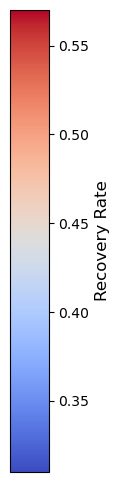

In [83]:
# Define the range for the color bar
x, y = 0.31, 0.57  # Replace with your desired range

# Normalize the color bar values
norm = Normalize(vmin=x, vmax=y)

# Create a colormap object using the coolwarm palette
cmap = cm.coolwarm

# Create a ScalarMappable to map normalized values to colors
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required to set the array for ScalarMappable

# Create the color bar
plt.figure(figsize=(0.5, 6))
cbar = plt.colorbar(sm, cax=plt.gca(), orientation='vertical')  # Vertical color bar
cbar.set_label('Recovery Rate', fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.show()


End of the plots.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

from src.data.dataloader_functions import load_processed_data
from src.models.llm_call_helpers import *
from src.utils._1M_plus_utils import *
from src.utils.recovery_analysis_utils import plot_recovered_by_categories

VIDEOS_TITLE_FILE = 'data/1M_plus_videos_title_around_declines.csv'

# Video Title extraction

This notebook's purpose is, for each decline, to extract some useful feature from the videos of the decline's channel, considering all videos during the decline and the last K videos before the decline, where K is the decline's duration.

## Load decline events data

In [26]:
decline_events = pd.read_csv('data/1M_plus_sampled_decline_events.csv')

decline_events

Channel  Duration  Mean_Number_of_Subscribers  \
0     UC1SqP7_RfOC9Jf9L_GRHANg        22                1.111359e+07   
1     UCLF-kfM8ZxHQ9lW_lpu_thw        19                2.932874e+06   
2     UCLF-kfM8ZxHQ9lW_lpu_thw        16                2.932874e+06   
3     UChGYKxkYdyi9e51dScmug6g         9                1.022885e+06   
4     UChGYKxkYdyi9e51dScmug6g        17                1.022885e+06   
...                        ...       ...                         ...   
2950  UCbW18JZRgko_mOGm5er8Yzg        22                2.277880e+07   
2951  UCevNJDNNIKmG13YmTqLnZ-A         9                1.659769e+06   
2952  UCevNJDNNIKmG13YmTqLnZ-A        18                1.659769e+06   
2953  UCy6kyFxaMqGtpE3pQTflK8A        17                1.322269e+06   
2954  UCy6kyFxaMqGtpE3pQTflK8A         9                1.322269e+06   

      Recovered  Start  End            Category    Subs_start  Activity_start  \
0         False    173  195               Music  1.174756e+07               0   
1         False    190  209       Entertainment  3.209915e+06              23   
2         False    228  244       Entertainment  3.396353e+06              23   
3          True    114  123      People & Blogs  1.008588e+06               2   
4         False    144  161      People & Blogs  1.063543e+06               1   
...         ...    ...  ...                 ...           ...             ...   
2950      False    170  192               Music  2.363792e+07               0   
2951       True    141  150       Howto & Style  1.669121e+06               3   
2952      False    157  175       Howto & Style  1.678545e+06               1   
2953      False    117  134  Film and Animation  1.066099e+06              10   
2954       True    201  210  Film and Animation  1.520935e+06              11   

       Views_start  
0     5.055265e+09  
1     4.307642e+09  
2     4.616026e+09  
3     2.802017e+07  
4     3.419171e+07  
...            ...  
2950  7.988348e+09  
2951  1.476181e+08  
2952  1.406823e+08  
2953  2.981150e+08  
2954  5.754011e+08  

[2955 rows x 10 columns]

## Extract video titles

For each decline, we will extract the video titles of the channel during the decline event.

/!\ Running the following cell is very time-consuming. Run it only if you don't have the file `1M_plus_videos_title_around_declines.csv` in the `data` folder.

In [4]:
extract_videos_title(decline_events, chunk_size=5000)

Chunk 0 (lines 0 to 5000): 13/5000 videos kept
Chunk 1 (lines 5000 to 10000): 77/5000 videos kept
Chunk 2 (lines 10000 to 15000): 526/5000 videos kept
Chunk 3 (lines 15000 to 20000): 66/5000 videos kept
Chunk 4 (lines 20000 to 25000): 117/5000 videos kept
Chunk 5 (lines 25000 to 30000): 5/5000 videos kept
Chunk 6 (lines 30000 to 35000): 237/5000 videos kept
Chunk 7 (lines 35000 to 40000): 51/5000 videos kept
Chunk 8 (lines 40000 to 45000): 470/5000 videos kept
Chunk 9 (lines 45000 to 50000): 1/5000 videos kept
Chunk 10 (lines 50000 to 55000): 59/5000 videos kept
Chunk 11 (lines 55000 to 60000): 0/5000 videos kept
Chunk 12 (lines 60000 to 65000): 16/5000 videos kept
Chunk 13 (lines 65000 to 70000): 0/5000 videos kept
Chunk 14 (lines 70000 to 75000): 20/5000 videos kept
Chunk 15 (lines 75000 to 80000): 60/5000 videos kept
Chunk 16 (lines 80000 to 85000): 34/5000 videos kept
Chunk 17 (lines 85000 to 90000): 0/5000 videos kept
Chunk 18 (lines 90000 to 95000): 0/5000 videos kept
Chunk 19 (l

In [24]:
extracted_videos = pd.read_csv(VIDEOS_TITLE_FILE)
extracted_videos.set_index([extracted_videos.columns[0], extracted_videos.columns[1]], inplace=True)

extracted_videos

index  \
channel                  week             
UCzVw9odnihM5PgKSv5UnDPA 247      12471   
                         246      12472   
                         246      12473   
                         245      12474   
                         244      12475   
...                                 ...   
UCs06q9pyRn8d8xy0NgzKPrA 216   72787994   
                         216   72787995   
                         215   72787996   
UCrwmu-gceGOmtZeuTsn7DlQ 193   72901188   
                         175   72901189   

                                                                           title  
channel                  week                                                     
UCzVw9odnihM5PgKSv5UnDPA 247   Most Funny Babies and Kids Playing in Water - ...  
                         246   Kids and Babies Trying to do Exercises   Funny...  
                         246   Cute and Adorable Moments of kids meeting newb...  
                         245     Cute Baby and His Daughter playing and Laughing  
                         244   Kids and Babies Meeting Animals in Village and...  
...                                                                          ...  
UCs06q9pyRn8d8xy0NgzKPrA 216   Tay K Allegedly Started a new gang in Jail cal...  
                         216   YNW Melly being investigated for a THIRD Murde...  
                         215   Face To Face: Lil Reese x DJ Akademiks: Talks ...  
UCrwmu-gceGOmtZeuTsn7DlQ 193                      The Black Eyed Peas - BIG LOVE  
                         175   The Black Eyed Peas - RING THE ALARM pt.1 pt.2...  

[107617 rows x 2 columns]

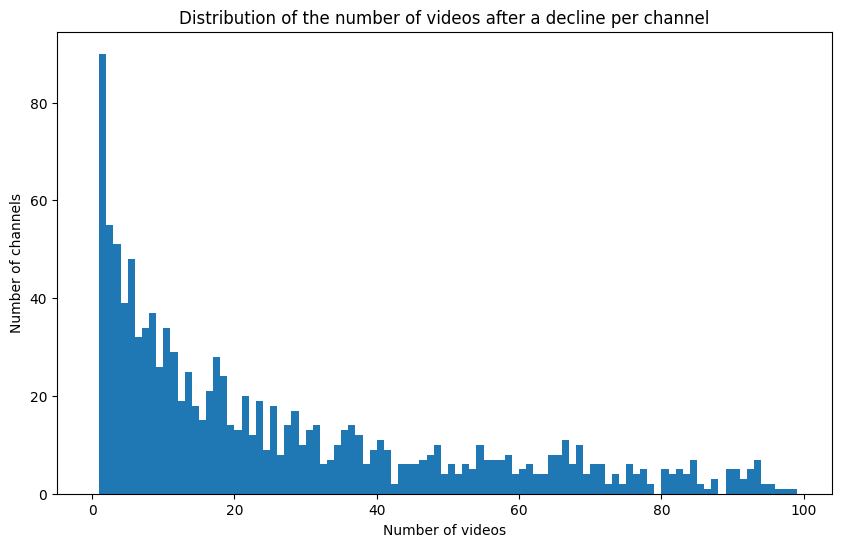

Number of channels: 1454


In [32]:
nb_videos = extracted_videos.groupby('channel').size()

plt.figure(figsize=(10, 6))

plt.hist(nb_videos.values, bins=range(0, 100))
plt.xlabel('Number of videos')
plt.ylabel('Number of channels')
plt.title('Distribution of the number of videos after a decline per channel')
plt.show()

print(f'Number of channels: {extracted_videos.index.get_level_values(0).nunique()}')

# LLM ANALYSIS

## Load data

Load the videos of interest = videos around declines for each channel. Each video comes with its index, channel, upload week and title.

In [3]:
videos = pd.read_csv('data/1M_plus_videos_title_around_declines.csv', index_col=(2))

videos

channel  week  \
index                                      
12471     UCzVw9odnihM5PgKSv5UnDPA   247   
12472     UCzVw9odnihM5PgKSv5UnDPA   246   
12473     UCzVw9odnihM5PgKSv5UnDPA   246   
12474     UCzVw9odnihM5PgKSv5UnDPA   245   
12475     UCzVw9odnihM5PgKSv5UnDPA   244   
...                            ...   ...   
72787994  UCs06q9pyRn8d8xy0NgzKPrA   216   
72787995  UCs06q9pyRn8d8xy0NgzKPrA   216   
72787996  UCs06q9pyRn8d8xy0NgzKPrA   215   
72901188  UCrwmu-gceGOmtZeuTsn7DlQ   193   
72901189  UCrwmu-gceGOmtZeuTsn7DlQ   175   

                                                      title  
index                                                        
12471     Most Funny Babies and Kids Playing in Water - ...  
12472     Kids and Babies Trying to do Exercises   Funny...  
12473     Cute and Adorable Moments of kids meeting newb...  
12474       Cute Baby and His Daughter playing and Laughing  
12475     Kids and Babies Meeting Animals in Village and...  
...                                                     ...  
72787994  Tay K Allegedly Started a new gang in Jail cal...  
72787995  YNW Melly being investigated for a THIRD Murde...  
72787996  Face To Face: Lil Reese x DJ Akademiks: Talks ...  
72901188                     The Black Eyed Peas - BIG LOVE  
72901189  The Black Eyed Peas - RING THE ALARM pt.1 pt.2...  

[107617 rows x 3 columns]

## Apply LLM functions

For each video, apply the LLM functions to extract the following features:
- whether the video is an apology video
- whether the video addresses the decline
- whether the video announces a comeback
- whether the video announces a break
- whether the video is a collaboration video
- whether the video is a clickbait video

/!\ Running the following cell is very time-consuming. It is recommended to run it on a powerful machine. Run it only if you don't have the file `llm_strategies.csv` in the `data` folder.

In [4]:
apply_llm_detection(videos)

Applying LLM detection functions ...
LLM detection functions applied.

Saving the results ...
Results saved to 'data/llm_strategies.csv'.



# LLM RESULTS ANALYSIS

## Load data

Load the videos

In [2]:
videos = pd.read_csv('data/1M_plus_videos_title_around_declines.csv')

videos

channel  week     index  \
0       UCzVw9odnihM5PgKSv5UnDPA   247     12471   
1       UCzVw9odnihM5PgKSv5UnDPA   246     12472   
2       UCzVw9odnihM5PgKSv5UnDPA   246     12473   
3       UCzVw9odnihM5PgKSv5UnDPA   245     12474   
4       UCzVw9odnihM5PgKSv5UnDPA   244     12475   
...                          ...   ...       ...   
107612  UCs06q9pyRn8d8xy0NgzKPrA   216  72787994   
107613  UCs06q9pyRn8d8xy0NgzKPrA   216  72787995   
107614  UCs06q9pyRn8d8xy0NgzKPrA   215  72787996   
107615  UCrwmu-gceGOmtZeuTsn7DlQ   193  72901188   
107616  UCrwmu-gceGOmtZeuTsn7DlQ   175  72901189   

                                                    title  
0       Most Funny Babies and Kids Playing in Water - ...  
1       Kids and Babies Trying to do Exercises   Funny...  
2       Cute and Adorable Moments of kids meeting newb...  
3         Cute Baby and His Daughter playing and Laughing  
4       Kids and Babies Meeting Animals in Village and...  
...                                                   ...  
107612  Tay K Allegedly Started a new gang in Jail cal...  
107613  YNW Melly being investigated for a THIRD Murde...  
107614  Face To Face: Lil Reese x DJ Akademiks: Talks ...  
107615                     The Black Eyed Peas - BIG LOVE  
107616  The Black Eyed Peas - RING THE ALARM pt.1 pt.2...  

[107617 rows x 4 columns]

## Load the results of the LLM

In [3]:
df_videos_llm = pd.read_csv('data/llm_strategies.csv')
df_videos_llm

/var/folders/47/q7m6g30d4ksfgl3r0ssyl_7h0000gn/T/ipykernel_99908/2407120277.py:1: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_videos_llm = pd.read_csv('data/llm_strategies.csv')


channel  week     index  \
0       UCzVw9odnihM5PgKSv5UnDPA   247     12471   
1       UCzVw9odnihM5PgKSv5UnDPA   246     12472   
2       UCzVw9odnihM5PgKSv5UnDPA   246     12473   
3       UCzVw9odnihM5PgKSv5UnDPA   245     12474   
4       UCzVw9odnihM5PgKSv5UnDPA   244     12475   
...                          ...   ...       ...   
107612  UCs06q9pyRn8d8xy0NgzKPrA   216  72787994   
107613  UCs06q9pyRn8d8xy0NgzKPrA   216  72787995   
107614  UCs06q9pyRn8d8xy0NgzKPrA   215  72787996   
107615  UCrwmu-gceGOmtZeuTsn7DlQ   193  72901188   
107616  UCrwmu-gceGOmtZeuTsn7DlQ   175  72901189   

                                                    title  apology  \
0       Most Funny Babies and Kids Playing in Water - ...    False   
1       Kids and Babies Trying to do Exercises   Funny...    False   
2       Cute and Adorable Moments of kids meeting newb...    False   
3         Cute Baby and His Daughter playing and Laughing    False   
4       Kids and Babies Meeting Animals in Village and...    False   
...                                                   ...      ...   
107612  Tay K Allegedly Started a new gang in Jail cal...    False   
107613  YNW Melly being investigated for a THIRD Murde...    False   
107614  Face To Face: Lil Reese x DJ Akademiks: Talks ...    False   
107615                     The Black Eyed Peas - BIG LOVE    False   
107616  The Black Eyed Peas - RING THE ALARM pt.1 pt.2...    False   

       decline_addressed  comeback  break featuring clickbait  
0                  False     False  False     False      True  
1                  False     False  False     False      True  
2                  False     False  False     False      True  
3                  False     False  False     False     False  
4                  False     False  False     False      True  
...                  ...       ...    ...       ...       ...  
107612             False     False  False     False      True  
107613             False     False  False     False      True  
107614             False     False  False      True      True  
107615             False     False  False     False     False  
107616             False     False  False     False      True  

[107617 rows x 10 columns]

## Cleaning the results

In [4]:
STRATEGIES = ['apology', 'clickbait', 'break', 'comeback', 'featuring', 'decline_addressed']

count_values(df_videos_llm, STRATEGIES)

Strategy  apology  clickbait   break  comeback  featuring  decline_addressed
Value                                                                       
False      107419      10451  107047    106714          0              41052
True          198      31630     570       903          0               1029
True            0      46724       0         0       4150               1647
False           0      18811       0         0     103463              63888
To              0          1       0         0          1                  0
I               0          0       0         0          1                  1
I'm             0          0       0         0          1                  0
Not             0          0       0         0          1                  0

Some results have been spoiled by the LLM, we need to clean them and apply a uniform format to all the results (0 --> False, 1 --> True).

In [5]:
# Clean the strategies
for col in STRATEGIES:
    df_videos_llm[col] = df_videos_llm[col].apply(clean_strategies_results)

df_videos_llm = df_videos_llm.dropna()

# Results after cleaning
count_values(df_videos_llm, STRATEGIES)

Strategy  apology  clickbait   break  comeback  featuring  decline_addressed
Value                                                                       
0          107415      29262  107045    106711     103463             104938
1             198      78351     568       902       4150               2675

## Basic analysis

Now that we have the clean results of the LLM, we can analyze them statistically. We begin by computing the number of videos falling into each strategy and the corresponding proportion.

In [6]:
nb_videos_per_strat = df_videos_llm[STRATEGIES].sum(axis=0)

nb_videos_per_strat

apology                198.0
clickbait            78351.0
break                  568.0
comeback               902.0
featuring             4150.0
decline_addressed     2675.0
dtype: float64

In [7]:
# Compute the proportions for each strategy for all videos
proportions = pd.DataFrame({
    'Column': STRATEGIES,
    'Proportion of True (%)': [df_videos_llm[col].mean() * 100 for col in STRATEGIES]
}).round(2)

proportions

Column  Proportion of True (%)
0            apology                    0.18
1          clickbait                   72.81
2              break                    0.53
3           comeback                    0.84
4          featuring                    3.86
5  decline_addressed                    2.49

## Preparation for Propensity Score Matching

We prepare necessary data to perform a propensity score matching to compare the recovery level of each decline with and without each strategy.

In [8]:
# Load necessary data
df_1M_plus_declines = pd.read_csv('data/1M_plus_decline_events.csv')
df_channels = pd.read_csv('data/df_channels_en.tsv', sep='\t', usecols=['channel', 'category_cc'], index_col='channel')
df_data_processed = load_processed_data(usecols=['channel', 'week', 'subs', 'activity', 'views'])

In [9]:
df_1M_plus_declines_with_stats = get_stats_from_declines(df_1M_plus_declines, df_channels, df_data_processed)
df_1M_plus_declines_with_videos = match_declines_with_videos_after(df_1M_plus_declines_with_stats, df_videos_llm)

print(f"Overall recovery rate: {df_1M_plus_declines_with_videos['Recovered'].mean():.2f}")

Matching declines with videos after ... 


100%|██████████| 2955/2955 [00:10<00:00, 288.21it/s]

Declines matched with videos after.

Overall recovery rate: 0.46


In [10]:
def get_decline_specific_llm_results(decline):
    """
    Get the LLM results for the videos uploaded after the decline.
    
    Parameters:
    decline (pd.Series): the decline event
    
    Returns:
    pd.Series: the decline event with the LLM results
    """

    STRATEGIES = ['apology', 'clickbait', 'break', 'comeback', 'featuring', 'decline_addressed']
    
    for col in STRATEGIES:
        decline[col] = any(df_videos_llm[df_videos_llm["index"].isin(decline['Videos_after'])][col] > 0)

    return decline

df_1M_plus_declines_with_LLM_results = df_1M_plus_declines_with_videos.apply(get_decline_specific_llm_results, axis=1)

In [11]:
# Save to file
df_1M_plus_declines_with_LLM_results.to_csv('data/1M_plus_decline_events_with_LLM_results.csv')

## Propensity Score Matching

Matches loaded from file for treatment apology.


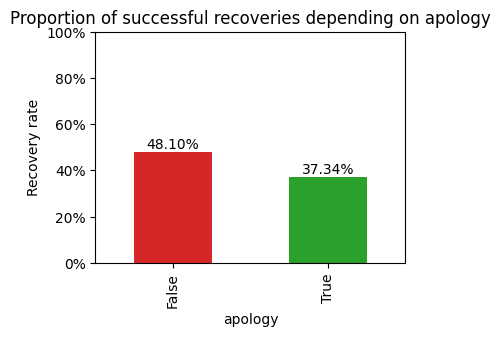

Matches loaded from file for treatment clickbait.


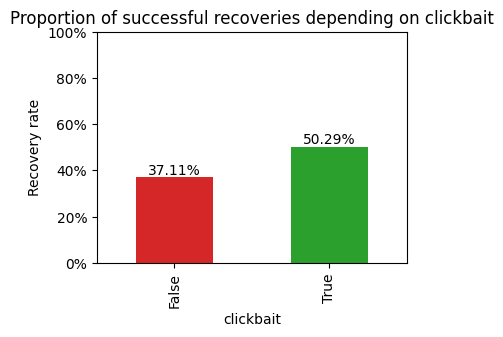

Matches loaded from file for treatment break.


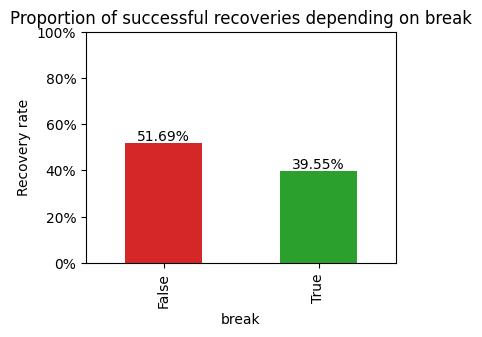

Matches loaded from file for treatment comeback.


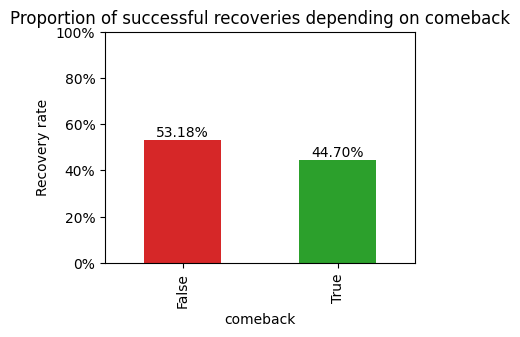

Matches loaded from file for treatment featuring.


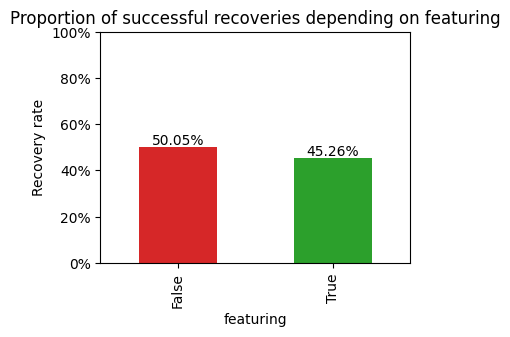

Matches loaded from file for treatment decline_addressed.


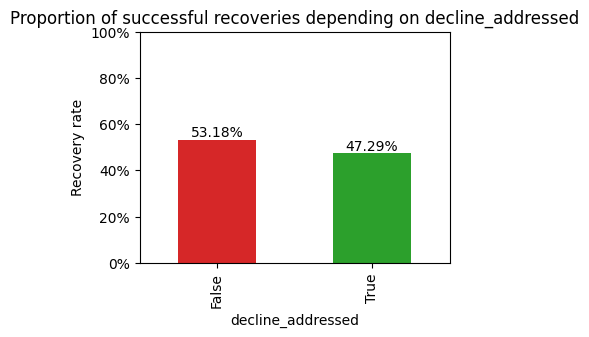

In [12]:
# Load the file
df_bb_declines_llm = pd.read_csv('data/1M_plus_decline_events_with_LLM_results.csv', index_col=0)

# The variables to be used for the matching
# Strategies in the same array will be plotted together
STRATEGIES = [ 					
    'apology',
    'clickbait',
    'break',
    'comeback',
    'featuring',
    'decline_addressed'
]

TO_DROP = [['Videos_after'] for _ in STRATEGIES]

propensity_score_matching(df_bb_declines_llm, STRATEGIES, TO_DROP)

## How is the overall recovery distributed for big youtubers?

In [13]:
# Overall
counts = df_bb_declines_llm['Recovered'].value_counts(normalize=False)

counts

Recovered
False    1583
True     1372
Name: count, dtype: int64

## How is the recovery by category distributed for big youtubers?

In [14]:
# By category
counts = df_bb_declines_llm.groupby('Category')['Recovered'].value_counts(normalize=True).unstack().fillna(0) * 100

counts

Recovered                 False       True 
Category                                   
Autos & Vehicles      10.000000   90.000000
Comedy                42.352941   57.647059
Education             59.493671   40.506329
Entertainment         51.527778   48.472222
Film and Animation    48.181818   51.818182
Gaming                45.333333   54.666667
Howto & Style         50.621118   49.378882
Music                 83.148559   16.851441
News & Politics       52.380952   47.619048
People & Blogs        47.552448   52.447552
Pets & Animals        50.000000   50.000000
Science & Technology  40.000000   60.000000
Sports                57.575758   42.424242
Travel & Events        0.000000  100.000000

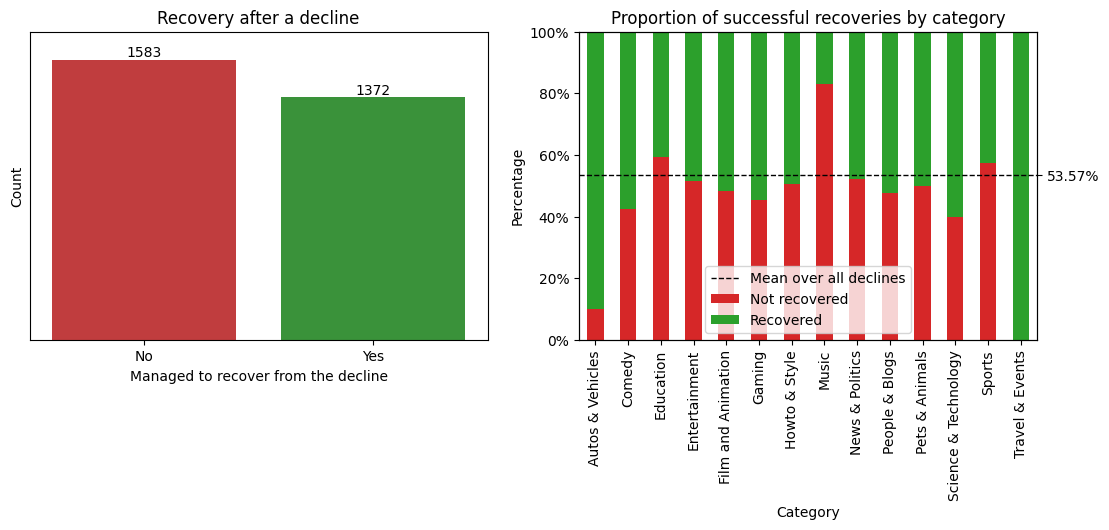

In [15]:
plot_recovered_by_categories(df_bb_declines_llm)

## Analysis of the strategies proportions and recovery rates

### Single-type strategies

In [16]:
# Compute the proportions for each strategy for all videos
proportions = pd.DataFrame({
    'Column': STRATEGIES,
    'Proportion (%)': [df_bb_declines_llm[col].sum()/len(df_bb_declines_llm) * 100 for col in STRATEGIES]
}).round(2)

proportions

Column  Proportion (%)
0            apology            5.35
1          clickbait           76.38
2              break           11.98
3           comeback           15.97
4          featuring           33.20
5  decline_addressed           28.76

In [17]:
# Compute the recovery rates for each strategy
reco_rates = {'Strategy': [], 'Recovery Rate (%)': []}

# Compute recovery rate for each strategy
for strategy in STRATEGIES:
    if strategy in df_bb_declines_llm.columns:  # Ensure the column exists        
        # Compute recovery rate (mean of 'Recovered' values multiplied by 100 for percentage)
        recovery_rate = df_bb_declines_llm.groupby(strategy)['Recovered'].mean() * 100
        
        # Append results to the dictionary
        reco_rates['Strategy'].append(strategy)
        reco_rates['Recovery Rate (%)'].append(round(recovery_rate[True], 2) if True in recovery_rate.index else 0)

# Convert the dictionary into a DataFrame
df_recovery_rates = pd.DataFrame(reco_rates)

df_recovery_rates

Strategy  Recovery Rate (%)
0            apology              37.34
1          clickbait              49.31
2              break              39.55
3           comeback              44.70
4          featuring              45.26
5  decline_addressed              47.29

### Single-type exclusive strategies

In [18]:
# Compute the proportions for each exclusive strategy
exclusive_proportions = pd.DataFrame({
    'Column': STRATEGIES,
    'Proportion (%)': [(df_bb_declines_llm[(df_bb_declines_llm[STRATEGIES].drop(col, axis=1) == 0).all(axis=1)][col].sum()/len(df_bb_declines_llm))*100 for col in STRATEGIES]
}).round(2)

exclusive_proportions

Column  Proportion (%)
0            apology            0.00
1          clickbait           30.73
2              break            0.00
3           comeback            0.07
4          featuring            1.25
5  decline_addressed            0.00

In [19]:
exclusive_reco_rates = {'Strategy': [], 'Recovery Rate (%)': []}

# Compute recovery rate for each strategy
for strategy in STRATEGIES:
    if strategy in df_bb_declines_llm.columns:  # Ensure the column exists
        # Filter rows where all other columns are 0
        filtered_data = df_bb_declines_llm[(df_bb_declines_llm[STRATEGIES].drop(strategy, axis=1) == 0).all(axis=1)]
        
        # Compute recovery rate (mean of 'Recovered' values multiplied by 100 for percentage)
        recovery_rate = filtered_data.groupby(strategy)['Recovered'].mean() * 100
        
        # Append results to the dictionary
        exclusive_reco_rates['Strategy'].append(strategy)
        exclusive_reco_rates['Recovery Rate (%)'].append(round(recovery_rate[True], 2) if True in recovery_rate.index else 0)

# Convert the dictionary into a DataFrame
df_exclusive_recovery_rates = pd.DataFrame(exclusive_reco_rates)

# Sort the DataFrame by Recovery Rate in descending order
# df_recovery_rates = df_recovery_rates.sort_values(by='Recovery Rate (%)', ascending=False)

df_exclusive_recovery_rates

Strategy  Recovery Rate (%)
0            apology               0.00
1          clickbait              52.20
2              break               0.00
3           comeback              50.00
4          featuring              18.92
5  decline_addressed               0.00

### Preparation for multi-type strategies analysis

In [20]:
# Iterate through all combinations of the LLM columns
for i in range(2, len(STRATEGIES) + 1):  # Start with combinations of 2 columns
    for combo in combinations(STRATEGIES, i):
        # Create a new column name based on the combination
        col_name = '_&_'.join(combo)
        
        # Compute the AND operation: True if all are True, else False
        df_bb_declines_llm[col_name] = df_bb_declines_llm[list(combo)].all(axis=1)

### Multi-type strategies

We analize the results of the combinations of the strategies with results determined by the LLM.

In [21]:
MULTI_STRATEGIES = [
    'apology_&_clickbait',
    'apology_&_break',
    'apology_&_comeback',
    'apology_&_featuring',
    'apology_&_decline_addressed',
    'clickbait_&_break',
    'clickbait_&_comeback',
    'clickbait_&_featuring',
    'clickbait_&_decline_addressed',
    'break_&_comeback',
    'break_&_featuring',
    'break_&_decline_addressed',
    'comeback_&_featuring',
    'comeback_&_decline_addressed',
    'featuring_&_decline_addressed',
    'apology_&_clickbait_&_break',
    'apology_&_clickbait_&_comeback',
    'apology_&_clickbait_&_featuring',
    'apology_&_clickbait_&_decline_addressed',
    'apology_&_break_&_comeback',
    'apology_&_break_&_featuring',
    'apology_&_break_&_decline_addressed',
    'apology_&_comeback_&_featuring',
    'apology_&_comeback_&_decline_addressed',
    'apology_&_featuring_&_decline_addressed',
    'clickbait_&_break_&_comeback',
    'clickbait_&_break_&_featuring',
    'clickbait_&_break_&_decline_addressed',
    'clickbait_&_comeback_&_featuring',
    'clickbait_&_comeback_&_decline_addressed',
    'clickbait_&_featuring_&_decline_addressed',
    'break_&_comeback_&_featuring',
    'break_&_comeback_&_decline_addressed',
    'break_&_featuring_&_decline_addressed',
    'comeback_&_featuring_&_decline_addressed',
    'apology_&_clickbait_&_break_&_comeback',
    'apology_&_clickbait_&_break_&_featuring',
    'apology_&_clickbait_&_break_&_decline_addressed',
    'apology_&_clickbait_&_comeback_&_featuring',
    'apology_&_clickbait_&_comeback_&_decline_addressed',
    'apology_&_clickbait_&_featuring_&_decline_addressed',
    'apology_&_break_&_comeback_&_featuring',
    'apology_&_break_&_comeback_&_decline_addressed',
    'apology_&_break_&_featuring_&_decline_addressed',
    'apology_&_comeback_&_featuring_&_decline_addressed',
    'clickbait_&_break_&_comeback_&_featuring',
    'clickbait_&_break_&_comeback_&_decline_addressed',
    'clickbait_&_break_&_featuring_&_decline_addressed',
    'clickbait_&_comeback_&_featuring_&_decline_addressed',
    'break_&_comeback_&_featuring_&_decline_addressed',
    'apology_&_clickbait_&_break_&_comeback_&_featuring',
    'apology_&_clickbait_&_break_&_comeback_&_decline_addressed',
    'apology_&_clickbait_&_break_&_featuring_&_decline_addressed',
    'apology_&_clickbait_&_comeback_&_featuring_&_decline_addressed',
    'apology_&_break_&_comeback_&_featuring_&_decline_addressed',
    'clickbait_&_break_&_comeback_&_featuring_&_decline_addressed',
    'apology_&_clickbait_&_break_&_comeback_&_featuring_&_decline_addressed'
]

In [22]:
# Compute the proportion for each combination of strategies
combo_proportions = pd.DataFrame({
    'Column': MULTI_STRATEGIES,
    'Proportion (%)': [df_bb_declines_llm[col].sum()/len(df_bb_declines_llm) * 100 for col in MULTI_STRATEGIES]
}).round(2)

combo_proportions

Column  Proportion (%)
0                                 apology_&_clickbait            5.35
1                                     apology_&_break            3.99
2                                  apology_&_comeback            2.74
3                                 apology_&_featuring            3.69
4                         apology_&_decline_addressed            5.14
5                                   clickbait_&_break           11.95
6                                clickbait_&_comeback           15.91
7                               clickbait_&_featuring           31.95
8                       clickbait_&_decline_addressed           28.73
9                                    break_&_comeback            5.79
10                                  break_&_featuring            7.51
11                          break_&_decline_addressed           11.64
12                               comeback_&_featuring           10.66
13                       comeback_&_decline_addressed           11.47
14                      featuring_&_decline_addressed           17.16
15                        apology_&_clickbait_&_break            3.99
16                     apology_&_clickbait_&_comeback            2.74
17                    apology_&_clickbait_&_featuring            3.69
18            apology_&_clickbait_&_decline_addressed            5.14
19                         apology_&_break_&_comeback            2.30
20                        apology_&_break_&_featuring            2.94
21                apology_&_break_&_decline_addressed            3.96
22                     apology_&_comeback_&_featuring            2.03
23             apology_&_comeback_&_decline_addressed            2.74
24            apology_&_featuring_&_decline_addressed            3.55
25                       clickbait_&_break_&_comeback            5.79
26                      clickbait_&_break_&_featuring            7.51
27              clickbait_&_break_&_decline_addressed           11.61
28                   clickbait_&_comeback_&_featuring           10.66
29           clickbait_&_comeback_&_decline_addressed           11.47
30          clickbait_&_featuring_&_decline_addressed           17.16
31                       break_&_comeback_&_featuring            4.03
32               break_&_comeback_&_decline_addressed            5.72
33              break_&_featuring_&_decline_addressed            7.31
34           comeback_&_featuring_&_decline_addressed            8.16
35             apology_&_clickbait_&_break_&_comeback            2.30
36            apology_&_clickbait_&_break_&_featuring            2.94
37    apology_&_clickbait_&_break_&_decline_addressed            3.96
38         apology_&_clickbait_&_comeback_&_featuring            2.03
39  apology_&_clickbait_&_comeback_&_decline_addre...            2.74
40  apology_&_clickbait_&_featuring_&_decline_addr...            3.55
41             apology_&_break_&_comeback_&_featuring            1.76
42     apology_&_break_&_comeback_&_decline_addressed            2.30
43    apology_&_break_&_featuring_&_decline_addressed            2.91
44  apology_&_comeback_&_featuring_&_decline_addre...            2.03
45           clickbait_&_break_&_comeback_&_featuring            4.03
46   clickbait_&_break_&_comeback_&_decline_addressed            5.72
47  clickbait_&_break_&_featuring_&_decline_addressed            7.31
48  clickbait_&_comeback_&_featuring_&_decline_add...            8.16
49   break_&_comeback_&_featuring_&_decline_addressed            3.96
50  apology_&_clickbait_&_break_&_comeback_&_featu...            1.76
51  apology_&_clickbait_&_break_&_comeback_&_decli...            2.30
52  apology_&_clickbait_&_break_&_featuring_&_decl...            2.91
53  apology_&_clickbait_&_comeback_&_featuring_&_d...            2.03
54  apology_&_break_&_comeback_&_featuring_&_decli...            1.76
55  clickbait_&_break_&_comeback_&_featuring_&_dec...            3.96
56  apology_&_clickbait_&_break_&_comeback_&_featu...    

In [23]:
# Compute the recovery rate for each combination of strategies
combo_reco_rates = {'Strategy': [], 'Recovery Rate (%)': []}

# Compute recovery rate for each strategy
for strategy in MULTI_STRATEGIES:
    if strategy in df_bb_declines_llm.columns:  # Ensure the column exists        
        # Compute recovery rate (mean of 'Recovered' values multiplied by 100 for percentage)
        recovery_rate = df_bb_declines_llm.groupby(strategy)['Recovered'].mean() * 100
        
        # Append results to the dictionary
        combo_reco_rates['Strategy'].append(strategy)
        combo_reco_rates['Recovery Rate (%)'].append(round(recovery_rate[True], 2) if True in recovery_rate.index else 0)

# Convert the dictionary into a DataFrame
df_combo_recovery_rates = pd.DataFrame(combo_reco_rates)

# Sort the DataFrame by Recovery Rate in descending order
# df_recovery_rates = df_recovery_rates.sort_values(by='Recovery Rate (%)', ascending=False)

df_combo_recovery_rates

Strategy  Recovery Rate (%)
0                                 apology_&_clickbait              37.34
1                                     apology_&_break              33.90
2                                  apology_&_comeback              35.80
3                                 apology_&_featuring              33.94
4                         apology_&_decline_addressed              36.84
5                                   clickbait_&_break              39.38
6                                clickbait_&_comeback              44.68
7                               clickbait_&_featuring              46.29
8                       clickbait_&_decline_addressed              47.23
9                                    break_&_comeback              38.60
10                                  break_&_featuring              36.04
11                          break_&_decline_addressed              40.12
12                               comeback_&_featuring              41.27
13                       comeback_&_decline_addressed              44.25
14                      featuring_&_decline_addressed              45.56
15                        apology_&_clickbait_&_break              33.90
16                     apology_&_clickbait_&_comeback              35.80
17                    apology_&_clickbait_&_featuring              33.94
18            apology_&_clickbait_&_decline_addressed              36.84
19                         apology_&_break_&_comeback              33.82
20                        apology_&_break_&_featuring              29.89
21                apology_&_break_&_decline_addressed              34.19
22                     apology_&_comeback_&_featuring              33.33
23             apology_&_comeback_&_decline_addressed              35.80
24            apology_&_featuring_&_decline_addressed              34.29
25                       clickbait_&_break_&_comeback              38.60
26                      clickbait_&_break_&_featuring              36.04
27              clickbait_&_break_&_decline_addressed              39.94
28                   clickbait_&_comeback_&_featuring              41.27
29           clickbait_&_comeback_&_decline_addressed              44.25
30          clickbait_&_featuring_&_decline_addressed              45.56
31                       break_&_comeback_&_featuring              31.93
32               break_&_comeback_&_decline_addressed              39.05
33              break_&_featuring_&_decline_addressed              37.04
34           comeback_&_featuring_&_decline_addressed              40.66
35             apology_&_clickbait_&_break_&_comeback              33.82
36            apology_&_clickbait_&_break_&_featuring              29.89
37    apology_&_clickbait_&_break_&_decline_addressed              34.19
38         apology_&_clickbait_&_comeback_&_featuring              33.33
39  apology_&_clickbait_&_comeback_&_decline_addre...              35.80
40  apology_&_clickbait_&_featuring_&_decline_addr...              34.29
41             apology_&_break_&_comeback_&_featuring              30.77
42     apology_&_break_&_comeback_&_decline_addressed              33.82
43    apology_&_break_&_featuring_&_decline_addressed              30.23
44  apology_&_comeback_&_featuring_&_decline_addre...              33.33
45           clickbait_&_break_&_comeback_&_featuring              31.93
46   clickbait_&_break_&_comeback_&_decline_addressed              39.05
47  clickbait_&_break_&_featuring_&_decline_addressed              37.04
48  clickbait_&_comeback_&_featuring_&_decline_add...              40.66
49   break_&_comeback_&_featuring_&_decline_addressed              32.48
50  apology_&_clickbait_&_break_&_comeback_&_featu...              30.77
51  apology_&_clickbait_&_break_&_comeback_&_decli...              33.82
52  apology_&_clickbait_&_break_&_featuring_&_decl...              30.23
53  apology_&_clickbait_&_comeback_&_featuring_&_d...              33.33
54  apology_&_break_&_comeback

### Multi-type exclusive strategies

In [24]:
exclusive_combo_proportions = pd.DataFrame({
    'Column': MULTI_STRATEGIES,
    'Proportion': [(df_bb_declines_llm[(df_bb_declines_llm[STRATEGIES].drop(get_combination_strategies(col), axis=1) == 0).all(axis=1)][col].sum()/len(df_bb_declines_llm))*100 for col in MULTI_STRATEGIES]
}).round(3)

exclusive_combo_proportions

Column  Proportion
0                                 apology_&_clickbait       0.068
1                                     apology_&_break       0.000
2                                  apology_&_comeback       0.000
3                                 apology_&_featuring       0.000
4                         apology_&_decline_addressed       0.000
5                                   clickbait_&_break       0.135
6                                clickbait_&_comeback       1.929
7                               clickbait_&_featuring      12.047
8                       clickbait_&_decline_addressed       5.347
9                                    break_&_comeback       0.000
10                                  break_&_featuring       0.000
11                          break_&_decline_addressed       0.034
12                               comeback_&_featuring       0.000
13                       comeback_&_decline_addressed       0.000
14                      featuring_&_decline_addressed       0.000
15                        apology_&_clickbait_&_break       0.000
16                     apology_&_clickbait_&_comeback       0.000
17                    apology_&_clickbait_&_featuring       0.102
18            apology_&_clickbait_&_decline_addressed       0.372
19                         apology_&_break_&_comeback       0.000
20                        apology_&_break_&_featuring       0.000
21                apology_&_break_&_decline_addressed       0.000
22                     apology_&_comeback_&_featuring       0.000
23             apology_&_comeback_&_decline_addressed       0.000
24            apology_&_featuring_&_decline_addressed       0.000
25                       clickbait_&_break_&_comeback       0.000
26                      clickbait_&_break_&_featuring       0.102
27              clickbait_&_break_&_decline_addressed       2.030
28                   clickbait_&_comeback_&_featuring       2.437
29           clickbait_&_comeback_&_decline_addressed       1.387
30          clickbait_&_featuring_&_decline_addressed       5.279
31                       break_&_comeback_&_featuring       0.000
32               break_&_comeback_&_decline_addressed       0.000
33              break_&_featuring_&_decline_addressed       0.000
34           comeback_&_featuring_&_decline_addressed       0.000
35             apology_&_clickbait_&_break_&_comeback       0.000
36            apology_&_clickbait_&_break_&_featuring       0.034
37    apology_&_clickbait_&_break_&_decline_addressed       0.508
38         apology_&_clickbait_&_comeback_&_featuring       0.000
39  apology_&_clickbait_&_comeback_&_decline_addre...       0.169
40  apology_&_clickbait_&_featuring_&_decline_addr...       0.372
41             apology_&_break_&_comeback_&_featuring       0.000
42     apology_&_break_&_comeback_&_decline_addressed       0.000
43    apology_&_break_&_featuring_&_decline_addressed       0.000
44  apology_&_comeback_&_featuring_&_decline_addre...       0.000
45           clickbait_&_break_&_comeback_&_featuring       0.068
46   clickbait_&_break_&_comeback_&_decline_addressed       1.218
47  clickbait_&_break_&_featuring_&_decline_addressed       2.200
48  clickbait_&_comeback_&_featuring_&_decline_add...       3.926
49   break_&_comeback_&_featuring_&_decline_addressed       0.000
50  apology_&_clickbait_&_break_&_comeback_&_featu...       0.000
51  apology_&_clickbait_&_break_&_comeback_&_decli...       0.541
52  apology_&_clickbait_&_break_&_featuring_&_decl...       1.151
53  apology_&_clickbait_&_comeback_&_featuring_&_d...       0.271
54  apology_&_break_&_comeback_&_featuring_&_decli...       0.000
55  clickbait_&_break_&_comeback_&_featuring_&_dec...       2.200
56  apology_&_clickbait_&_break_&_comeback_&_featu...       1.760

In [25]:
exclusive_combo_reco_rates = {'Strategy': [], 'Recovery Rate (%)': []}

# Compute recovery rate for each strategy
for strategy in MULTI_STRATEGIES:
    if strategy in df_bb_declines_llm.columns:  # Ensure the column exists
        # Filter rows where all other columns are 0
        filtered_data = df_bb_declines_llm[(df_bb_declines_llm[STRATEGIES].drop(get_combination_strategies(strategy), axis=1) == 0).all(axis=1)]
        
        # Compute recovery rate (mean of 'Recovered' values multiplied by 100 for percentage)
        recovery_rate = filtered_data.groupby(strategy)['Recovered'].mean() * 100
        
        # Append results to the dictionary
        exclusive_combo_reco_rates['Strategy'].append(strategy)
        exclusive_combo_reco_rates['Recovery Rate (%)'].append(round(recovery_rate[True], 2) if True in recovery_rate.index else 0)

# Convert the dictionary into a DataFrame
df_exclusive_combo_recovery_rates = pd.DataFrame(exclusive_combo_reco_rates)

# Sort the DataFrame by Recovery Rate in descending order
# df_combo_recovery_rates = df_combo_recovery_rates.sort_values(by='Recovery Rate (%)', ascending=False)

df_exclusive_combo_recovery_rates

Strategy  Recovery Rate (%)
0                                 apology_&_clickbait             100.00
1                                     apology_&_break               0.00
2                                  apology_&_comeback               0.00
3                                 apology_&_featuring               0.00
4                         apology_&_decline_addressed               0.00
5                                   clickbait_&_break              50.00
6                                clickbait_&_comeback              49.12
7                               clickbait_&_featuring              48.60
8                       clickbait_&_decline_addressed              53.80
9                                    break_&_comeback               0.00
10                                  break_&_featuring               0.00
11                          break_&_decline_addressed             100.00
12                               comeback_&_featuring               0.00
13                       comeback_&_decline_addressed               0.00
14                      featuring_&_decline_addressed               0.00
15                        apology_&_clickbait_&_break               0.00
16                     apology_&_clickbait_&_comeback               0.00
17                    apology_&_clickbait_&_featuring              33.33
18            apology_&_clickbait_&_decline_addressed              36.36
19                         apology_&_break_&_comeback               0.00
20                        apology_&_break_&_featuring               0.00
21                apology_&_break_&_decline_addressed               0.00
22                     apology_&_comeback_&_featuring               0.00
23             apology_&_comeback_&_decline_addressed               0.00
24            apology_&_featuring_&_decline_addressed               0.00
25                       clickbait_&_break_&_comeback               0.00
26                      clickbait_&_break_&_featuring               0.00
27              clickbait_&_break_&_decline_addressed              36.67
28                   clickbait_&_comeback_&_featuring              44.44
29           clickbait_&_comeback_&_decline_addressed              53.66
30          clickbait_&_featuring_&_decline_addressed              54.49
31                       break_&_comeback_&_featuring               0.00
32               break_&_comeback_&_decline_addressed               0.00
33              break_&_featuring_&_decline_addressed               0.00
34           comeback_&_featuring_&_decline_addressed               0.00
35             apology_&_clickbait_&_break_&_comeback               0.00
36            apology_&_clickbait_&_break_&_featuring               0.00
37    apology_&_clickbait_&_break_&_decline_addressed              46.67
38         apology_&_clickbait_&_comeback_&_featuring               0.00
39  apology_&_clickbait_&_comeback_&_decline_addre...              40.00
40  apology_&_clickbait_&_featuring_&_decline_addr...              54.55
41             apology_&_break_&_comeback_&_featuring               0.00
42     apology_&_break_&_comeback_&_decline_addressed               0.00
43    apology_&_break_&_featuring_&_decline_addressed               0.00
44  apology_&_comeback_&_featuring_&_decline_addre...               0.00
45           clickbait_&_break_&_comeback_&_featuring               0.00
46   clickbait_&_break_&_comeback_&_decline_addressed              58.33
47  clickbait_&_break_&_featuring_&_decline_addressed              49.23
48  clickbait_&_comeback_&_featuring_&_decline_add...              48.28
49   break_&_comeback_&_featuring_&_decline_addressed               0.00
50  apology_&_clickbait_&_break_&_comeback_&_featu...               0.00
51  apology_&_clickbait_&_break_&_comeback_&_decli...              43.75
52  apology_&_clickbait_&_break_&_featuring_&_decl...              29.41
53  apology_&_clickbait_&_comeback_&_featuring_&_d...              50.00
54  apology_&_break_&_comeback